In [469]:
import math
import os
import sys
import pandas as pd
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")

pd.options.mode.chained_assignment = None  # default='warn'
import multiprocessing
import parmap
import numpy as np
import collections
from tqdm import tqdm
import pandarallel
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=20, progress_bar=True)
# tqdm.pandas()
from pprint import pprint
from scipy.stats import zscore
from scipy import stats

import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mc
from matplotlib.colors import LogNorm
import json
import matplotlib.ticker as mtick
from utils.utils import load_config_file

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/EXOTIC/src/config.yaml")
exotic_files = yaml

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [436]:
refseq = pd.read_csv('/home/weber/PycharmProjects/ExoCarto/data/2_processed/DF_transformed.csv.gz', compression='gzip', sep='\t')
refseq = refseq.loc[refseq['mRNA_nb'] > 1]
refseq['Ratio_num'] = refseq['Ratio'].apply(eval)
refseq.loc[refseq['Ratio_num'] < 1,  'Const_Alt'] = 'Alt'
refseq.loc[refseq['Ratio_num'] == 1,  'Const_Alt'] = 'Const'
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = bins.copy()
labels_ratio = [str(round(labels[j], 1)) + " - " + str(round(labels[j + 1], 1)) for j in range(len(labels) - 1)]
refseq["Ratio_num_bins"] = pd.cut(refseq["Ratio_num"], bins=bins, labels=labels_ratio, include_lowest=True)
refseq = refseq.drop_duplicates(subset=['Gene', 'ranges'])
refseq

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Gene,Chrom,Start,End,ranges,Length,GeneID,HGNC,CDS_representation,Ratio,Sharing_status,Sources,Count_CDS_alternative,Count_CDS_constitutive,mRNA_IDS,mRNA_nb,Ratio_num,Const_Alt,Ratio_num_bins
47,PLEKHN1,1,901912,901994,901912-901994,82,84069,25284.0,Unique,3.0/3,False,"[(901912, 901994, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,1.0,Const,0.8 - 1
48,PLEKHN1,1,902084,902183,902084-902183,99,84069,25284.0,Unique,3.0/3,False,"[(902084, 902183, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,1.0,Const,0.8 - 1
49,PLEKHN1,1,905657,905803,905657-905803,146,84069,25284.0,Unique,3.0/3,False,"[(905657, 905803, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,1.0,Const,0.8 - 1
50,PLEKHN1,1,905901,905981,905901-905981,80,84069,25284.0,Unique,3.0/3,False,"[(905901, 905981, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,1.0,Const,0.8 - 1
51,PLEKHN1,1,906066,906138,906066-906138,72,84069,25284.0,Unique,3.0/3,False,"[(906066, 906138, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,1.0,Const,0.8 - 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238547,DAZ4,Y,27042652,27042686,27042652-27042686,34,57135,15966.0,Unique,2.0/2,False,"[(27042652, 27042686, '2.0/2')]",6,16,"['NM_001005375.2', 'NM_020420.3']",2,1.0,Const,0.8 - 1
238549,DAZ4,Y,27047259,27047322,27047259-27047322,63,57135,15966.0,Unique,2.0/2,False,"[(27047259, 27047322, '2.0/2')]",6,16,"['NM_001005375.2', 'NM_020420.3']",2,1.0,Const,0.8 - 1
238563,CDY1,Y,27768590,27770181,27768590-27770181,1591,9085,1809.0,Variable_region,2.0/2,True,"[(27768590, 27770181, '1.0/2'), (27768590, 277...",2,1,"['NM_004680.2', 'NM_170723.1']",2,1.0,Const,0.8 - 1
238565,CDY1,Y,27770181,27770212,27770181-27770212,31,9085,1809.0,Variable_region,1.0/2,True,"[(27768590, 27770212, '1.0/2')]",2,1,"['NM_004680.2', 'NM_170723.1']",2,0.5,Alt,0.4 - 0.6


In [445]:
refseq_corrected_by_gtex

,Gene,ranges,mRNA_exons,mRNA_nb,mRNA_gene,mRNA_nb_total,Ratio,new_mRNA_exons,new_mRNA_nb,Same_nb_mRNA_exons,new_mRNA_gene,new_mRNA_nb_total,Same_nb_mRNA_gene,Unchanged
0,A2M,9220419-9220435,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,4/4,"['NM_001347423', 'NM_001347425', 'NM_000014', ...",4,True,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,True,True
1,A2M,9220779-9220820,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,4/4,"['NM_001347423', 'NM_001347425', 'NM_000014', ...",4,True,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,True,True
2,A2M,9221336-9221438,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,4/4,"['NM_001347423', 'NM_001347425', 'NM_000014', ...",4,True,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,True,True
3,A2M,9222341-9222409,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,4/4,"['NM_001347423', 'NM_001347425', 'NM_000014', ...",4,True,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,True,True
4,A2M,9223084-9223174,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,4/4,"['NM_001347423', 'NM_001347425', 'NM_000014', ...",4,True,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176794,ZZZ3,78047461-78047576,"[NM_001308237, NM_015534]",2,"[NM_015534, NM_001308237]",2,2/2,"['NM_001308237', 'NM_015534']",2,True,"[NM_015534, NM_001308237]",2,True,True
176795,ZZZ3,78047664-78047811,"[NM_001308237, NM_015534]",2,"[NM_015534, NM_001308237]",2,2/2,"['NM_001308237', 'NM_015534']",2,True,"[NM_015534, NM_001308237]",2,True,True
176796,ZZZ3,78050202-78050340,"[NM_001308237, NM_015534]",2,"[NM_015534, NM_001308237]",2,2/2,"['NM_001308237', 'NM_015534']",2,True,"[NM_015534, NM_001308237]",2,True,True
176797,ZZZ3,78097535-78099039,[NM_015534],1,"[NM_015534, NM_001308237]",2,1/2,['NM_015534'],1,True,[NM_015534],1,False,False


In [481]:
refseq_corrected_by_gtex = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/refseq_old_new.parquet')
refseq_corrected_by_gtex['New_Ratio'] = refseq_corrected_by_gtex['new_mRNA_nb'].astype(str) + '/' + refseq_corrected_by_gtex['new_mRNA_nb_total'].astype(str)
refseq_corrected_by_gtex['New_Ratio_num'] = refseq_corrected_by_gtex['New_Ratio'].apply(eval)
print(refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['mRNA_nb_total'] == 1, 'Gene'].nunique())
print(refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['new_mRNA_nb_total'] == 1, 'Gene'].nunique())
print(refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['new_mRNA_nb_total'] > 1, 'Gene'].nunique())

print(refseq_corrected_by_gtex.Gene.nunique())

5657
7625
7727
15352


In [482]:
refseq_corrected_by_gtex

,Gene,ranges,mRNA_exons,mRNA_nb,mRNA_gene,mRNA_nb_total,Ratio,new_mRNA_exons,new_mRNA_nb,new_mRNA_gene,Same_nb_mRNA_exons,new_mRNA_nb_total,Same_nb_mRNA_gene,Unchanged,New_Ratio,New_Ratio_num
0,A2M,9220419-9220435,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,4/4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347424, NM_001347423, NM_000014, NM_001...",True,4,True,True,4/4,1.0
1,A2M,9220779-9220820,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,4/4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347424, NM_001347423, NM_000014, NM_001...",True,4,True,True,4/4,1.0
2,A2M,9221336-9221438,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,4/4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347424, NM_001347423, NM_000014, NM_001...",True,4,True,True,4/4,1.0
3,A2M,9222341-9222409,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,4/4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347424, NM_001347423, NM_000014, NM_001...",True,4,True,True,4/4,1.0
4,A2M,9223084-9223174,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_000014, NM_001347425, NM_001347423, NM_001...",4,4/4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347424, NM_001347423, NM_000014, NM_001...",True,4,True,True,4/4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176794,ZZZ3,78047461-78047576,"[NM_001308237, NM_015534]",2,"[NM_015534, NM_001308237]",2,2/2,"[NM_001308237, NM_015534]",2,"[NM_016529, NM_001313741]",True,2,True,True,2/2,1.0
176795,ZZZ3,78047664-78047811,"[NM_001308237, NM_015534]",2,"[NM_015534, NM_001308237]",2,2/2,"[NM_001308237, NM_015534]",2,"[NM_016529, NM_001313741]",True,2,True,True,2/2,1.0
176796,ZZZ3,78050202-78050340,"[NM_001308237, NM_015534]",2,"[NM_015534, NM_001308237]",2,2/2,"[NM_001308237, NM_015534]",2,"[NM_016529, NM_001313741]",True,2,True,True,2/2,1.0
176797,ZZZ3,78097535-78099039,[NM_015534],1,"[NM_015534, NM_001308237]",2,1/2,[NM_015534],1,"[NM_016529, NM_001313741]",True,2,True,True,1/2,0.5


In [460]:
t = refseq_corrected_by_gtex.groupby(['Gene', 'new_mRNA_nb_total'])['ranges'].agg('nunique').reset_index()

print(t.loc[t['ranges'] == 1].shape[0])
print(t.loc[t['ranges'] > 1].shape[0])

print(t.loc[(t['new_mRNA_nb_total'] == 1) & (t['ranges'] == 1)].shape[0])
print(t.loc[(t['new_mRNA_nb_total'] == 1) & (t['ranges'] > 1)].shape[0])


print(t.loc[(t['new_mRNA_nb_total'] > 1) & (t['ranges'] == 1)].shape[0])
print(t.loc[(t['new_mRNA_nb_total'] > 1) & (t['ranges'] > 1)].shape[0])

970
14382
466
7159
504
7223


In [ ]:
merge_check

In [1257]:
refseq.Gene.nunique()

10936

In [473]:
biomart_grch37 = pd.read_csv(
    exotic_files["EXOTIC"]["biomart_ensembl_hgnc_refseq"],
    sep="\t",
)
biomart_grch37 = biomart_grch37[
    [
        "Transcript stable ID",
        "Transcript name",
        "Transcript type",
        "APPRIS annotation",
        "RefSeq mRNA ID",
        "Transcript support level (TSL)",
        "HGNC ID",
    ]
]

biomart_grch37.columns = [
    "transcript_id",
    "transcript_name",
    "transcript_biotype",
    "APPRIS",
    "RefSeq_mRNAID",
    "TSL",
    "HGNC_ID",
]

biomart_grch37 = biomart_grch37.loc[biomart_grch37['transcript_biotype'] == 'protein_coding']
transcript_protein_coding = biomart_grch37.transcript_id.values.tolist()
biomart_grch37

,transcript_id,transcript_name,transcript_biotype,APPRIS,RefSeq_mRNAID,TSL,HGNC_ID
5,ENST00000361390,MT-ND1-201,protein_coding,principal1,NaN,tslNA,HGNC:7455
9,ENST00000361453,MT-ND2-201,protein_coding,principal1,NaN,tslNA,HGNC:7456
15,ENST00000361624,MT-CO1-201,protein_coding,principal1,NaN,tslNA,HGNC:7419
18,ENST00000361739,MT-CO2-201,protein_coding,principal1,NaN,tslNA,HGNC:7421
20,ENST00000361851,MT-ATP8-201,protein_coding,principal1,NaN,tslNA,HGNC:7415
...,...,...,...,...,...,...,...
272408,ENST00000320865,B3GNTL1-201,protein_coding,principal1,NM_001320742,tsl1,HGNC:21727
272418,ENST00000320095,METRNL-201,protein_coding,principal2,NM_001004431,tsl1 (assigned to previous version 11),HGNC:27584
272419,ENST00000570778,METRNL-202,protein_coding,alternative2,NaN,tsl5,HGNC:27584
272420,ENST00000571814,METRNL-203,protein_coding,alternative2,NM_001363853,tsl1,HGNC:27584


In [475]:
gtex_check = pd.read_csv('/gstock/biolo_datasets/variation/benchmark/Databases/GTEX/V7/GTEx_Analysis_2016-01-15_v7_RSEMv1.2.22_transcript_final_check.txt.gz', compression='gzip', sep='\t')
gtex_check['transcript_id'] = gtex_check['transcript_id'].apply(lambda r: r.split('.')[0])
gtex_check

,Chrom,Start,End,Strand,gene_id,gene_symbol,transcript_id,check_reads_below_cutoff,check_reads,check_tpm_below_cutoff,check_tpm,check
0,17,37007777,37007912,-,ENSG00000252699,SNORA21B,ENST00000516890,0,False,1112,False,False
1,17,37009116,37009247,-,ENSG00000199293,SNORA21,ENST00000362423,0,False,2056,False,False
2,17,37011567,37011923,+,ENSG00000244086,AC110749.1,ENST00000462007,255,False,3784,True,False
3,17,37026112,37078023,+,ENSG00000002834,LASP1,ENST00000318008,11688,True,11688,True,True
4,17,37026112,37078023,+,ENSG00000002834,LASP1,ENST00000419929,252,False,574,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
252037,Y,28695572,28695890,+,ENSG00000224240,CYCSP49,ENST00000420810,0,False,252,False,False
252038,Y,28732789,28737748,-,ENSG00000227629,SLC25A15P1,ENST00000456738,0,False,19,False,False
252039,Y,28740998,28780799,-,ENSG00000237917,PARP4P1,ENST00000435945,1205,False,1273,False,False
252040,Y,28772667,28773306,-,ENSG00000231514,CCNQP2,ENST00000435741,0,False,327,False,False


In [483]:
gtex_check.gene_id.nunique()

52114

In [484]:
gtex_check.loc[gtex_check['transcript_id'].isin(transcript_protein_coding), 'gene_id'].nunique()

18879

In [485]:
gtex_check.loc[gtex_check['transcript_id'].isin(transcript_protein_coding) & (gtex_check['check'] == True) , 'gene_id'].nunique()

15824

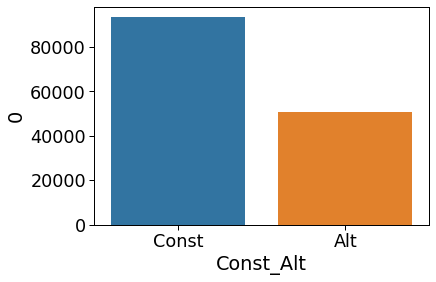

In [1063]:
t = refseq.groupby('Const_Alt').size().reset_index()
sns.barplot(data=t.sort_values(by='Const_Alt', ascending=False), x='Const_Alt', y=0)

In [15]:
refseq[['Gene', 'ranges', 'Const_Alt', 'Length']]

,Gene,ranges,Const_Alt,Length
47,PLEKHN1,901912-901994,Const,82
48,PLEKHN1,902084-902183,Const,99
49,PLEKHN1,905657-905803,Const,146
50,PLEKHN1,905901-905981,Const,80
51,PLEKHN1,906066-906138,Const,72
...,...,...,...,...
238547,DAZ4,27042652-27042686,Const,34
238549,DAZ4,27047259-27047322,Const,63
238563,CDY1,27768590-27770181,Const,1591
238565,CDY1,27770181-27770212,Alt,31


Const_Alt           Alt         Const
count      50897.000000  93326.000000
mean         120.554433    157.969933
std          238.302522    233.222200
min            1.000000      1.000000
25%           42.000000     84.000000
50%           88.000000    120.000000
75%          140.000000    164.000000
max        17330.000000  16736.000000


MannwhitneyuResult(statistic=1704455322.5, pvalue=0.0)

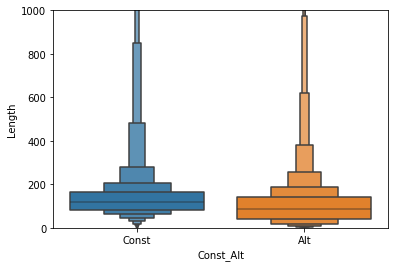

In [17]:
print(refseq[['Gene', 'ranges', 'Const_Alt', 'Length']].pivot(columns='Const_Alt', values='Length').describe())

sns.boxenplot(data=refseq[['Const_Alt', 'Length']], x='Const_Alt', y='Length')
plt.ylim(0, 1000)
stats.mannwhitneyu(refseq.loc[refseq['Const_Alt'] == 'Const', 'Length'].values, refseq.loc[refseq['Const_Alt'] == 'Alt', 'Length'].values)


Const_Alt          Alt         Const
count      9643.000000  10705.000000
mean          5.278129      8.717982
std           7.049666      8.279021
min           1.000000      1.000000
25%           2.000000      3.000000
50%           3.000000      6.000000
75%           6.000000     11.000000
max         320.000000    147.000000
Const v.s. Alt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=6.966e+07


MannwhitneyuResult(statistic=33569524.5, pvalue=0.0)

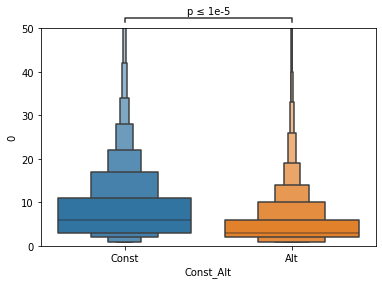

In [7]:
from statannot import add_stat_annotation

t = refseq[['Gene', 'Const_Alt']].groupby(['Gene', 'Const_Alt']).size().reset_index()
print(t.pivot(index='Gene', columns='Const_Alt', values=0).describe())

t = t.sort_values(by='Const_Alt', ascending=False)
ax = sns.boxenplot(data=t, x='Const_Alt', y=0)
order = ['Const', 'Alt']

plt.ylim(0, 50)
add_stat_annotation(ax, data=t, x='Const_Alt', y=0, order= ['Const', 'Alt'],
                    box_pairs=[('Const', 'Alt')],
                    test='Mann-Whitney', text_format='simple', loc='outside', verbose=2)
stats.mannwhitneyu(t.loc[t['Const_Alt'] == 'Const', 0].values, t.loc[t['Const_Alt'] == 'Alt', 0].values)

In [1259]:
refseq[['Gene', 'Const_Alt']].groupby(['Gene', 'Const_Alt']).size().reset_index().groupby('Const_Alt').describe()

0                                                
             count      mean       std  min  25%  50%   75%    max
Const_Alt                                                         
Alt         9643.0  5.278129  7.049666  1.0  2.0  3.0   6.0  320.0
Const      10705.0  8.717982  8.279021  1.0  3.0  6.0  11.0  147.0

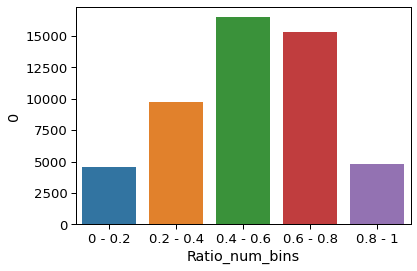

In [299]:
t = refseq.loc[refseq['Const_Alt'] == 'Alt', ['Ratio_num_bins']].groupby('Ratio_num_bins').size().reset_index()
t = t.sort_values(by='Ratio_num_bins', ascending=False)
sns.barplot(data=t, x='Ratio_num_bins', y=0)
# plt.ylim(0, 700)

(0.0, 40.0)

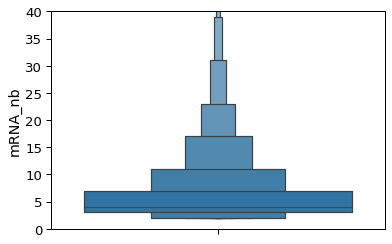

In [305]:
sns.boxenplot(data=refseq.loc[refseq['Const_Alt'] == 'Alt', ['mRNA_nb']], y='mRNA_nb')
plt.ylim(0, 40)

In [508]:
refseq.loc[refseq['Const_Alt'] == 'Alt', ['Length']].describe()

,Length
count,50897.000000
mean,120.554433
std,238.302522
min,1.000000
25%,42.000000
50%,88.000000
75%,140.000000
max,17330.000000


In [579]:
pd.concat([cs, refseq_lite.groupby('mRNA_nb').size().reset_index()], axis=1)

,mRNA_nb,0,mRNA_nb,0
0,2,0.389082,2,4255
1,3,0.615216,3,2473
2,4,0.746159,4,1432
3,5,0.825988,5,873
4,6,0.873903,6,524
5,7,0.903987,7,329
6,8,0.925110,8,231
7,9,0.942392,9,189
8,10,0.953731,10,124
9,11,0.960955,11,79


(0.0, 25.0)

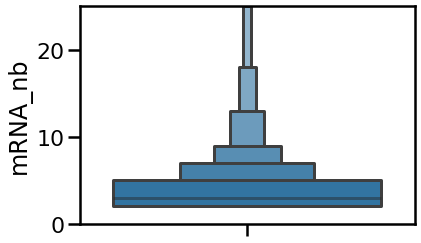

In [495]:
sns.boxenplot(data=refseq_lite, y='mRNA_nb')
plt.ylim(0,25)

            Gene  mRNA_nb
47       PLEKHN1        3
64         PERM1        4
70          HES4        2
77          AGRN        3
118     C1orf159        3
...          ...      ...
238365    RBMY1F        2
238448      DAZ2        3
238471     CDY1B        2
238507      DAZ4        2
238563      CDY1        2

[10936 rows x 2 columns]
45530


Text(-0.1, 1.05, 'a')

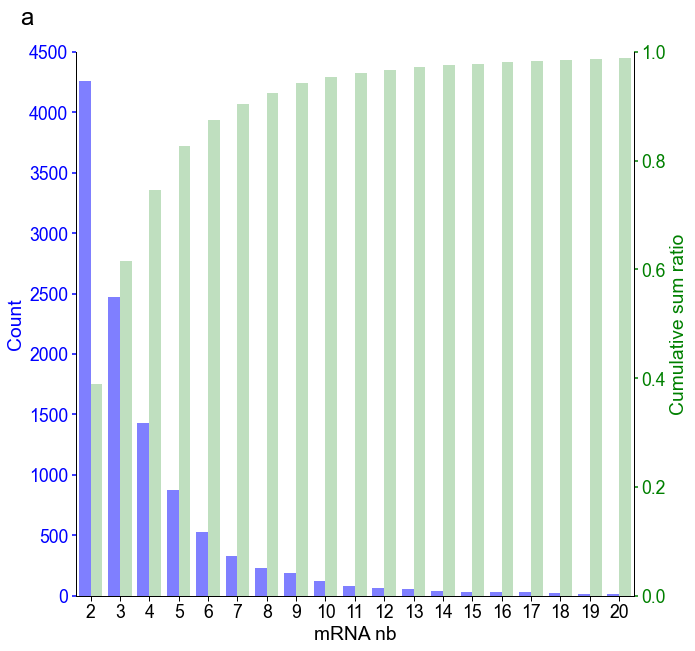

In [487]:
refseq_lite = refseq.loc[refseq['mRNA_nb'] > 1, ['Gene', 'mRNA_nb']].drop_duplicates()

print(refseq_lite)
print(refseq_lite.mRNA_nb.sum())
sns.set_context('paper', font_scale=2)
f, ax = plt.subplots(figsize=(10,10))
data = refseq_lite.groupby('mRNA_nb').size().reset_index()
cs = refseq_lite.groupby('mRNA_nb').size().cumsum() / refseq_lite.groupby('mRNA_nb').size().sum()
cs = cs.reset_index()
# ax.bar(x=[1,2,3], y=[2,3,4], )
ax1_ = ax.bar(data.mRNA_nb.values, data[0].values,
#        yerr=error,
       align='edge',
       alpha=0.5,
       color='b',
       width=-0.4
#        ecolor='black',
#        color=list(reversed(sns.color_palette('mako'))),
#        color=sns.color_palette('YlOrBr'),
#        zorder=3,
#        **hfont
      )
ax2 = ax.twinx()
ax2_ = ax2.bar(cs.mRNA_nb.values, cs[0].values, alpha=0.25, color='g', align='edge', width=0.4)
ax2.set_xlim(1.5,20.5)
ax.set_xticks(np.arange(2,21))

# ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: round(x, 0)))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax.yaxis.label.set_color('b')
ax2.yaxis.label.set_color('g')

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors='b', **tkw)
ax2.tick_params(axis='y', colors='g', **tkw)
ax.set_ylabel('Count')
ax.set_xlabel('mRNA nb')
ax2.set_ylabel('Cumulative sum ratio')
ax.spines['top'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax.set_ylim(0,4500)
ax2.set_ylim(0,1)
ax.text(-0.1, 1.05, 'a', transform=ax.transAxes, size=24, weight='bold')

(0.0, 1.0)

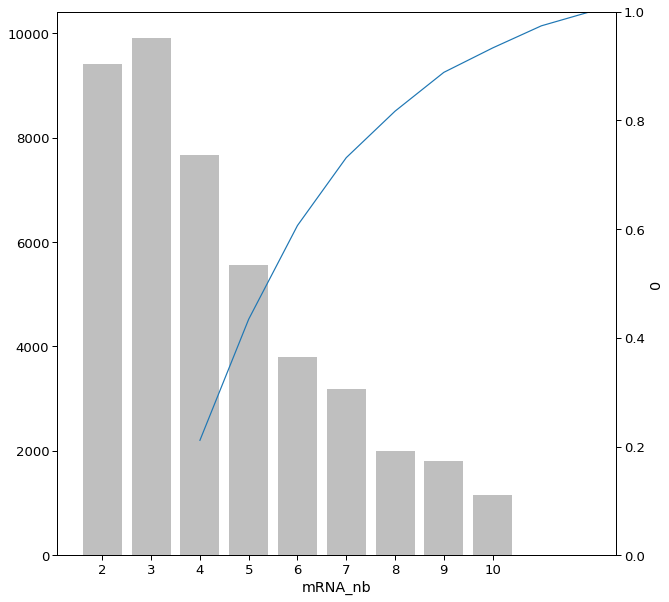

In [410]:
f, ax = plt.subplots(figsize=(10,10))

# ax.set_xlim(2,10)
data = refseq.loc[(refseq['Const_Alt'] == 'Alt') & (refseq['mRNA_nb'] <= 10), ['mRNA_nb']].groupby('mRNA_nb').size().reset_index()
ax =sns.barplot(data=data, x='mRNA_nb', y=data[0].values,  color='grey', alpha=0.5, ax=ax)
# ax.set_xlim(2,10)
ax2 = ax.twinx()



# ax2.set_xticklabels(ax2.get_xticklabels(),  rotation=90, fontsize=8)
cs = refseq.loc[(refseq['Const_Alt'] == 'Alt') & (refseq['mRNA_nb'] <= 10), ['mRNA_nb']].groupby('mRNA_nb').size().cumsum() / refseq.loc[(refseq['Const_Alt'] == 'Alt') & (refseq['mRNA_nb'] <= 10), ['mRNA_nb']].groupby('mRNA_nb').size().sum()
f1 = sns.lineplot(data=cs.reset_index(), x='mRNA_nb', y=0, ax=ax2)
# ax2.set_xlim(2,10)
ax2.set_ylim(0,1)


(0.0, 700.0)

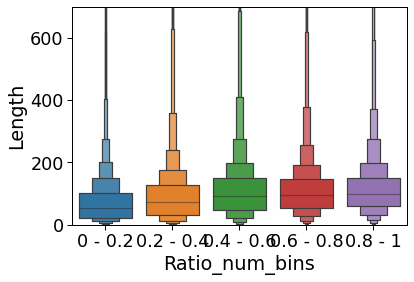

In [1085]:
t = refseq.loc[refseq['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins', 'Length']]
t = t.sort_values(by='Ratio_num_bins', ascending=False)
sns.boxenplot(data=t, x='Ratio_num_bins', y='Length')
plt.ylim(0, 700)

(0.0, 25.0)

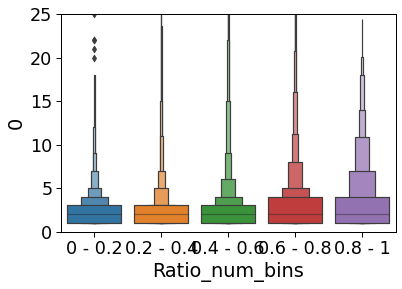

In [1082]:
t = refseq.loc[refseq['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index()
t = t.sort_values(by='Ratio_num_bins', ascending=False)
sns.boxenplot(data=t, x='Ratio_num_bins', y=0)
plt.ylim(0, 25)

In [516]:
refseq.loc[refseq['Const_Alt'] == 'Alt', 'Length'].values

array([ 36, 140,  66, ...,  71,  31,  72])

In [514]:
scipy.stats.mannwhitneyu(refseq.loc[refseq['Const_Alt'] == 'Const', 'Length'].values, refseq.loc[refseq['Const_Alt'] == 'Alt', 'Length'].values)

MannwhitneyuResult(statistic=1704455322.5, pvalue=0.0)

Rectangle(xy=(-0.15, 0), width=0.3, height=93326, angle=0)
Rectangle(xy=(0.85, 0), width=0.3, height=50897, angle=0)
Rectangle(xy=(-0.25, 0), width=0.5, height=4585, angle=0)
Rectangle(xy=(0.75, 0), width=0.5, height=9705, angle=0)
Rectangle(xy=(1.75, 0), width=0.5, height=16492, angle=0)
Rectangle(xy=(2.75, 0), width=0.5, height=15288, angle=0)
Rectangle(xy=(3.75, 0), width=0.5, height=4827, angle=0)
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Const v.s. Alt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=3.046e+09
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Const v.s. Alt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=6.966e+07


(<matplotlib.axes._subplots.AxesSubplot at 0x7f674ce155d0>,
 [<statannot.StatResult.StatResult at 0x7f674cbf3a90>])

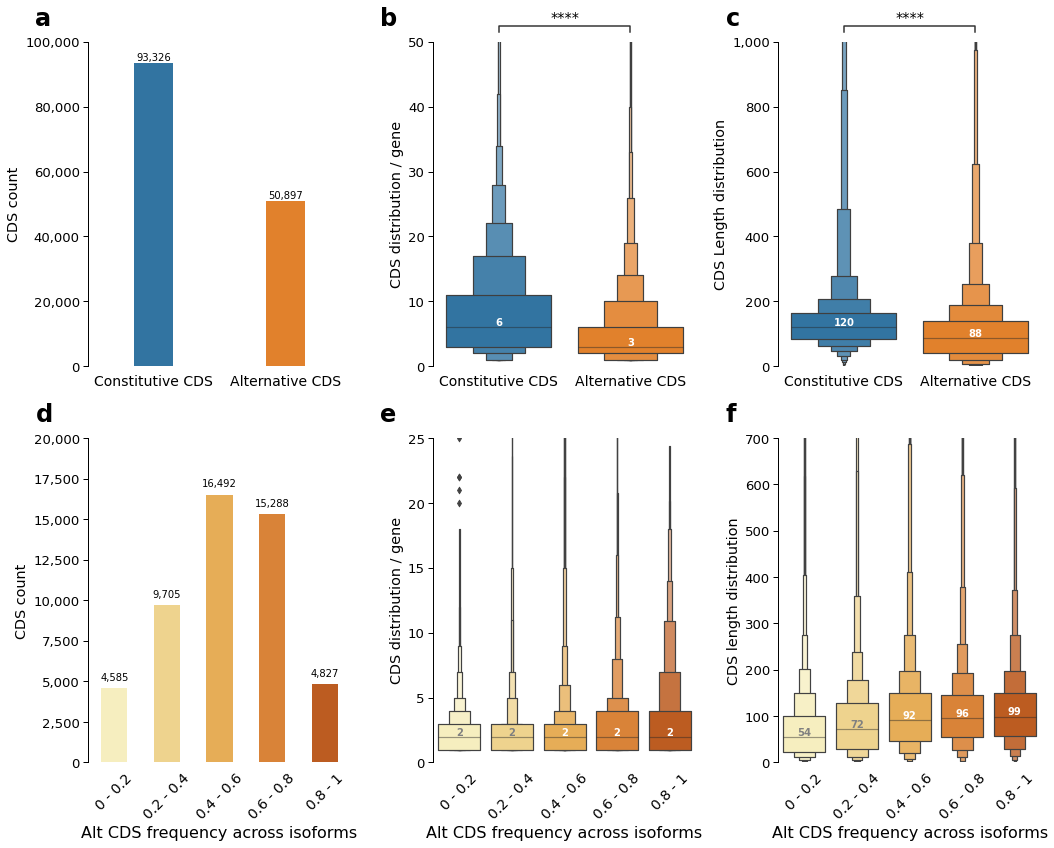

In [261]:
def show_values_on_bars(axs, i=0, fontsize=10, rotation=0, color='black', pad=10):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width()/2 
            _y = p.get_y() + (p.get_height()) + pad
            if i == 0:
                value = "{:,.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color=color)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
fontsize_top_row_ticks = 14
fontsize_bottom_row_labels = 16
        
sns.set_context('paper', font_scale=1.5)
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12))
t = refseq.groupby('Const_Alt').size().reset_index()
f1 = sns.barplot(data=t.sort_values(by='Const_Alt', ascending=False), x='Const_Alt', y=0, ax=ax[0][0], palette=sns.color_palette("tab10"), )
widthbars = [0.3, 0.3]
for bar, newwidth in zip(f1.patches, widthbars):
    x = bar.get_x()
    width = bar.get_width()
    centre = x + width/2.
    bar.set_x(centre - newwidth/2.)
    bar.set_width(newwidth)
    
f1.set_ylim(0, 100000)
ax[0][0].spines['bottom'].set_linewidth(0)
ax[0][0].spines['right'].set_linewidth(0)
ax[0][0].spines['top'].set_linewidth(0)
ax[0][0].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[0][0].set_xlabel('')
ax[0][0].set_ylabel('CDS count')
ax[0][0].set_xticklabels(['Constitutive CDS', 'Alternative CDS'], fontsize=fontsize_top_row_ticks)
ax[0][0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
show_values_on_bars(ax[0][0], i=0, pad=1000)

f2 = sns.boxenplot(data=refseq[['Const_Alt', 'Length']], x='Const_Alt', y='Length', ax=ax[0][2])

medians = refseq[['Const_Alt', 'Length']].groupby(['Const_Alt'])['Length'].median().sort_index(ascending=False)
vertical_offset = exotic['Length'].median() * 0.05 # offset from median for display


for xtick in f2.get_xticks():
    f2.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')


ax[0][2].spines['bottom'].set_linewidth(0)
ax[0][2].spines['right'].set_linewidth(0)
ax[0][2].spines['top'].set_linewidth(0)
ax[0][2].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[0][2].set_xlabel('')
ax[0][2].set_ylabel('CDS Length distribution')
ax[0][2].set_xticklabels(['Constitutive CDS', 'Alternative CDS'], fontsize=fontsize_top_row_ticks)
ax[0][2].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


f2.set_ylim(0, 1000)

t = refseq[['Gene', 'Const_Alt']].groupby(['Gene', 'Const_Alt']).size().reset_index()
t = t.sort_values(by='Const_Alt', ascending=False)
t

f3 = sns.boxenplot(data=t, x='Const_Alt', y=0, ax=ax[0][1])

medians = refseq[['Const_Alt', 'Gene']].groupby(['Gene', 'Const_Alt']).size().reset_index().pivot(columns='Const_Alt', values=0, index='Gene').median().sort_index(ascending=False)
vertical_offset = refseq[['Const_Alt', 'Gene']].groupby(['Gene', 'Const_Alt']).size().reset_index().median() * 0.05 # offset from median for display
vertical_offset

for xtick in f3.get_xticks():
    f3.text(xtick,medians[xtick] + vertical_offset,int(medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')



ax[0][1].spines['bottom'].set_linewidth(0)
ax[0][1].spines['right'].set_linewidth(0)
ax[0][1].spines['top'].set_linewidth(0)
ax[0][1].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[0][1].set_xlabel('')
ax[0][1].set_ylabel('CDS distribution / gene')
ax[0][1].set_xticklabels(['Constitutive CDS', 'Alternative CDS'], fontsize=fontsize_top_row_ticks)

f3.set_ylim(0, 50)

t = refseq.loc[refseq['Const_Alt'] == 'Alt', ['Ratio_num_bins']].groupby('Ratio_num_bins').size().reset_index()
t = t.sort_values(by='Ratio_num_bins', ascending=False)
f4 = sns.barplot(data=t, x='Ratio_num_bins', y=0, ax=ax[1][0], palette=sns.color_palette("YlOrBr"))
widthbars = [0.5, 0.5, 0.5, 0.5, 0.5]
for bar, newwidth in zip(f4.patches, widthbars):
    x = bar.get_x()
    width = bar.get_width()
    centre = x + width/2.
    bar.set_x(centre - newwidth/2.)
    bar.set_width(newwidth)
    
ax[1][0].spines['bottom'].set_linewidth(0)
ax[1][0].spines['right'].set_linewidth(0)
ax[1][0].spines['top'].set_linewidth(0)
ax[1][0].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[1][0].set_xlabel('Alt CDS frequency across isoforms', fontsize=fontsize_bottom_row_labels)
ax[1][0].set_ylabel('CDS count')
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), fontsize=fontsize_top_row_ticks, rotation=45)
ax[1][0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

f4.set_ylim(0, 20000)
show_values_on_bars(ax[1][0], i=0, pad=500)



t = refseq.loc[refseq['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index()
t = t.sort_values(by='Ratio_num_bins', ascending=False)
f5 = sns.boxenplot(data=t, x='Ratio_num_bins', y=0, ax=ax[1][1], palette=sns.color_palette("YlOrBr"))

medians = refseq.loc[refseq['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index().pivot(columns='Ratio_num_bins', values=0, index='Gene').median().sort_index(ascending=False)
vertical_offset = refseq.loc[refseq['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index().median() * 0.05 # offset from median for display
vertical_offset

for j, xtick in enumerate(f5.get_xticks()):
    if j <2:
        color='grey'
    else:
        color='w'
    f5.text(xtick,medians[xtick] + vertical_offset,int(medians[xtick]), 
            horizontalalignment='center',size='x-small',color=color,weight='semibold')



ax[1][1].spines['bottom'].set_linewidth(0)
ax[1][1].spines['right'].set_linewidth(0)
ax[1][1].spines['top'].set_linewidth(0)
ax[1][1].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[1][1].set_xlabel('Alt CDS frequency across isoforms', fontsize=fontsize_bottom_row_labels)
ax[1][1].set_ylabel('CDS distribution / gene')
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), fontsize=fontsize_top_row_ticks, rotation=45)
f5.set_ylim(0, 25)



t = refseq.loc[refseq['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins', 'Length']]
t = t.sort_values(by='Ratio_num_bins', ascending=False)
f6 = sns.boxenplot(data=t, x='Ratio_num_bins', y='Length', ax=ax[1][2], palette=sns.color_palette("YlOrBr"))


medians =refseq.loc[refseq['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins', 'Length']].groupby(['Ratio_num_bins'])['Length'].median().sort_index(ascending=False)
vertical_offset = refseq.loc[refseq['Const_Alt'] == 'Alt', ['Length']].median() * 0.05 # offset from median for display


for j, xtick in enumerate(f6.get_xticks()):
    if j <2:
        color='grey'
    else:
        color='w'
    f6.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color=color,weight='semibold')

ax[1][2].spines['bottom'].set_linewidth(0)
ax[1][2].spines['right'].set_linewidth(0)
ax[1][2].spines['top'].set_linewidth(0)
ax[1][2].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[1][2].set_xlabel('Alt CDS frequency across isoforms', fontsize=fontsize_bottom_row_labels)
ax[1][2].set_ylabel('CDS length distribution')
ax[1][2].set_xticklabels(ax[1][2].get_xticklabels(), fontsize=fontsize_top_row_ticks, rotation=45)
f6.set_ylim(0, 700)

axs = ax.flat
import string

for n, a in enumerate(axs):
    a.text(-0.2, 1.05, string.ascii_lowercase[n], transform=a.transAxes, size=24, weight='bold')

plt.tight_layout()
add_stat_annotation(f2, data=refseq, x='Const_Alt', y='Length', order= ['Const', 'Alt'],
                    box_pairs=[('Const', 'Alt')],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

t = refseq[['Gene', 'Const_Alt']].groupby(['Gene', 'Const_Alt']).size().reset_index()

add_stat_annotation(f3, data=t, x='Const_Alt', y=0, order= ['Const', 'Alt'],
                    box_pairs=[('Const', 'Alt')],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

# t = refseq.loc[refseq['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index()
# add_stat_annotation(f6, data=t, x='Ratio_num_bins', y=0, order= t.Ratio_num_bins.cat.categories,
#                     box_pairs=[('0 - 0.2', '0.8 - 1'), ('0 - 0.2', '0.2 - 0.4')],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=2)


In [821]:
def show_values_on_bars(axs, i=0, fontsize=10, rotation=0, color='black'):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            _y = (p.get_height() / 2) - 0.01
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, str(round(float(value) + 1, i)), ha="center", fontsize=fontsize, rotation=rotation, color=color)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [4]:
tmp_ccrs_path = '/home/weber/PycharmProjects/ExoCarto/data/2_processed/CCRS_modified.parquet'
merge_df = pd.read_parquet(tmp_ccrs_path)
# merge_df = merge_df.loc[merge_df['CCRS_CCR_percentile'] > 0]

In [292]:
bins = [0, 20, 80, 90, 95, 99, 100]
labels = bins.copy()
labels_ratio = [str(round(labels[j], 1)) + " - " + str(round(labels[j + 1], 1)) for j in range(len(labels) - 1)]
merge_df["CCRS_bins"] = pd.cut(merge_df["CCRS_CCR_percentile"], bins=bins, labels=labels_ratio, include_lowest=True)
merge_df[['Start' , 'Stop']] = merge_df.ranges.str.split('-', expand=True)
merge_df['Start'] = merge_df['Start'].astype(int)
merge_df['Stop'] = merge_df['Stop'].astype(int)
merge_df['Length'] = merge_df['Stop'] - merge_df['Start']
merge_df

,Gene,RefSeq_Chrom,CCRS_ranges,CCRS_Start,CCRS_End,CCRS_CCR_percentile,Missing_coverage_bp,Gap_with_previous_CCRS,ranges,Ratio_num,Const_Alt,Ratio_num_bins,CCRS_bins,Start,Stop,Length
0,A2M,12,9220421-9220435,9220421,9220435,94.960308,0.0,None,9220419-9220435,1.0,Const,0.8 - 1,90 - 95,9220419,9220435,16
1,A2M,12,9220792-9220793,9220792,9220793,0.000000,0.0,None,9220779-9220820,1.0,Const,0.8 - 1,0 - 20,9220779,9220820,41
2,A2M,12,9220793-9220810,9220793,9220810,72.870475,0.0,None,9220779-9220820,1.0,Const,0.8 - 1,20 - 80,9220779,9220820,41
3,A2M,12,9220810-9220811,9220810,9220811,0.000000,0.0,None,9220779-9220820,1.0,Const,0.8 - 1,0 - 20,9220779,9220820,41
4,A2M,12,9220811-9220820,9220811,9220820,96.319079,0.0,None,9220779-9220820,1.0,Const,0.8 - 1,95 - 99,9220779,9220820,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736256,ZXDC,3,126194500-126194505,126194500,126194505,0.204138,0.0,None,126193802-126194708,1.0,Const,0.8 - 1,0 - 20,126193802,126194708,906
2736257,ZXDC,3,126194505-126194506,126194505,126194506,0.000000,0.0,None,126193802-126194708,1.0,Const,0.8 - 1,0 - 20,126193802,126194708,906
2736258,ZXDC,3,126194506-126194508,126194506,126194508,2.763944,0.0,None,126193802-126194708,1.0,Const,0.8 - 1,0 - 20,126193802,126194708,906
2736259,ZXDC,3,126194508-126194509,126194508,126194509,0.000000,0.0,None,126193802-126194708,1.0,Const,0.8 - 1,0 - 20,126193802,126194708,906


In [571]:
test

{'Alt': {'0 - 20': 488608942,
  '20 - 80': 117245627,
  '80 - 90': 5205306,
  '90 - 95': 1418328,
  '95 - 99': 465994,
  '99 - 100': 28615},
 'Const': {'0 - 20': 1292474310,
  '20 - 80': 323467054,
  '80 - 90': 15974207,
  '90 - 95': 4856048,
  '95 - 99': 1913264,
  '99 - 100': 170381}}

In [575]:
test = merge_df[['CCRS_bins', 'Const_Alt', 'Length']].groupby(['CCRS_bins', 'Const_Alt',]).sum().reset_index().pivot(index='CCRS_bins', columns='Const_Alt', values='Length').to_dict()
# test
t_l = list()
odr_l = list()
se_l = list()
low_cis = list()
up_cis = list()

for key in test['Alt']:
    print(key)
    sum_others_alt = sum([test['Alt'][k] for k in test['Alt'] if key != k])
    sum_others_const = sum([test['Const'][k] for k in test['Alt'] if key != k])
    odr = ((test['Const'][key]) / (test['Alt'][key])) / ((sum_others_const / sum_others_alt))
    logodr = math.log((test['Const'][key] / sum_others_const) / (test['Alt'][key] / sum_others_alt))
    se = math.sqrt((1/test['Const'][key]) + (1/test['Alt'][key]) + (1/sum_others_const) + (1/sum_others_alt))
    low_ci = math.exp(logodr - (1.96 * se))
    low_cis.append(low_ci)
    up_ci = math.exp(logodr + (1.96 * se))
    ttest2 = stats.mannwhitneyu(list(test['Const'].values()), list(test['Alt'].values()))
    ttest = stats.ttest_ind([test['Const'][key], sum_others_const], [test['Alt'][key], sum_others_alt])
    print(test['Const'][key], test['Alt'][key], sum_others_const, sum_others_alt, odr, low_ci, up_ci, ttest, ttest2)


    up_cis.append(up_ci)
    odr_l.append(odr-1)
    se_l.append(se)    

0 - 20
1292474310 488608942 346380954 124363870 0.9497312601975889 0.949513022065041 0.9499495484904626 Ttest_indResult(statistic=1.0119294685068128, pvalue=0.4180853912793856) MannwhitneyuResult(statistic=14.0, pvalue=0.28758676596009836)
20 - 80
323467054 117245627 1315388210 495727185 1.0397338672557517 1.0394893669221368 1.0399784250987698 Ttest_indResult(statistic=0.966285833984505, pvalue=0.4358466816886084) MannwhitneyuResult(statistic=14.0, pvalue=0.28758676596009836)
80 - 90
15974207 5205306 1622881057 607767506 1.1492746536884229 1.148133329891531 1.150417112039966 Ttest_indResult(statistic=0.5977752534106368, pvalue=0.6106615848430839) MannwhitneyuResult(statistic=14.0, pvalue=0.28758676596009836)
90 - 95
4856048 1418328 1633999216 611554484 1.2814144152873745 1.2790165242153804 1.2838168019084761 Ttest_indResult(statistic=0.5897070663967634, pvalue=0.6151335994878309) MannwhitneyuResult(statistic=14.0, pvalue=0.28758676596009836)
95 - 99
1913264 465994 1636942000 612506818 

['0 - 20', '20 - 80', '80 - 90', '90 - 95', '95 - 99', '99 - 100']
[0 1 2 3 4 5]
[-0.05026873980241109, 0.039733867255751676, 0.14927465368842285, 0.28141441528737454, 0.5362864869217578, 1.2271676155531703]
[0.9499495484904626, 1.0399784250987698, 1.150417112039966, 1.2838168019084761, 1.5412153830679072, 2.255232136213943]
[0.949513022065041, 1.0394893669221368, 1.148133329891531, 1.2790165242153804, 1.5313733536712328, 2.199452334913977]
[-0.05026873980241109, 0.039733867255751676, 0.14927465368842285, 0.28141441528737454, 0.5362864869217578, 1.2271676155531703]
[0.949513022065041, 1.0394893669221368, 1.148133329891531, 1.2790165242153804, 1.5313733536712328, 2.199452334913977] [0.9499495484904626, 1.0399784250987698, 1.150417112039966, 1.2838168019084761, 1.5412153830679072, 2.255232136213943]
Rectangle(xy=(-0.4, 1), width=0.8, height=-0.0502687, angle=0)
Rectangle(xy=(0.6, 1), width=0.8, height=0.0397339, angle=0)
Rectangle(xy=(1.6, 1), width=0.8, height=0.149275, angle=0)
Rectang

Text(-0.25, 1.05, 'b')

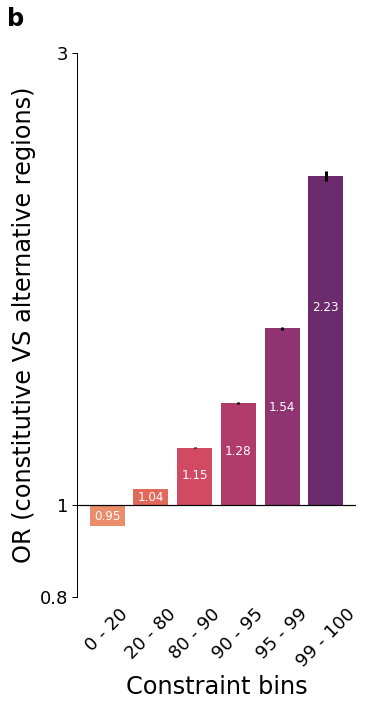

In [294]:
# Define labels, positions, bar heights and error bar heights
labels = labels_ratio
x_pos = np.arange(len(labels))
CTEs = odr_l
error = se_l

print(labels)
print(x_pos)
print(CTEs)
print(up_cis)
print(low_cis)


def show_values_on_bars(axs, i=0, fontsize=10, rotation=0, color='black', pad=1):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width()/2 
            _y = p.get_y() + (p.get_height() / 2) + pad
            if i == 0:
                value = "{:,.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, str(round(float(value) + 1, 2)), ha="center", fontsize=fontsize, rotation=rotation, color=color)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# Build the plot
sns.set_context('paper', font_scale=2.5)
fig, ax = plt.subplots(figsize=(5,10))
ax.set_axisbelow(True)
# ax.yaxis.grid(color='gray', zorder=0, linewidth=0.5)

# plt.rc('axes', axisbelow=True)
ax.set_xticklabels(labels)
ax.bar(x_pos, CTEs,
#        yerr=error,
       align='center',
#        alpha=0.5, 
       ecolor='black',
       capsize=10,
       color=sns.color_palette('flare'),
#        zorder=3,
       bottom=1,
      )

print(CTEs)
print(low_cis, up_cis)

[line.set_zorder(3) for line in ax.lines]
ax.set_xticks(x_pos)
# ax.set_yticks([x_pos])
ax.tick_params(axis='both', which='major', labelsize=14,)
ax.tick_params(axis='x', which='major', labelsize=18, rotation=45)
# plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: round(x+1, 2)))
show_values_on_bars(ax, i=2, fontsize=12, color='w', pad=-0.01)
plt.yscale('log')
plt.vlines(x_pos, low_cis, up_cis, lw=3)
ax.set_ylabel('OR (constitutive VS alternative regions)')
ax.set_xlabel('Constraint bins')
# plt.ylim(0.5, 2)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))

ax.minorticks_off()
ax.set_yticks([0.8, 1, 3])
ax.tick_params(axis='y', which='major', labelsize=18,)

ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
ax.axhline(1, color='black')
ax.text(-0.25, 1.05, 'b', transform=ax.transAxes, size=24, weight='bold')


In [67]:
test = merge_df[['CCRS_bins', 'Const_Alt', 'Length']].groupby(['CCRS_bins', 'Const_Alt',]).sum().reset_index().pivot(index='CCRS_bins', columns='Const_Alt', values='Length').to_dict()
# test
for key in test['Alt']:
    print(key)
    sum_others_alt = sum([test['Alt'][k] for k in test['Alt'] if key != k])
    sum_others_const = sum([test['Const'][k] for k in test['Alt'] if key != k])
    logodr = math.log((test['Const'][key] / sum_others_const) / (test['Alt'][key] / sum_others_alt))
    print(logodr)
print(test)


0 - 20
-0.051576218409315346
20 - 80
0.03896478353662113
80 - 90
0.13913100745446497
90 - 95
0.24796447979847633
95 - 99
0.4293681322567538
99 - 100
0.8007306506217413
{'Alt': {'0 - 20': 488608942, '20 - 80': 117245627, '80 - 90': 5205306, '90 - 95': 1418328, '95 - 99': 465994, '99 - 100': 28615}, 'Const': {'0 - 20': 1292474310, '20 - 80': 323467054, '80 - 90': 15974207, '90 - 95': 4856048, '95 - 99': 1913264, '99 - 100': 170381}}


In [517]:
merge_df

,Gene,RefSeq_Chrom,CCRS_ranges,CCRS_Start,CCRS_End,CCRS_CCR_percentile,Missing_coverage_bp,Gap_with_previous_CCRS,ranges,Ratio_num,Const_Alt,Ratio_num_bins,CCRS_bins,Start,Stop,Length
0,A2M,12,9220421-9220435,9220421,9220435,94.960308,0.0,None,9220419-9220435,1.0,Const,0.8 - 1,90 - 95,9220419,9220435,16
1,A2M,12,9220792-9220793,9220792,9220793,0.000000,0.0,None,9220779-9220820,1.0,Const,0.8 - 1,0 - 20,9220779,9220820,41
2,A2M,12,9220793-9220810,9220793,9220810,72.870475,0.0,None,9220779-9220820,1.0,Const,0.8 - 1,20 - 80,9220779,9220820,41
3,A2M,12,9220810-9220811,9220810,9220811,0.000000,0.0,None,9220779-9220820,1.0,Const,0.8 - 1,0 - 20,9220779,9220820,41
4,A2M,12,9220811-9220820,9220811,9220820,96.319079,0.0,None,9220779-9220820,1.0,Const,0.8 - 1,95 - 99,9220779,9220820,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736256,ZXDC,3,126194500-126194505,126194500,126194505,0.204138,0.0,None,126193802-126194708,1.0,Const,0.8 - 1,0 - 20,126193802,126194708,906
2736257,ZXDC,3,126194505-126194506,126194505,126194506,0.000000,0.0,None,126193802-126194708,1.0,Const,0.8 - 1,0 - 20,126193802,126194708,906
2736258,ZXDC,3,126194506-126194508,126194506,126194508,2.763944,0.0,None,126193802-126194708,1.0,Const,0.8 - 1,0 - 20,126193802,126194708,906
2736259,ZXDC,3,126194508-126194509,126194508,126194509,0.000000,0.0,None,126193802-126194708,1.0,Const,0.8 - 1,0 - 20,126193802,126194708,906


Text(0.5, 0, '')

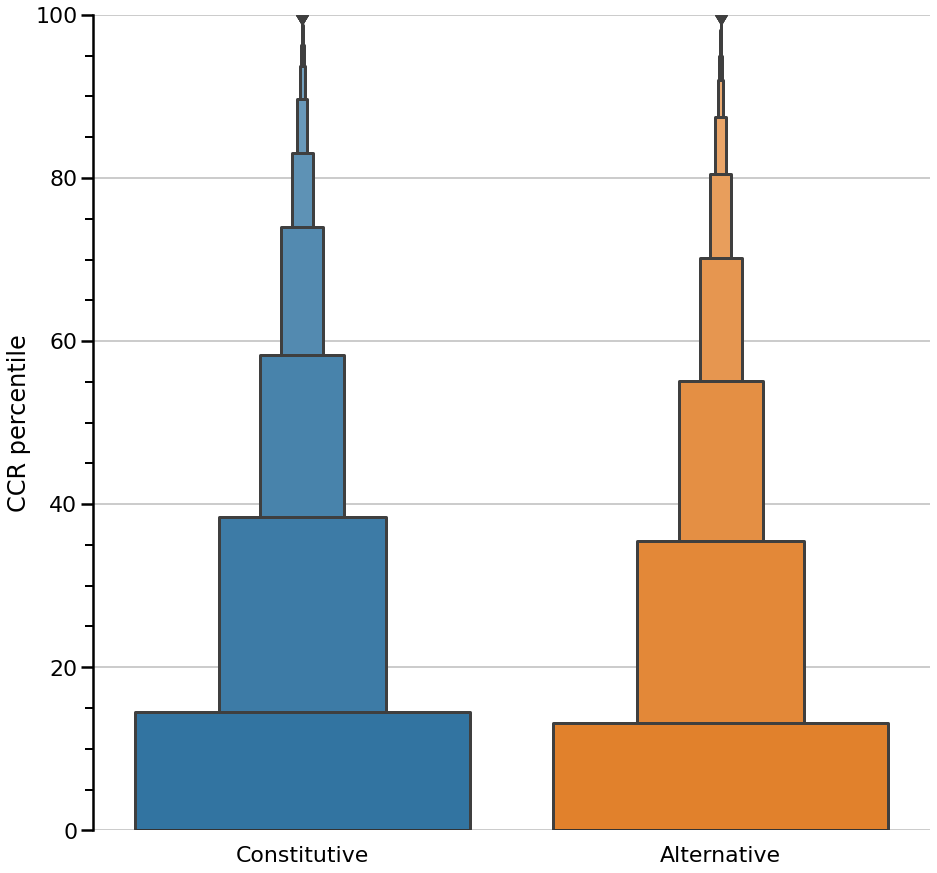

In [1233]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

f, ax = plt.subplots(figsize=(15,15))
sns.set_context('poster')
ax.set_axisbelow(True)

# Set axis ranges; by default this will put major ticks every 25.
ax.set_ylim(0, 100)

# Change major ticks to show every 20.
ax.yaxis.set_major_locator(MultipleLocator(20))

# Change minor ticks to show every 5. (20/4 = 5)
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='-')
# ax.grid(which='minor', color='#CCCCCC', linestyle=':')
sns.boxenplot(data=merge_df, x='Const_Alt', y='CCRS_CCR_percentile', ax=ax)
# plt.yscale('log')
# plt.ylim(bottom=0, top=100)
# plt.xlim(left=0, right=100)
ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)

ax.set_xticklabels(['Constitutive', 'Alternative'])
plt.ylabel('CCR percentile')
plt.xlabel('')
# legend = p.get_legend()
# legend.set_title('')
# legend.texts[0].set_text("Constitutive")
# legend.texts[1].set_text("Alternative")

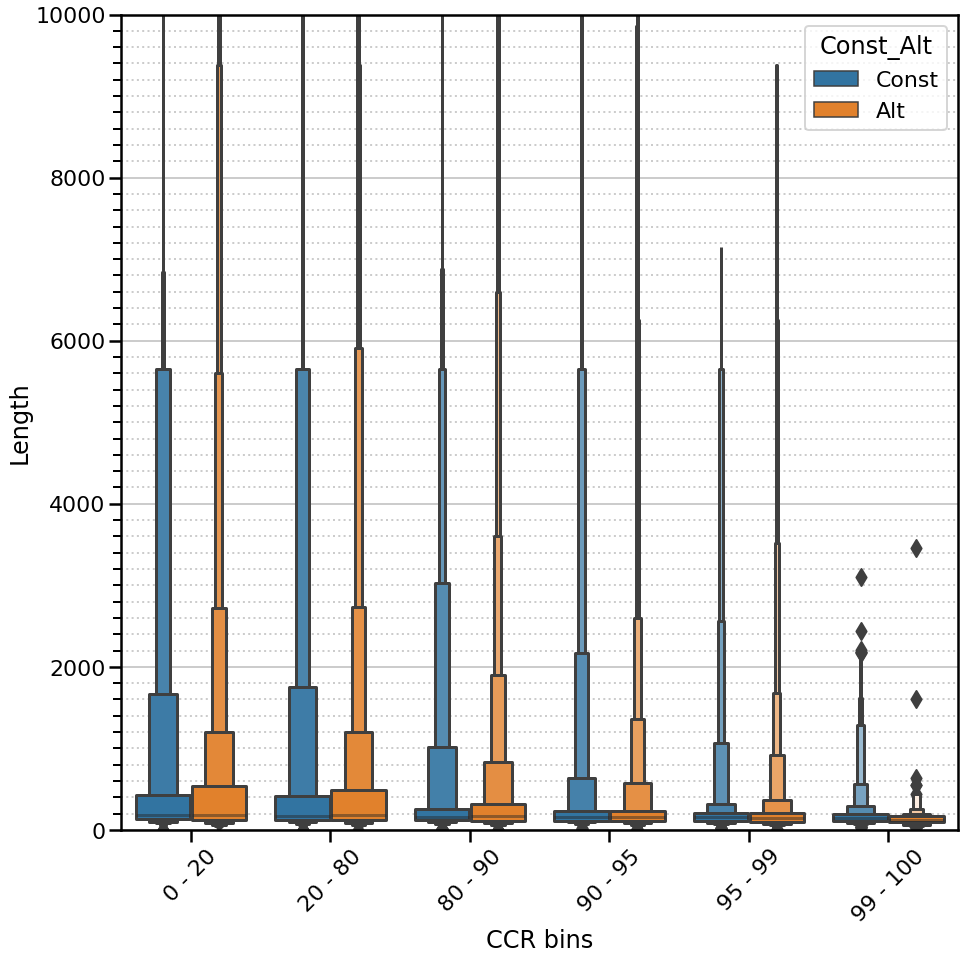

In [694]:
f, ax = plt.subplots(figsize=(15,15))
sns.set_context('poster',)
ax.set_axisbelow(True)
# Set axis ranges; by default this will put major ticks every 25.
ax.set_ylim(0, 100)

# Change major ticks to show every 20.
ax.yaxis.set_major_locator(MultipleLocator(2000))

# Change minor ticks to show every 5. (20/4 = 5)
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='-')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

sns.boxenplot(data=merge_df, x='CCRS_bins', y='Length', hue='Const_Alt', ax=ax)
# plt.yscale('log')
plt.ylim(bottom=0, top=10000)


plt.xticks(rotation=45)
plt.xlabel('CCR bins')
legend = p.get_legend()
legend.set_title('')
legend.texts[0].set_text("Constitutive")
legend.texts[1].set_text("Alternative")
# plt.xlim(left=0, right=100)

AxesSubplot(0.125,0.125;0.775x0.755)


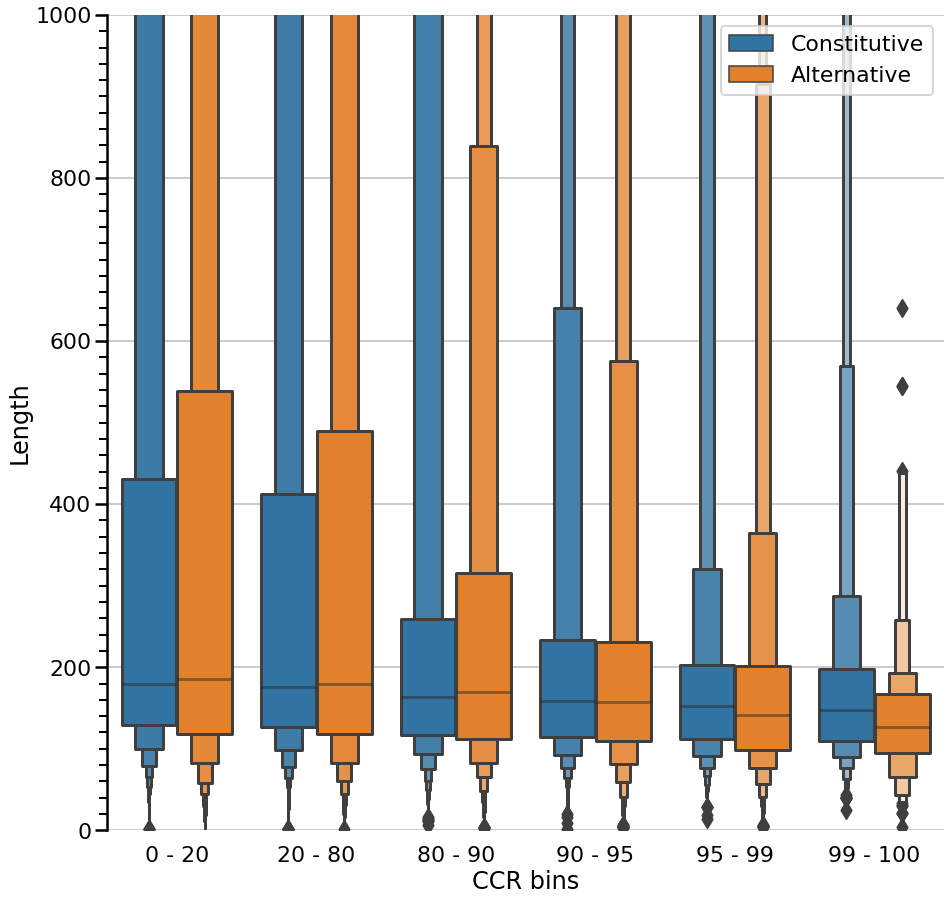

In [1238]:
f, ax = plt.subplots(figsize=(15,15))
sns.set_context('poster')
ax.set_axisbelow(True)
# Set axis ranges; by default this will put major ticks every 25.
ax.set_ylim(0, 100)

# Change major ticks to show every 20.
ax.yaxis.set_major_locator(MultipleLocator(200))

# Change minor ticks to show every 5. (20/4 = 5)
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='-')
# ax.grid(which='minor', color='#CCCCCC', linestyle=':')

p = sns.boxenplot(data=merge_df, x='CCRS_bins', y='Length', hue='Const_Alt', ax=ax)
# plt.yscale('log')
plt.ylim(bottom=0, top=1000)
ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)

# plt.xticks(rotation=45)
plt.xlabel('CCR bins')
legend = p.get_legend()
legend.set_title('')
legend.texts[0].set_text("Constitutive")
legend.texts[1].set_text("Alternative")
print(p)
# plt.xlim(left=0, right=100)

In [1319]:
merge_df

,Gene,RefSeq_Chrom,CCRS_ranges,CCRS_Start,CCRS_End,CCRS_CCR_percentile,Missing_coverage_bp,Gap_with_previous_CCRS,ranges,Ratio_num,Const_Alt,Ratio_num_bins,CCRS_bins,Start,Stop,Length
0,A2M,12,9220421-9220435,9220421,9220435,94.960308,0.0,None,9220419-9220435,1.0,Const,0.8 - 1,90 - 95,9220419,9220435,16
1,A2M,12,9220792-9220793,9220792,9220793,0.000000,0.0,None,9220779-9220820,1.0,Const,0.8 - 1,0 - 20,9220779,9220820,41
2,A2M,12,9220793-9220810,9220793,9220810,72.870475,0.0,None,9220779-9220820,1.0,Const,0.8 - 1,20 - 80,9220779,9220820,41
3,A2M,12,9220810-9220811,9220810,9220811,0.000000,0.0,None,9220779-9220820,1.0,Const,0.8 - 1,0 - 20,9220779,9220820,41
4,A2M,12,9220811-9220820,9220811,9220820,96.319079,0.0,None,9220779-9220820,1.0,Const,0.8 - 1,95 - 99,9220779,9220820,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736256,ZXDC,3,126194500-126194505,126194500,126194505,0.204138,0.0,None,126193802-126194708,1.0,Const,0.8 - 1,0 - 20,126193802,126194708,906
2736257,ZXDC,3,126194505-126194506,126194505,126194506,0.000000,0.0,None,126193802-126194708,1.0,Const,0.8 - 1,0 - 20,126193802,126194708,906
2736258,ZXDC,3,126194506-126194508,126194506,126194508,2.763944,0.0,None,126193802-126194708,1.0,Const,0.8 - 1,0 - 20,126193802,126194708,906
2736259,ZXDC,3,126194508-126194509,126194508,126194509,0.000000,0.0,None,126193802-126194708,1.0,Const,0.8 - 1,0 - 20,126193802,126194708,906


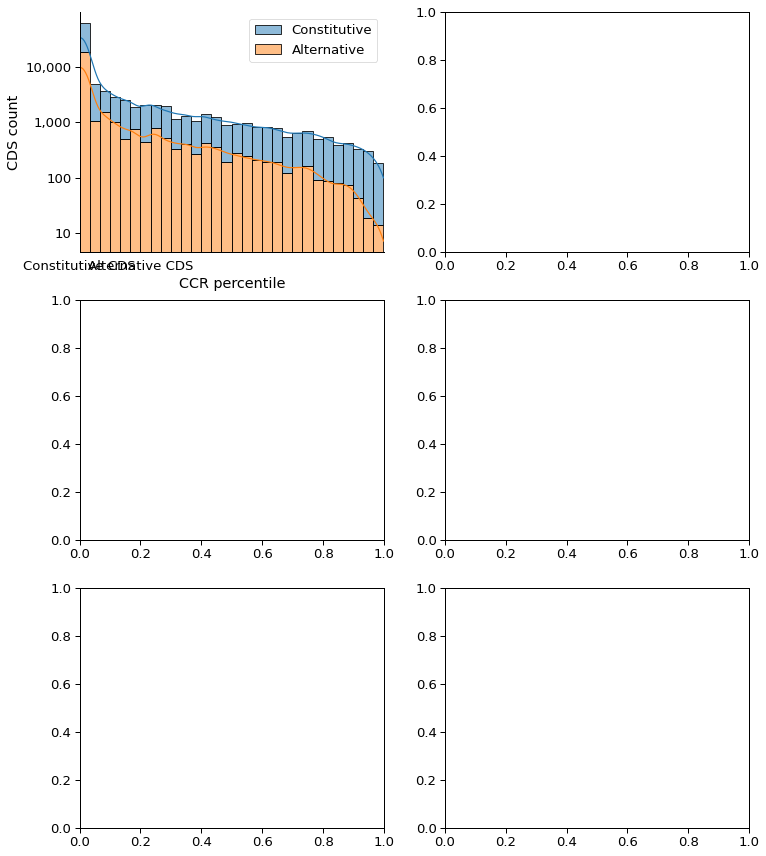

In [295]:
def show_values_on_bars(axs, i=0, fontsize=10, rotation=0, color='black', pad=10):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width()/2 
            _y = p.get_y() + (p.get_height()) + pad
            if i == 0:
                value = "{:,.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color=color)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
fontsize_top_row_ticks = 14
fontsize_bottom_row_labels = 16
        
sns.set_context('paper', font_scale=1.5)
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,15))
# plt.grid(True, axis='y')
f1 = sns.histplot(data=merge_df.head(100000), x='CCRS_CCR_percentile', hue='Const_Alt', multiple="stack", bins=30, kde=True, ax=ax[0][0])
ax[0][0].set_yscale('log')
ax[0][0].set_xlim(left=0, right=100)
# ax[0][0].set_ylim(bottom=1)
# ax.spines['bottom'].set_linewidth(0)
# plt.tick_params(axis = "x", which = "both", bottom = False, top = False)

# plt.ylabel('CCR count')
legend = f1.get_legend()
legend.set_title('')
legend.texts[0].set_text("Constitutive")
legend.texts[1].set_text("Alternative")



ax[0][0].minorticks_off()
ax[0][0].spines['right'].set_linewidth(0)
ax[0][0].spines['top'].set_linewidth(0)
ax[0][0].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[0][0].set_xlabel('CCR percentile')
ax[0][0].set_ylabel('CDS count')
ax[0][0].set_xticklabels(['Constitutive CDS', 'Alternative CDS'], )
ax[0][0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# show_values_on_bars(ax[0][0], i=0, pad=1000)


Text(-0.15, 1.05, 'a')

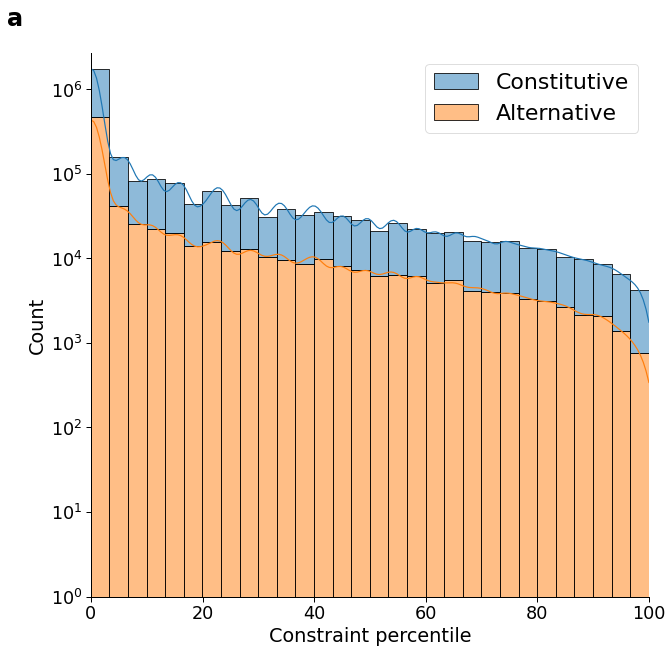

In [282]:

f, ax = plt.subplots(figsize=(10,10))
sns.set_context('paper', font_scale=2.5)
ax.set_axisbelow(True)

# plt.grid(True, axis='y')
p = sns.histplot(merge_df, x='CCRS_CCR_percentile', hue='Const_Alt', multiple="stack", bins=30, kde=True, ax=ax,)
plt.yscale('log')

plt.ylim(bottom=1)
plt.xlim(left=0, right=100)
# ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.minorticks_off()
# plt.tick_params(axis = "x", which = "both", bottom = False, top = False)

# plt.ylabel('CCR count')
plt.xlabel('Constraint percentile')
legend = p.get_legend()
legend.set_title('')
legend.texts[0].set_text("Constitutive")
legend.texts[1].set_text("Alternative")
ax.text(-0.15, 1.05, 'a', transform=ax.transAxes, size=24, weight='bold')


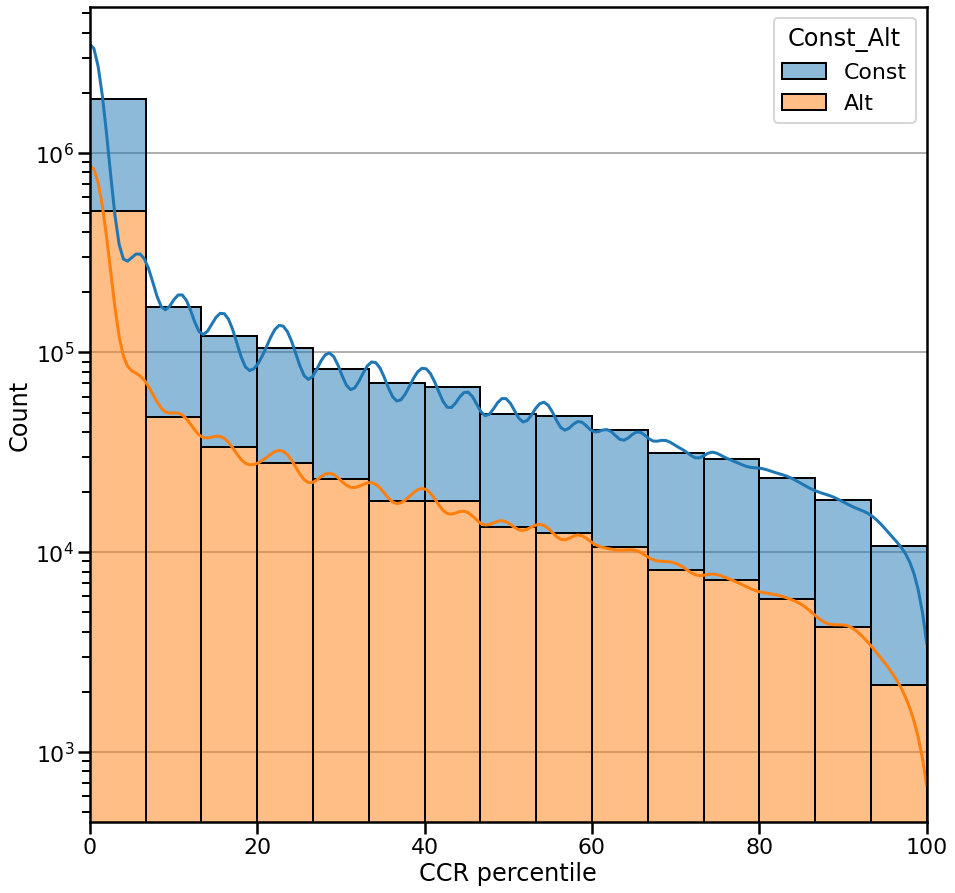

In [689]:

f, ax = plt.subplots(figsize=(15,15))
sns.set_context('poster')
ax.set_axisbelow(True)

plt.grid(True, axis='y')
sns.histplot(merge_df, x='CCRS_CCR_percentile', hue='Const_Alt', multiple="stack", kde=True, bins=15, ax=ax)
plt.yscale('log')
plt.xlim(left=0, right=100)

plt.xlabel('CCR percentile')
legend = p.get_legend()
legend.set_title('')
legend.texts[0].set_text("Constitutive")
legend.texts[1].set_text("Alternative")

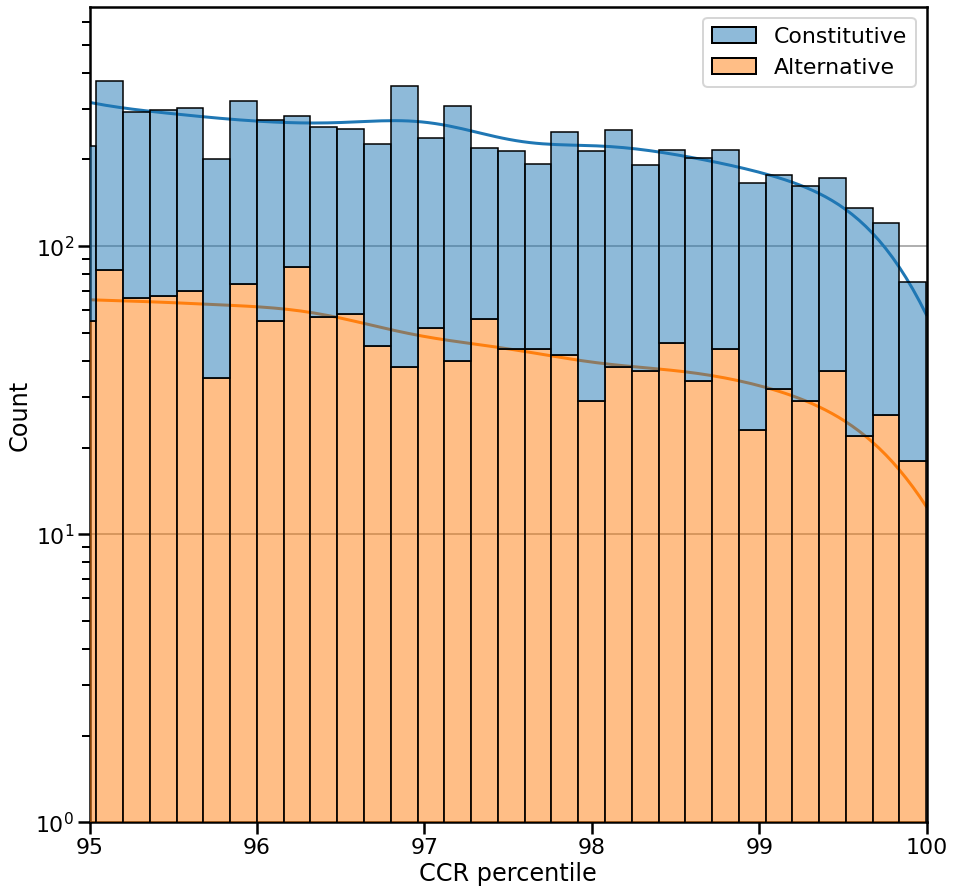

In [688]:

f, ax = plt.subplots(figsize=(15,15))
sns.set_context('poster')
# ax.set_axisbelow(True)

p = sns.histplot(merge_df.loc[merge_df['CCRS_CCR_percentile'] > 92], x='CCRS_CCR_percentile', hue='Const_Alt', multiple="stack", kde=True, bins=50, ax=ax, zorder=3)
ax.grid(True, axis='y', zorder=0)

plt.yscale('log')
plt.ylim(bottom=1)

plt.xlim(left=95, right=100)

plt.xlabel('CCR percentile')
legend = p.get_legend()
legend.set_title('')
legend.texts[0].set_text("Constitutive")
legend.texts[1].set_text("Alternative")

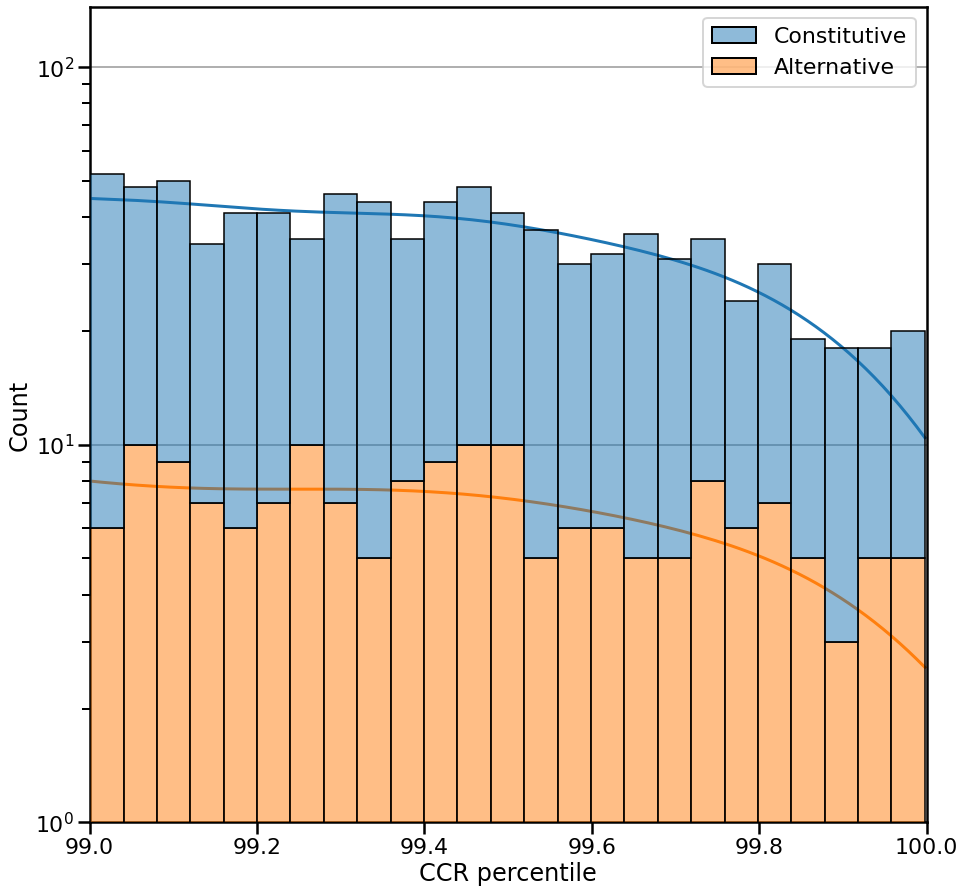

In [683]:

f, ax = plt.subplots(figsize=(15,15))
sns.set_context('poster')
# ax.set_axisbelow(True)

p = sns.histplot(merge_df.loc[merge_df['CCRS_CCR_percentile'] > 98], x='CCRS_CCR_percentile', hue='Const_Alt', multiple="stack", kde=True, bins=50, ax=ax, zorder=3, legend=True)
ax.grid(True, axis='y', zorder=0)

plt.yscale('log')
plt.ylim(bottom=1)

plt.xlim(left=99, right=100)

plt.xlabel('CCR percentile')
legend = p.get_legend()
legend.set_title('')
legend.texts[0].set_text("Constitutive")
legend.texts[1].set_text("Alternative")

# print(legend)

In [6]:
tmp_variants_path = '/home/weber/PycharmProjects/ExoCarto/data/2_processed/ClinVar_modified.parquet'
merge_df_variants = pd.read_parquet(tmp_variants_path)
merge_df_variants = merge_df_variants.loc[merge_df_variants['Status'] != 'Other']
merge_df_variants
# merge_df = merge_df.loc[merge_df['CCRS_CCR_percentile'] > 0]

,Gene,VAR_ID,MC,Status,Real_Status,RS_STARS,CLNREVSTAT,HPO,rs,alleleid,POS,ranges,Ratio_num,Const_Alt,Ratio_num_bins
0,A1CF,10_52573772_C_['T'],missense_variant,Benign,Likely_benign,1,"criteria_provided,_single_submitter",[],41274050,712394,52573772,52573617-52573798,1.0,Const,0.8 - 1
1,A1CF,10_52573797_C_['T'],synonymous_variant,Benign,Likely_benign,1,"criteria_provided,_single_submitter",[],924638663,767784,52573797,52573617-52573798,1.0,Const,0.8 - 1
2,A1CF,10_52576025_G_['A'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],142026324,701372,52576025,52575766-52576039,1.0,Const,0.8 - 1
3,A1CF,10_52595853_C_['T'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],61742973,712395,52595853,52595834-52596072,1.0,Const,0.8 - 1
4,A1CF,10_52603754_A_['G'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],35967725,712396,52603754,52603748-52603882,1.0,Const,0.8 - 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477394,ZYX,7_143085922_G_['A'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],75965463,710836,143085922,143085860-143086038,1.0,Const,0.8 - 1
477395,ZYX,7_143085922_G_['A'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],75965463,710836,143085922,143085860-143086038,1.0,Const,0.8 - 1
477396,ZYX,7_143085985_C_['T'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],142288548,736003,143085985,143085860-143086038,1.0,Const,0.8 - 1
477397,ZYX,7_143085985_C_['T'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],142288548,736003,143085985,143085860-143086038,1.0,Const,0.8 - 1


In [489]:
tmp_variants_path2 = '/gstock/EXOTIC/data/VARIATIONS/ClinVar_gnomAD.parquet'
merge_df_variants = pd.read_parquet(tmp_variants_path2)
merge_df_variants = merge_df_variants.loc[merge_df_variants['Status'] != 'Other']
merge_df_variants
# merge_df = merge_df.loc[merge_df['CCRS_CCR_percentile'] > 0]

,ALT,CHROM,CLNREVSTAT,Gene,HPO,ID,MC,POS,REF,RS_STARS,Real_Status,Status,VAR_ID,alleleid,ranges,rs,Ratio_num,Const_Alt,Ratio_num_bins
0,T,10,None,A1CF,None,10_52566500_C_T,None,52566500.0,C,NaN,None,Benign,None,NaN,52566489-52566640,None,1.0,Const,0.8 - 1
1,A,10,None,A1CF,None,10_52566502_T_A,None,52566502.0,T,NaN,None,Benign,None,NaN,52566489-52566640,None,1.0,Const,0.8 - 1
2,T,10,None,A1CF,None,10_52566505_C_T,None,52566505.0,C,NaN,None,Benign,None,NaN,52566489-52566640,None,1.0,Const,0.8 - 1
3,A,10,None,A1CF,None,10_52566508_T_A,None,52566508.0,T,NaN,None,Benign,None,NaN,52566489-52566640,None,1.0,Const,0.8 - 1
4,T,10,None,A1CF,None,10_52566514_C_T,None,52566514.0,C,NaN,None,Benign,None,NaN,52566489-52566640,None,1.0,Const,0.8 - 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805124,T,7,None,ZYX,None,7_143087743_C_T,None,143087743.0,C,NaN,None,Benign,None,NaN,143087671-143087775,None,1.0,Const,0.8 - 1
1805125,A,7,None,ZYX,None,7_143087744_G_A,None,143087744.0,G,NaN,None,Benign,None,NaN,143087671-143087775,None,1.0,Const,0.8 - 1
1805126,A,7,None,ZYX,None,7_143087744_G_A,None,143087744.0,G,NaN,None,Benign,None,NaN,143087671-143087775,None,1.0,Const,0.8 - 1
1805127,A,7,None,ZYX,None,7_143087764_G_A,None,143087764.0,G,NaN,None,Benign,None,NaN,143087671-143087775,None,1.0,Const,0.8 - 1


In [490]:
merge_df_variants[['CHROM', 'POS', 'REF', 'ALT']] = merge_df_variants.VAR_ID.str.split('_', expand=True)
merge_df_variants['ALT'] = merge_df_variants['ALT'].str.replace("\['", "")
merge_df_variants['ALT'] = merge_df_variants['ALT'].str.replace("']", "")
merge_df_variants['ID'] = merge_df_variants['CHROM'].astype(str) + '_' + merge_df_variants['POS'].astype(str) + '_' + merge_df_variants['REF'].astype(str) + '_' + merge_df_variants['ALT'].astype(str)
merge_df_variants

,ALT,CHROM,CLNREVSTAT,Gene,HPO,ID,MC,POS,REF,RS_STARS,Real_Status,Status,VAR_ID,alleleid,ranges,rs,Ratio_num,Const_Alt,Ratio_num_bins
0,None,None,None,A1CF,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,52566489-52566640,None,1.0,Const,0.8 - 1
1,None,None,None,A1CF,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,52566489-52566640,None,1.0,Const,0.8 - 1
2,None,None,None,A1CF,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,52566489-52566640,None,1.0,Const,0.8 - 1
3,None,None,None,A1CF,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,52566489-52566640,None,1.0,Const,0.8 - 1
4,None,None,None,A1CF,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,52566489-52566640,None,1.0,Const,0.8 - 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805124,None,None,None,ZYX,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,143087671-143087775,None,1.0,Const,0.8 - 1
1805125,None,None,None,ZYX,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,143087671-143087775,None,1.0,Const,0.8 - 1
1805126,None,None,None,ZYX,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,143087671-143087775,None,1.0,Const,0.8 - 1
1805127,None,None,None,ZYX,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,143087671-143087775,None,1.0,Const,0.8 - 1


In [129]:
gnomad_clinvar_genes = pd.read_csv('/gstock/biolo_datasets/variation/variation_sets/gnomAD/EXOME_MISTIC/FULL_FILTERING/gnomad_clinvar_genes.csv.gz', compression='gzip', sep='\t')
gnomad_clinvar_genes

,Gene,ID
0,PLEKHN1,1_901919_A_C
1,PLEKHN1,1_901922_G_C
2,PLEKHN1,1_901922_G_A
3,PLEKHN1,1_901923_C_A
4,PLEKHN1,1_901937_A_G
...,...,...
951014,NLGN4Y,Y_16952855_A_G
951015,NLGN4Y,Y_16952991_C_T
951016,NLGN4Y,Y_16953018_C_T
951017,NLGN4Y,Y_16953062_C_T


In [477]:
merge_df_variants

,Gene,VAR_ID,MC,Status,Real_Status,RS_STARS,CLNREVSTAT,HPO,rs,alleleid,POS,ranges,Ratio_num,Const_Alt,Ratio_num_bins,CHROM,REF,ALT,ID,_merge
1,A1CF,10_52573797_C_T,synonymous_variant,Benign,Likely_benign,1.0,"criteria_provided,_single_submitter",[],924638663,767784.0,52573797,52573617-52573798,1.0,Const,0.8 - 1,10,C,T,10_52573797_C_T,left_only
2,A1CF,10_52576025_G_A,synonymous_variant,Benign,Benign,1.0,"criteria_provided,_single_submitter",[],142026324,701372.0,52576025,52575766-52576039,1.0,Const,0.8 - 1,10,G,A,10_52576025_G_A,left_only
3,A1CF,10_52595853_C_T,synonymous_variant,Benign,Benign,1.0,"criteria_provided,_single_submitter",[],61742973,712395.0,52595853,52595834-52596072,1.0,Const,0.8 - 1,10,C,T,10_52595853_C_T,left_only
4,A1CF,10_52603754_A_G,synonymous_variant,Benign,Benign,1.0,"criteria_provided,_single_submitter",[],35967725,712396.0,52603754,52603748-52603882,1.0,Const,0.8 - 1,10,A,G,10_52603754_A_G,left_only
5,A1CF,10_52603874_T_C,synonymous_variant,Benign,Benign,1.0,"criteria_provided,_single_submitter",[],142969066,712397.0,52603874,52603748-52603882,1.0,Const,0.8 - 1,10,T,C,10_52603874_T_C,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242943,ZYX,7_143085985_C_T,synonymous_variant,Benign,Benign,1.0,"criteria_provided,_single_submitter",[],142288548,736003.0,143085985,143085860-143086038,1.0,Const,0.8 - 1,7,C,T,7_143085985_C_T,left_only
242944,ZYX,7_143085985_C_T,synonymous_variant,Benign,Benign,1.0,"criteria_provided,_single_submitter",[],142288548,736003.0,143085985,143085860-143086038,1.0,Const,0.8 - 1,7,C,T,7_143085985_C_T,left_only
242945,ZYX,7_143085985_C_T,synonymous_variant,Benign,Benign,1.0,"criteria_provided,_single_submitter",[],142288548,736003.0,143085985,143085860-143086038,1.0,Const,0.8 - 1,7,C,T,7_143085985_C_T,left_only
242946,ZYX,7_143085985_C_T,synonymous_variant,Benign,Benign,1.0,"criteria_provided,_single_submitter",[],142288548,736003.0,143085985,143085860-143086038,1.0,Const,0.8 - 1,7,C,T,7_143085985_C_T,left_only


In [491]:
merge_df_variants = pd.merge(merge_df_variants, gnomad_clinvar_genes, on=['Gene', 'ID'], how="outer", indicator=True).query('_merge=="left_only"')
merge_df_variants

NameError: name 'gnomad_clinvar_genes' is not defined

In [492]:
path_genes = list(merge_df_variants.loc[merge_df_variants['Status'] == 'Pathogenic'].Gene.unique())
merge_df_variants = merge_df_variants.loc[merge_df_variants['Gene'].isin(path_genes)]
merge_df_variants

,ALT,CHROM,CLNREVSTAT,Gene,HPO,ID,MC,POS,REF,RS_STARS,Real_Status,Status,VAR_ID,alleleid,ranges,rs,Ratio_num,Const_Alt,Ratio_num_bins
401,T,12,"criteria_provided,_single_submitter",A2ML1,[],12_8975257_C_T,nonsense,8975257,C,1.0,Likely_pathogenic,Pathogenic,12_8975257_C_['T'],608923.0,8975248-8975309,1409944554,0.5,Alt,0.4 - 0.6
402,None,None,None,A2ML1,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,8975248-8975309,None,0.5,Alt,0.4 - 0.6
403,None,None,None,A2ML1,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,8975248-8975309,None,0.5,Alt,0.4 - 0.6
404,None,None,None,A2ML1,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,8975248-8975309,None,0.5,Alt,0.4 - 0.6
405,None,None,None,A2ML1,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,8975778-8975961,None,0.5,Alt,0.4 - 0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801077,None,None,None,ZNHIT3,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,34851067-34851248,None,0.5,Alt,0.4 - 0.6
1801078,None,None,None,ZNHIT3,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,34851067-34851248,None,0.5,Alt,0.4 - 0.6
1801079,None,None,None,ZNHIT3,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,34851067-34851248,None,0.5,Alt,0.4 - 0.6
1801080,None,None,None,ZNHIT3,None,None_None_None_None,None,None,None,NaN,None,Benign,None,NaN,34851067-34851248,None,0.5,Alt,0.4 - 0.6


0.7348822258069989 0.7183793170300419 0.751764246275571 Ttest_indResult(statistic=-0.40328762804772506, pvalue=0.7257651200710239)
Rectangle(xy=(-0.4, 0), width=0.4, height=304237, angle=0)
Rectangle(xy=(0.6, 0), width=0.4, height=185872, angle=0)
Rectangle(xy=(-2.77556e-17, 0), width=0.4, height=25692, angle=0)
Rectangle(xy=(1, 0), width=0.4, height=11535, angle=0)


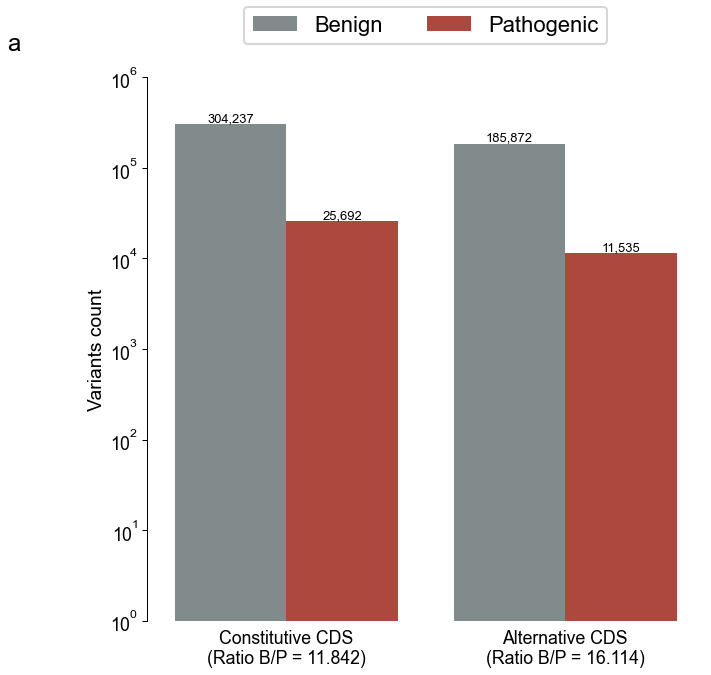

In [493]:
def show_values_on_bars(axs, i=0, fontsize=10, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height()) + (p.get_height() * 0.07) 
            if i == 0:
                value = "{:,.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

f, ax = plt.subplots(figsize=(10,10))
sns.set_context('poster')
ax.set_axisbelow(True)
# ax.grid(True, axis='y')
ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
t = merge_df_variants.groupby(['Const_Alt', 'Status']).size().reset_index()
rev_t = t.pivot(index='Status', columns='Const_Alt', values=0).to_dict()
ratio_const = str(round(rev_t['Const']['Benign'] / rev_t['Const']['Pathogenic'], 3))
ratio_alt = str(round(rev_t['Alt']['Benign'] / rev_t['Alt']['Pathogenic'], 3))
odr = (rev_t['Alt']['Pathogenic'] / rev_t['Alt']['Benign']) / (rev_t['Const']['Pathogenic'] / rev_t['Const']['Benign'])
logodr = math.log(odr)
se = math.sqrt(1/rev_t['Alt']['Pathogenic'] + 1/rev_t['Alt']['Benign'] + 1/rev_t['Const']['Pathogenic'] + 1/rev_t['Const']['Benign'])
low_ci = math.exp(logodr - 1.96*se)
up_ci = math.exp(logodr + 1.96*se)
# print(list(rev_t['Alt'].values()))
ttest = stats.ttest_ind(list(rev_t['Alt'].values()),list(rev_t['Const'].values()))
print(odr, low_ci, up_ci, ttest)



sns.barplot(data=t.sort_values(by='Const_Alt', ascending=False), y=0, hue='Status', x='Const_Alt', ax=ax, palette=['#7f8c8d', '#c0392b'])
show_values_on_bars(ax, fontsize=13)
ax.set_xticklabels(['Constitutive CDS\n(Ratio B/P = {})'.format(ratio_const), 'Alternative CDS\n(Ratio B/P = {})'.format(ratio_alt), ])
plt.ylabel('Variants count')
plt.xlabel('')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
ax.text(-0.25, 1.05, 'a', transform=ax.transAxes, size=24, weight='bold')

# plt.title('ClinVar variants distribution across Constitutive \n& Alternative coding exonic regions')
plt.yscale('log')
ax.set_ylim(bottom=1, top=1006000)
plt.minorticks_off()

ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.15))
legend = ax.legend()
legend.set_title('')
legend.texts[0].set_text("Benign(population)")
legend.texts[1].set_text("Pathogenic")
ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.15))


No handles with labels found to put in legend.


Rectangle(xy=(-0.4, 0), width=0.8, height=0.438134, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=0.451373, angle=0)


Text(0.5, 1.0, 'ClinVar variants ratio across Constitutive \n& Alternative coding exonic regions')

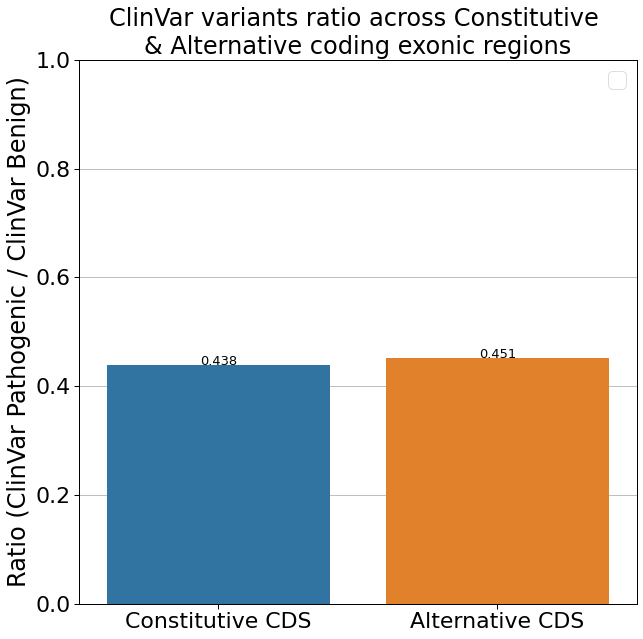

In [697]:
f, ax = plt.subplots(figsize=(10,10))
sns.set_context('paper', font_scale=2.5)
ax.set_axisbelow(True)
ax.grid(True, axis='y')
t = merge_df_variants.groupby(['Const_Alt', 'Status']).size().reset_index().pivot(index='Const_Alt', columns='Status', values=0)
t['Ratio'] = t['Pathogenic'] / t['Benign']
t = t.reset_index()

sns.barplot(data=t.sort_values(by='Const_Alt', ascending=False), y='Ratio', x='Const_Alt', ax=ax)
# plt.yscale('log')
plt.ylim(0, 1)
show_values_on_bars(ax, fontsize=13, i=3)
ax.set_xticklabels(['Constitutive CDS', 'Alternative CDS'])
plt.ylabel('Ratio (ClinVar Pathogenic / ClinVar Benign)')
plt.xlabel('')
legend = ax.legend()
plt.title('ClinVar variants ratio across Constitutive \n& Alternative coding exonic regions')

Rectangle(xy=(-0.4, 0), width=0.8, height=0.0313825, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=0.0400179, angle=0)
Rectangle(xy=(1.6, 0), width=0.8, height=0.0926546, angle=0)
Rectangle(xy=(2.6, 0), width=0.8, height=0.0474735, angle=0)
Rectangle(xy=(3.6, 0), width=0.8, height=0.16455, angle=0)


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

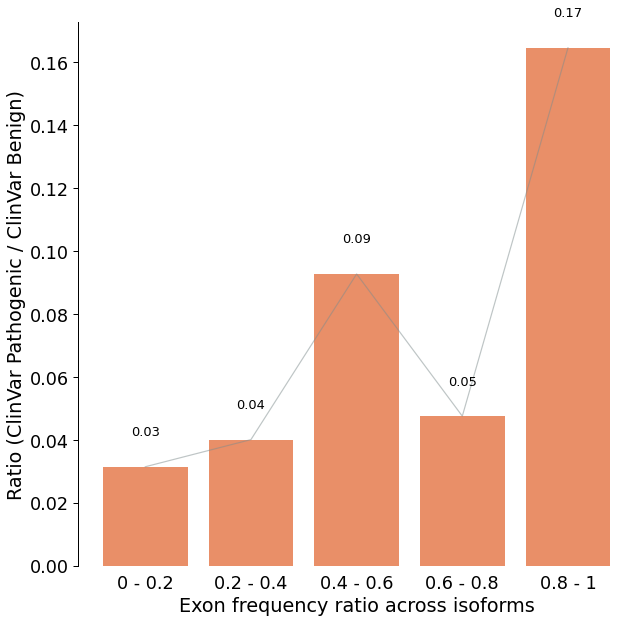

In [225]:
def show_values_on_bars(axs, i=0, fontsize=10, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height()) + 0.01
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, str(round(float(value), 2)), ha="center", fontsize=fontsize, rotation=rotation, color='black')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
f, ax = plt.subplots(figsize=(10,10))
sns.set_context('paper', font_scale=2)
ax.set_axisbelow(True)
# ax.grid(True, axis='y')
t = merge_df_variants.loc[merge_df_variants['Const_Alt'] == 'Alt'].groupby(['Ratio_num_bins', 'Status']).size().reset_index().pivot(index='Ratio_num_bins', columns='Status', values=0)
t['Ratio'] = t['Pathogenic'] / t['Benign']
t = t.reset_index()

sns.barplot(data=t, y='Ratio', x='Ratio_num_bins', ax=ax, color='#FF8652', )
sns.lineplot(data=t, y='Ratio', x='Ratio_num_bins', ax=ax, color='#7f8c8d', alpha=0.5, )

ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
             
# plt.yscale('log')
# plt.ylim(0, 1)
show_values_on_bars(ax, fontsize=13, i=3)
plt.ylabel('Ratio (ClinVar Pathogenic / ClinVar Benign)',)
plt.xlabel('Exon frequency ratio across isoforms')
plt.xticks()
# legend = ax.legend()
# plt.title('ClinVar variants ratio across Alternative coding \nexonic regions at various exonic frequency')

In [566]:
t = merge_df_variants.loc[merge_df_variants['Const_Alt'] == 'Alt'].groupby(['Ratio_num_bins', 'Status']).size().reset_index().pivot(index='Status', columns='Ratio_num_bins', values=0).to_dict()
t

{'0 - 0.2': {'Benign': 1706, 'Pathogenic': 388},
 '0.2 - 0.4': {'Benign': 7166, 'Pathogenic': 2170},
 '0.4 - 0.6': {'Benign': 16102, 'Pathogenic': 8115},
 '0.6 - 0.8': {'Benign': 20933, 'Pathogenic': 9027},
 '0.8 - 1': {'Benign': 5299, 'Pathogenic': 3413}}

1941

185 5895 11350 179977 0.497632877858859 0.4293586864810411 0.5767636452302798 Ttest_indResult(statistic=-1.057476090432527, pvalue=0.401154630782244)
1164 29087 10371 156785 0.6049756926541154 0.5686828008177419 0.6435847684790899 Ttest_indResult(statistic=-1.0525615650668592, pvalue=0.40294412245776146)
3571 38541 7964 147331 1.714074746936967 1.6451607535895707 1.7858754724585433 Ttest_indResult(statistic=-1.0206373453770208, pvalue=0.41478799832070123)
4814 101404 6721 84468 0.5966358087546811 0.5743214695440123 0.6198171358124247 Ttest_indResult(statistic=-1.002045447984177, pvalue=0.4218632423316291)
1801 10945 9734 174927 2.9570825812196007 2.8020337910326196 3.120710899396353 Ttest_indResult(statistic=-1.0391011100611438, pvalue=0.4078913464705075)
[(0.6509803921568628, 0.807843137254902, 0.8901960784313725), (0.6980392156862745, 0.8745098039215686, 0.5411764705882353), (0.984313725490196, 0.6039215686274509, 0.6), (0.9921568627450981, 0.7490196078431373, 0.43529411764705883), (

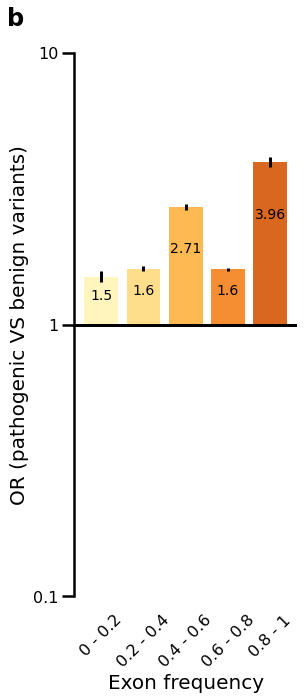

In [494]:
t_l = list()
odr_l = list()
se_l = list()
cis = list()
# for key in test['Alt']:
#     print(key)
#     sum_others_alt = sum([test['Alt'][k] for k in test['Alt'] if key != k])
#     sum_others_const = sum([test['Const'][k] for k in test['Alt'] if key != k])
#     odr = ((test['Const'][key]) / (test['Alt'][key])) / ((sum_others_const / sum_others_alt)) - 1 
#     logodr = math.log((test['Const'][key] / sum_others_const) / (test['Alt'][key] / sum_others_alt))
#     print(test['Const'][key], test['Alt'][key], sum_others_const, sum_others_alt, odr+1)
#     se = math.sqrt((1/test['Const'][key]) + (1/test['Alt'][key]) + (1/sum_others_const) + (1/sum_others_alt))
#     low_ci = math.exp(logodr - (1.96 * se))
#     up_ci = math.exp(logodr + (1.96 * se))
    
#     odr_l.append(odr)
#     se_l.append(se)    
    
t = merge_df_variants.loc[merge_df_variants['Const_Alt'] == 'Alt'].groupby(['Ratio_num_bins', 'Status']).size().reset_index().pivot(index='Status', columns='Ratio_num_bins', values=0).to_dict()
# t['Ratio'] = t['Pathogenic'] / t['Benign']
# t = t.reset_index()
t
# sns.barplot(data=t, y='Ratio', x='Ratio_num_bins', ax=ax)
# # plt.yscale('log')
# plt.ylim(0, 1)

for key in t:
    sum_others_path = sum([t[k]['Pathogenic'] for k in t if key != k])
    sum_others_benign = sum([t[k]['Benign'] for k in t if key != k])
    odr = (t[key]['Pathogenic'] / t[key]['Benign']) / (sum_others_path / sum_others_benign)
    logodr = math.log(odr)
    se = math.sqrt((1/t[key]['Pathogenic']) + (1/t[key]['Benign']) + (1/sum_others_path) + (1/sum_others_benign))
    low_ci = math.exp(logodr - (1.96 * se))
    up_ci = math.exp(logodr + (1.96 * se))
    ttest = stats.ttest_ind([t[k]['Pathogenic'], t[k]['Benign']], [sum_others_path, sum_others_benign])

    print(t[key]['Pathogenic'], t[key]['Benign'], sum_others_path, sum_others_benign, odr, low_ci, up_ci, ttest)
    odr_l.append(odr)
    se_l.append(se)
    cis.append([low_ci+1, up_ci+1])

    # Define labels, positions, bar heights and error bar heights

labels = list(t.keys())
x_pos = np.arange(len(labels))
CTEs = odr_l
error = se_l


def show_values_on_bars(axs, i=0, fontsize=10, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height() / 2) - 0.01
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, str(round(float(value) + 1, 2)), ha="center", fontsize=fontsize, rotation=rotation, color='black')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.family'] = "sans-serif"

matplotlib.rcParams['font.sans-serif'] = "DejaVu Sans"
# fontProperties = {'family':'sans-serif', 'sans-serif':['Helvetica']}
# Then, "ALWAYS use sans-serif fonts"

# Build the plot
fig, ax = plt.subplots(figsize=(4,10))
ax.set_axisbelow(True)
# ax.yaxis.grid(color='gray', zorder=0)

# plt.rc('axes', axisbelow=True)
palette = [e for j, e in enumerate(sns.color_palette("Paired")) if j%2 == 0]
print(palette)
ax.set_xticklabels(labels)
ax.bar(x_pos, CTEs,
#        yerr=error,
       align='center',
#        alpha=0.5,
#        ecolor='black',
       capsize=10,
#        color=list(reversed(sns.color_palette('mako'))),
       color=sns.color_palette('YlOrBr'),
       alpha=0.9,
#        zorder=3,
       bottom=1,
#        **hfont
      )

print(np.array(cis).T)
print(CTEs)
[line.set_zorder(3) for line in ax.lines]
ax.set_xticks(x_pos)
# ax.set_xticklabels(fontsize=14)
# ax.set_yticks([x_pos])
ax.tick_params(axis='both', which='major', labelsize=16)
# plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: round(x+2, 2)))
# ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4])
ax.set_xlabel('Exon frequency', fontsize=20)
ax.set_ylabel('OR (pathogenic VS benign variants)', fontsize=20)
show_values_on_bars(ax, fontsize=14, i=3, )
plt.yscale('log')
ax.set_yticks([0.1, 1, 10], )
plt.vlines(x_pos, np.array(cis).T[0], np.array(cis).T[1])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))

ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.ylim(0.1, 10)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
ax.axhline(1, color='black')
plt.xticks(rotation=45)
ax.text(-0.3, 1.05, 'b', transform=ax.transAxes, size=24, weight='bold')
ax.minorticks_off()
# plt.title('TEST')
# plt.title('ODR')

In [488]:
tmp_d = t.pivot(index='Status', columns='Const_Alt', values=0).to_dict()
tmp_d

{'Alt': {'Benign': 51206, 'Pathogenic': 23113},
 'Const': {'Benign': 104872, 'Pathogenic': 45948}}

In [489]:
(tmp_d['Const']['Pathogenic'] / tmp_d['Const']['Benign']) / (tmp_d['Alt']['Pathogenic'] / tmp_d['Alt']['Benign'])


0.9706699714101518

In [491]:
tmp_d['Alt']['Ratio'] = tmp_d['Alt']['Benign'] / tmp_d['Alt']['Pathogenic']
tmp_d['Const']['Ratio'] = tmp_d['Const']['Benign'] / tmp_d['Const']['Pathogenic']
tmp_d

{'Alt': {'Benign': 51206, 'Pathogenic': 23113, 'Ratio': 2.215463159261022},
 'Const': {'Benign': 104872, 'Pathogenic': 45948, 'Ratio': 2.282406198311134}}

In [360]:
test = merge_df_variants[['Const_Alt', 'Status']].groupby(['Const_Alt', 'Status']).size().reset_index().pivot(index='Status', columns='Const_Alt', values=0).to_dict()
test
# t_l = list()
# odr_l = list()
# se_l = list()


odr = ((test['Alt']['Pathogenic'] / test['Alt']['Benign']) / (test['Const']['Pathogenic'] / test['Const']['Benign']))
print(odr)



# for key in test['Alt']:
#     print(key)
#     sum_others_alt = sum([test['Alt'][k] for k in test['Alt'] if key != k])
#     sum_others_const = sum([test['Const'][k] for k in test['Alt'] if key != k])
#     odr = ((test['Const'][key]) / (test['Alt'][key])) / ((sum_others_const / sum_others_alt))
#     logodr = math.log((test['Const'][key] / sum_others_const) / (test['Alt'][key] / sum_others_alt))

#     se = math.sqrt((1/test['Const'][key]) + (1/test['Alt'][key]) + (1/sum_others_const) + (1/sum_others_alt))
#     low_ci = math.exp(logodr - (1.96 * se))
#     up_ci = math.exp(logodr + (1.96 * se))
    
#     odr_l.append(odr)
#     se_l.append(se)   
# print(odr_l)
# print(se_l)

1.054323086637156


In [138]:
# tmp_clinvar_ccrs_path = '/home/weber/PycharmProjects/ExoCarto/data/2_processed/ClinVar_CCRS_modified.parquet'
tmp_clinvar_ccrs_path = '/gstock/EXOTIC/data/VARIATIONS/ClinVar_CCRS_gnomAD.parquet'
merge_ccrs_variants = pd.read_parquet(tmp_clinvar_ccrs_path)
merge_ccrs_variants


,ALT,CHROM,CLNREVSTAT,Gene,HPO,ID,MC,POS,REF,RS_STARS,...,VAR_ID,alleleid,ranges,rs,Ratio_num,Const_Alt,Ratio_num_bins,CCRS_ranges,CCRS_bins,CCRS_CCR_percentile
0,G,12,None,A2M,None,12_9221373_T_G,None,9221373.0,T,NaN,...,None,NaN,9221336-9221438,None,1.0,Const,0.8 - 1,9221372-9221373,0 - 20,0.000000
1,G,12,None,A2M,None,12_9221373_T_G,None,9221373.0,T,NaN,...,None,NaN,9221336-9221438,None,1.0,Const,0.8 - 1,9221373-9221383,20 - 80,47.668706
2,A,12,None,A2M,None,12_9221407_G_A,None,9221407.0,G,NaN,...,None,NaN,9221336-9221438,None,1.0,Const,0.8 - 1,9221384-9221428,95 - 99,95.867591
3,C,12,None,A2M,None,12_9221429_G_C,None,9221429.0,G,NaN,...,None,NaN,9221336-9221438,None,1.0,Const,0.8 - 1,9221428-9221429,0 - 20,0.000000
4,C,12,None,A2M,None,12_9221429_G_C,None,9221429.0,G,NaN,...,None,NaN,9221336-9221438,None,1.0,Const,0.8 - 1,9221429-9221431,0 - 20,3.465301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18489511,T,4,None,TET2,None,4_106197606_C_T,None,106197606.0,C,NaN,...,None,NaN,106196205-106197676,None,0.5,Alt,0.4 - 0.6,106197606-106197620,20 - 80,43.079204
18489512,T,4,None,TET2,None,4_106197644_C_T,None,106197644.0,C,NaN,...,None,NaN,106196205-106197676,None,0.5,Alt,0.4 - 0.6,106197643-106197644,0 - 20,0.000000
18489513,T,4,None,TET2,None,4_106197644_C_T,None,106197644.0,C,NaN,...,None,NaN,106196205-106197676,None,0.5,Alt,0.4 - 0.6,106197644-106197645,0 - 20,0.000000
18489514,T,4,None,TET2,None,4_106197667_A_T,None,106197667.0,A,NaN,...,None,NaN,106196205-106197676,None,0.5,Alt,0.4 - 0.6,106197666-106197667,0 - 20,0.000000


In [139]:
bins = [0, 20, 80, 90, 95, 99, 100]
labels = bins.copy()
labels_ratio = [str(round(labels[j], 1)) + " - " + str(round(labels[j + 1], 1)) for j in range(len(labels) - 1)]
merge_ccrs_variants["CCRS_bins"] = pd.cut(merge_ccrs_variants["CCRS_CCR_percentile"], bins=bins, labels=labels_ratio, include_lowest=True)
merge_ccrs_variants = merge_ccrs_variants.drop('HPO', axis=1)
merge_ccrs_variants = merge_ccrs_variants.drop_duplicates()
merge_ccrs_variants

,ALT,CHROM,CLNREVSTAT,Gene,ID,MC,POS,REF,RS_STARS,Real_Status,...,VAR_ID,alleleid,ranges,rs,Ratio_num,Const_Alt,Ratio_num_bins,CCRS_ranges,CCRS_bins,CCRS_CCR_percentile
0,G,12,None,A2M,12_9221373_T_G,None,9221373.0,T,NaN,None,...,None,NaN,9221336-9221438,None,1.0,Const,0.8 - 1,9221372-9221373,0 - 20,0.000000
1,G,12,None,A2M,12_9221373_T_G,None,9221373.0,T,NaN,None,...,None,NaN,9221336-9221438,None,1.0,Const,0.8 - 1,9221373-9221383,20 - 80,47.668706
2,A,12,None,A2M,12_9221407_G_A,None,9221407.0,G,NaN,None,...,None,NaN,9221336-9221438,None,1.0,Const,0.8 - 1,9221384-9221428,95 - 99,95.867591
3,C,12,None,A2M,12_9221429_G_C,None,9221429.0,G,NaN,None,...,None,NaN,9221336-9221438,None,1.0,Const,0.8 - 1,9221428-9221429,0 - 20,0.000000
4,C,12,None,A2M,12_9221429_G_C,None,9221429.0,G,NaN,None,...,None,NaN,9221336-9221438,None,1.0,Const,0.8 - 1,9221429-9221431,0 - 20,3.465301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18489511,T,4,None,TET2,4_106197606_C_T,None,106197606.0,C,NaN,None,...,None,NaN,106196205-106197676,None,0.5,Alt,0.4 - 0.6,106197606-106197620,20 - 80,43.079204
18489512,T,4,None,TET2,4_106197644_C_T,None,106197644.0,C,NaN,None,...,None,NaN,106196205-106197676,None,0.5,Alt,0.4 - 0.6,106197643-106197644,0 - 20,0.000000
18489513,T,4,None,TET2,4_106197644_C_T,None,106197644.0,C,NaN,None,...,None,NaN,106196205-106197676,None,0.5,Alt,0.4 - 0.6,106197644-106197645,0 - 20,0.000000
18489514,T,4,None,TET2,4_106197667_A_T,None,106197667.0,A,NaN,None,...,None,NaN,106196205-106197676,None,0.5,Alt,0.4 - 0.6,106197666-106197667,0 - 20,0.000000


In [144]:
merge_ccrs_variants.loc[(merge_ccrs_variants['Status'] == 'Pathogenic') & (merge_ccrs_variants['RS_STARS'] > 0)]

,ALT,CHROM,CLNREVSTAT,Gene,ID,MC,POS,REF,RS_STARS,Real_Status,...,VAR_ID,alleleid,ranges,rs,Ratio_num,Const_Alt,Ratio_num_bins,CCRS_ranges,CCRS_bins,CCRS_CCR_percentile
882,T,12,"criteria_provided,_single_submitter",A2ML1,12_8975257_C_T,nonsense,8975257.0,C,1.0,Likely_pathogenic,...,12_8975257_C_['T'],608923.0,8975248-8975309,1409944554,0.5,Alt,0.4 - 0.6,8975256-8975257,0 - 20,0.000000
883,T,12,"criteria_provided,_single_submitter",A2ML1,12_8975257_C_T,nonsense,8975257.0,C,1.0,Likely_pathogenic,...,12_8975257_C_['T'],608923.0,8975248-8975309,1409944554,0.5,Alt,0.4 - 0.6,8975257-8975259,0 - 20,7.271167
1660,A,17,"criteria_provided,_single_submitter",ACOX1,17_73953636_G_A,nonsense,73953636.0,G,1.0,Pathogenic,...,17_73953636_G_['A'],16541.0,73953540-73953647,118204093,1.0,Const,0.8 - 1,73953635-73953647,80 - 90,87.882924
1703,G,17,"criteria_provided,_single_submitter",ACOX1,17_73974708_C_G,missense_variant,73974708.0,C,1.0,Likely_pathogenic,...,17_73974708_C_['G'],213647.0,73974615-73974769,777937235,1.0,Const,0.8 - 1,73974707-73974708,0 - 20,0.000000
1704,G,17,"criteria_provided,_single_submitter",ACOX1,17_73974708_C_G,missense_variant,73974708.0,C,1.0,Likely_pathogenic,...,17_73974708_C_['G'],213647.0,73974615-73974769,777937235,1.0,Const,0.8 - 1,73974708-73974709,0 - 20,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18488842,A,5,"criteria_provided,_single_submitter",TERT,5_1293620_C_A,missense_variant,1293620.0,C,1.0,Pathogenic,...,5_1293620_C_['A'],815911.0,1293428-1294781,1579596470,1.0,Const,0.8 - 1,1293608-1293646,80 - 90,88.377415
18488878,A,5,"criteria_provided,_single_submitter",TERT,5_1294313_G_A,nonsense,1294313.0,G,1.0,Pathogenic,...,5_1294313_G_['A'],633029.0,1293428-1294781,989271195,1.0,Const,0.8 - 1,1294299-1294340,90 - 95,90.788034
18488892,A,5,"criteria_provided,_single_submitter",TERT,5_1294654_G_A,missense_variant,1294654.0,G,1.0,Likely_pathogenic,...,5_1294654_G_['A'],904965.0,1293428-1294781,None,1.0,Const,0.8 - 1,1294619-1294754,99 - 100,99.712331
18488893,C,5,"criteria_provided,_single_submitter",TERT,5_1294656_G_C,missense_variant,1294656.0,G,1.0,Likely_pathogenic,...,5_1294656_G_['C'],804863.0,1293428-1294781,1579598699,1.0,Const,0.8 - 1,1294619-1294754,99 - 100,99.712331


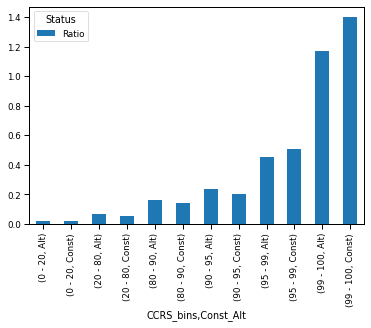

In [175]:
d = pd.pivot_table(merge_ccrs_variants.groupby(['Const_Alt', 'Status', 'CCRS_bins']).size().reset_index(), index=['CCRS_bins', 'Const_Alt'], columns='Status', values=0)
d['Ratio'] = d['Pathogenic'] / d['Benign']
d[['Ratio']].plot.bar()
# plt.yscale('log')

In [218]:
merge_ccrs_variants

,ALT,CHROM,CLNREVSTAT,Gene,ID,MC,POS,REF,RS_STARS,Real_Status,...,VAR_ID,alleleid,ranges,rs,Ratio_num,Const_Alt,Ratio_num_bins,CCRS_ranges,CCRS_bins,CCRS_CCR_percentile
882,T,12,"criteria_provided,_single_submitter",A2ML1,12_8975257_C_T,nonsense,8975257.0,C,1.0,Likely_pathogenic,...,12_8975257_C_['T'],608923.0,8975248-8975309,1409944554,0.5,Alt,0.4 - 0.6,8975256-8975257,0 - 20,0.000000
883,T,12,"criteria_provided,_single_submitter",A2ML1,12_8975257_C_T,nonsense,8975257.0,C,1.0,Likely_pathogenic,...,12_8975257_C_['T'],608923.0,8975248-8975309,1409944554,0.5,Alt,0.4 - 0.6,8975257-8975259,0 - 20,7.271167
884,C,12,None,A2ML1,12_8975273_T_C,None,8975273.0,T,NaN,None,...,None,NaN,8975248-8975309,None,0.5,Alt,0.4 - 0.6,8975272-8975273,0 - 20,0.000000
885,C,12,None,A2ML1,12_8975273_T_C,None,8975273.0,T,NaN,None,...,None,NaN,8975248-8975309,None,0.5,Alt,0.4 - 0.6,8975273-8975277,0 - 20,17.128583
886,G,12,None,A2ML1,12_8975281_C_G,None,8975281.0,C,NaN,None,...,None,NaN,8975248-8975309,None,0.5,Alt,0.4 - 0.6,8975280-8975281,0 - 20,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18488891,A,5,None,TERT,5_1294484_G_A,None,1294484.0,G,NaN,None,...,None,NaN,1293428-1294781,None,1.0,Const,0.8 - 1,1294430-1294492,95 - 99,96.444464
18488892,A,5,"criteria_provided,_single_submitter",TERT,5_1294654_G_A,missense_variant,1294654.0,G,1.0,Likely_pathogenic,...,5_1294654_G_['A'],904965.0,1293428-1294781,None,1.0,Const,0.8 - 1,1294619-1294754,99 - 100,99.712331
18488893,C,5,"criteria_provided,_single_submitter",TERT,5_1294656_G_C,missense_variant,1294656.0,G,1.0,Likely_pathogenic,...,5_1294656_G_['C'],804863.0,1293428-1294781,1579598699,1.0,Const,0.8 - 1,1294619-1294754,99 - 100,99.712331
18488894,T,5,None,TERT,5_1294741_C_T,None,1294741.0,C,NaN,None,...,None,NaN,1293428-1294781,None,1.0,Const,0.8 - 1,1294619-1294754,99 - 100,99.712331


In [176]:
path_genes = list(merge_ccrs_variants.loc[merge_ccrs_variants['Status'] == 'Pathogenic'].Gene.unique())
merge_ccrs_variants = merge_ccrs_variants.loc[merge_ccrs_variants['Gene'].isin(path_genes)]
merge_ccrs_variants

,ALT,CHROM,CLNREVSTAT,Gene,ID,MC,POS,REF,RS_STARS,Real_Status,...,VAR_ID,alleleid,ranges,rs,Ratio_num,Const_Alt,Ratio_num_bins,CCRS_ranges,CCRS_bins,CCRS_CCR_percentile
882,T,12,"criteria_provided,_single_submitter",A2ML1,12_8975257_C_T,nonsense,8975257.0,C,1.0,Likely_pathogenic,...,12_8975257_C_['T'],608923.0,8975248-8975309,1409944554,0.5,Alt,0.4 - 0.6,8975256-8975257,0 - 20,0.000000
883,T,12,"criteria_provided,_single_submitter",A2ML1,12_8975257_C_T,nonsense,8975257.0,C,1.0,Likely_pathogenic,...,12_8975257_C_['T'],608923.0,8975248-8975309,1409944554,0.5,Alt,0.4 - 0.6,8975257-8975259,0 - 20,7.271167
884,C,12,None,A2ML1,12_8975273_T_C,None,8975273.0,T,NaN,None,...,None,NaN,8975248-8975309,None,0.5,Alt,0.4 - 0.6,8975272-8975273,0 - 20,0.000000
885,C,12,None,A2ML1,12_8975273_T_C,None,8975273.0,T,NaN,None,...,None,NaN,8975248-8975309,None,0.5,Alt,0.4 - 0.6,8975273-8975277,0 - 20,17.128583
886,G,12,None,A2ML1,12_8975281_C_G,None,8975281.0,C,NaN,None,...,None,NaN,8975248-8975309,None,0.5,Alt,0.4 - 0.6,8975280-8975281,0 - 20,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18488891,A,5,None,TERT,5_1294484_G_A,None,1294484.0,G,NaN,None,...,None,NaN,1293428-1294781,None,1.0,Const,0.8 - 1,1294430-1294492,95 - 99,96.444464
18488892,A,5,"criteria_provided,_single_submitter",TERT,5_1294654_G_A,missense_variant,1294654.0,G,1.0,Likely_pathogenic,...,5_1294654_G_['A'],904965.0,1293428-1294781,None,1.0,Const,0.8 - 1,1294619-1294754,99 - 100,99.712331
18488893,C,5,"criteria_provided,_single_submitter",TERT,5_1294656_G_C,missense_variant,1294656.0,G,1.0,Likely_pathogenic,...,5_1294656_G_['C'],804863.0,1293428-1294781,1579598699,1.0,Const,0.8 - 1,1294619-1294754,99 - 100,99.712331
18488894,T,5,None,TERT,5_1294741_C_T,None,1294741.0,C,NaN,None,...,None,NaN,1293428-1294781,None,1.0,Const,0.8 - 1,1294619-1294754,99 - 100,99.712331


In [222]:
d

Status               Benign  Pathogenic     Ratio
CCRS_bins Const_Alt                              
0 - 20    Alt         97062        4503  0.046393
          Const      239946       10279  0.042839
20 - 80   Alt         21214        2970  0.140002
          Const       55177        6229  0.112891
80 - 90   Alt          1485         490  0.329966
          Const        4303        1259  0.292587
90 - 95   Alt           513         271  0.528265
          Const        1828         753  0.411926
95 - 99   Alt           286         281  0.982517
          Const        1104        1075  0.973732
99 - 100  Alt            34          77  2.264706
          Const         180         395  2.194444

97062 4503 23532 4089
21214 2970 99380 5622
1485 490 119109 8102
513 271 120081 8321
286 281 120308 8311
34 77 120560 8515
239946 10279 62592 9711
55177 6229 247361 13761
4303 1259 298235 18731
1828 753 300710 19237
1104 1075 301434 18915
180 395 302358 19595
Legend
Rectangle(xy=(-0.4, 1), width=0.4, height=-0.723884, angle=0)
-0.7238835848559182
Rectangle(xy=(0.6, 1), width=0.4, height=1.02928, angle=0)
1.0292776865143125
Rectangle(xy=(1.6, 1), width=0.4, height=3.65856, angle=0)
3.658563609078781
Rectangle(xy=(2.6, 1), width=0.4, height=5.43916, angle=0)
5.43916139223408
Rectangle(xy=(3.6, 1), width=0.4, height=14.5176, angle=0)
14.517626050178718
Rectangle(xy=(4.6, 1), width=0.4, height=32.8611, angle=0)
32.861078506421705
Rectangle(xy=(-2.77556e-17, 1), width=0.4, height=-0.73301, angle=0)
-0.733010341258304
Rectangle(xy=(1, 1), width=0.4, height=1.47481, angle=0)
1.4748109899837596
Rectangle(xy=(2, 1), width=0.4, height=3.8509, angle=0)
3.8508960251739808
Rectangle(xy=(3, 1), widt

Const_Alt               Alt   Const
CCRS_bins Status                   
0 - 20    Benign      97062  239946
          Pathogenic   4503   10279
20 - 80   Benign      21214   55177
          Pathogenic   2970    6229
80 - 90   Benign       1485    4303
          Pathogenic    490    1259
90 - 95   Benign        513    1828
          Pathogenic    271     753
95 - 99   Benign        286    1104
          Pathogenic    281    1075
99 - 100  Benign         34     180
          Pathogenic     77     395

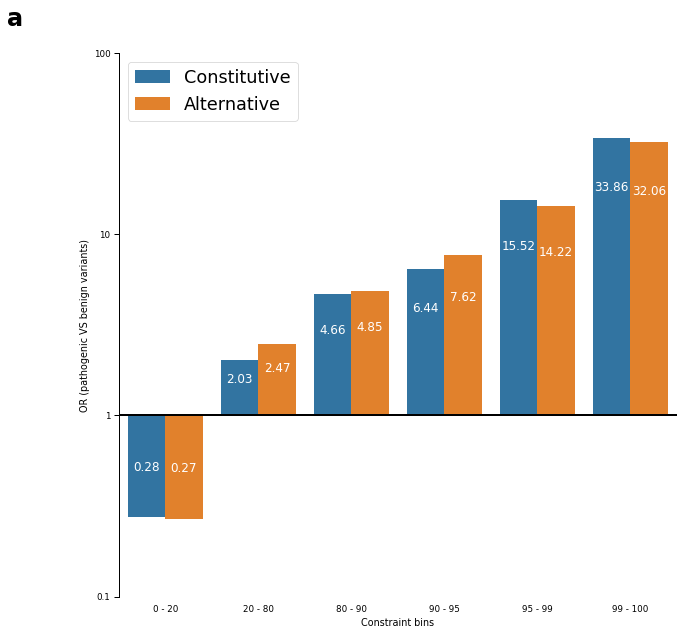

In [177]:
d = pd.pivot_table(merge_ccrs_variants.groupby(['Const_Alt', 'Status', 'CCRS_bins']).size().reset_index(), index=['CCRS_bins', 'Status'], columns='Const_Alt', values=0)
# d = pd.pivot_table(merge_ccrs_variants.groupby(['Const_Alt', 'Status', 'CCRS_bins']).size().reset_index(), index=['CCRS_bins', 'Const_Alt'], columns='Status', values=0)
d

new_d = collections.defaultdict(dict)
for k in d.to_dict():
    new_d[k] = dict()
    for sub_k, v in d[k].items():
        if sub_k[0] not in new_d[k]:
            new_d[k][sub_k[0]] = dict()
        new_d[k][sub_k[0]][sub_k[1]] = v
odr_alt = list()
odr_const = list()
labels = list(new_d['Alt'].keys())

l = list()

def show_values_on_bars(axs, i=0, fontsize=10, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            print(p.get_height())
            if p.get_height() >= 1:
                _y = p.get_y() + (p.get_height() / 2)
            elif p.get_height() < 1:
                _y = p.get_y() + (p.get_height() / 2) + p.get_height() * 0.2
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, str(round(float(value) + 1, 2)), ha="center", fontsize=fontsize, rotation=rotation, color='white')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

new_d
        
for const_alt in new_d:
    for ccr in new_d[const_alt]:
        b = new_d[const_alt][ccr]['Benign']
        p = new_d[const_alt][ccr]['Pathogenic']
        other_b = sum([new_d[const_alt][e]['Benign'] for e in labels if new_d[const_alt][e]['Benign'] != b])
        other_p= sum([new_d[const_alt][e]['Pathogenic'] for e in labels if new_d[const_alt][e]['Pathogenic'] != p])
        print(b, p, other_b, other_p)
        odr = ((p / b) / (other_p / other_b))
#         print(const_alt, ccr, odr)
        l.append(
            {
                'Const_Alt' : const_alt,
                'CCRS_bins' : ccr,
                'ODR' : odr,
            }        
        )

t = pd.DataFrame(l)
t['ODR'] = t['ODR'] - 1
# t

f, ax = plt.subplots(figsize=(10,10))
sns.set_context('paper',  font_scale=2)

ax.set_axisbelow(True)
# ax.grid(True, axis='y')
p = sns.barplot(data=t.sort_values(by='Const_Alt', ascending=False), x='CCRS_bins', y='ODR', hue='Const_Alt', bottom=1, zorder=1)
plt.yscale('log')
# plt.xticks(rotation=45)
plt.xlabel('Constraint bins')
plt.ylabel('OR (pathogenic VS benign variants)')
ax.legend(loc='upper left')
legend = ax.get_legend()
legend.set_title('')
legend.texts[0].set_text("Constitutive")
legend.texts[1].set_text("Alternative")
print(legend)
# ax.legend(loc='upper left')
show_values_on_bars(ax, i=2, fontsize=12)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
ax.set_yticks([0.1, 1, 10, 100, ], )
ax.set_ylim(0.1, 100)
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.minorticks_off()
plt.axhline(1, lw=2, color='black', zorder=2)
ax.text(-0.2, 1.05, 'a', transform=ax.transAxes, size=24, weight='bold')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
# plt.yscale('symlog')
# plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x+1))
# ax.set_yticklabels([1,'', 10])
# yticks = ax.yaxis.get_major_ticks()
# yticks[1].set_visible(False)
# plt.yticks([1, 10])

# plt.ylim(0, )
d

In [121]:
d = pd.pivot_table(merge_ccrs_variants.loc[merge_ccrs_variants['Const_Alt'] == 'Alt'].groupby(['Status', 'CCRS_bins', 'Ratio_num_bins']).size().reset_index(), index=['CCRS_bins', 'Status'], columns='Ratio_num_bins', values=0)
d

Ratio_num_bins        0 - 0.2  0.2 - 0.4  0.4 - 0.6  0.6 - 0.8  0.8 - 1
CCRS_bins Status                                                       
0 - 20    Benign       2142.0   165154.0    39283.0    21708.0   4806.0
          Pathogenic    158.0     1231.0     5134.0     5867.0   1845.0
20 - 80   Benign        715.0    42415.0     5970.0    26169.0   2706.0
          Pathogenic     57.0      563.0     3432.0     4050.0   1420.0
80 - 90   Benign         53.0    10180.0      706.0      851.0    446.0
          Pathogenic     18.0       91.0      522.0      669.0    286.0
90 - 95   Benign         23.0       42.0      230.0      914.0    132.0
          Pathogenic      1.0       20.0      112.0     1901.0    105.0
95 - 99   Benign         25.0       70.0      134.0      479.0    103.0
          Pathogenic     48.0       18.0      160.0     1003.0    126.0
99 - 100  Benign          2.0        8.0       50.0       80.0     18.0
          Pathogenic      NaN       11.0       45.0       90.0     25.0

In [429]:


def show_values_on_bars(axs, i=0, fontsize=10, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2 + 0.01
            print(p.get_height())
#             if p.get_height() >= 1:
            _y = p.get_y() + ((p.get_height() / 2))  - (p.get_height() * 0.33)
#             elif p.get_height() < 1:
#                 _y = p.get_y() + (p.get_height() / 2) + p.get_height() * 0.2
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, str(round(float(value) + 1, 2)), ha="center", fontsize=fontsize, rotation=rotation, color='black')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
d = pd.pivot_table(merge_ccrs_variants.loc[merge_ccrs_variants['Const_Alt'] == 'Alt'].groupby(['Status', 'CCRS_bins', 'Ratio_num_bins']).size().reset_index(), index=['CCRS_bins', 'Status'], columns='Ratio_num_bins', values=0).fillna(1).to_dict()
new_d = collections.defaultdict(dict)
for k in d:
    new_d[k] = dict()
    for sub_k, v in d[k].items():
        if sub_k[0] not in new_d[k]:
            new_d[k][sub_k[0]] = dict()
        new_d[k][sub_k[0]][sub_k[1]] = v
labels = list(new_d[list(new_d.keys())[0]].keys())
labels
        # new_d
l = list()

for const_alt in new_d:
    for ccr in new_d[const_alt]:
#         print(const_alt, ccr, new_d[const_alt][ccr])
        b = new_d[const_alt][ccr]['Benign']
        p = new_d[const_alt][ccr]['Pathogenic']
        other_b = sum([new_d[const_alt][e]['Benign'] for e in labels if new_d[const_alt][e]['Benign'] != b])
        other_p= sum([new_d[const_alt][e]['Pathogenic'] for e in labels if new_d[const_alt][e]['Pathogenic'] != p])
#         print(const_alt, ccr, b, p, other_b, other_p)

        odr = ((p / b) / (other_p / other_b))
        l.append(
            {
                'Ratio_num_bins' : const_alt,
                'CCRS_bins' : ccr,
                'ODR' : odr,
            }        
        )

sns.set_context('paper',  font_scale=2)
t = pd.DataFrame(l)


# print(t)
f, ax = plt.subplots(figsize=(10,10))
ax.set_axisbelow(True)
ax.grid(True, axis='y')
# ax.set_yscale('log')
p = sns.barplot(data=t, x='CCRS_bins', y='ODR', hue='Ratio_num_bins', bottom=1, palette='YlOrBr')
# plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x+1))
plt.yscale('log')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
show_values_on_bars(ax, i=2, fontsize=12, rotation=90)
# plt.ylim(0.1, 100)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
# ax.set_yticks([0.1, 1, 10, 100, ], )
# ax.set_ylim(0.1, 100)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.minorticks_off()
# plt.axhline(1, lw=2, color='black', zorder=2)
ax.text(-0.1, 1.05, 'a', transform=ax.transAxes, size=24, weight='bold')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.xlabel('Constraint bins')
plt.ylabel('OR (pathogenic VS benign variants)')
legend = p.get_legend()
legend.set_title('Exon frequency')
t

,Ratio_num_bins,CCRS_bins,ODR
0,0 - 0.2,0 - 20,0.368080
1,0 - 0.2,20 - 80,2.328046
2,0 - 0.2,80 - 90,0.925566
3,0 - 0.2,90 - 95,4.666290
4,0 - 0.2,95 - 99,26.467949
5,0 - 0.2,99 - 100,79.480769
6,0.2 - 0.4,0 - 20,0.315301
7,0.2 - 0.4,20 - 80,2.360249
8,0.2 - 0.4,80 - 90,5.802113
9,0.2 - 0.4,90 - 95,3.253370


In [434]:


def show_values_on_bars(axs, i=0, fontsize=10, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2 + 0.01
            print(p.get_height())
#             if p.get_height() >= 1:
            _y = p.get_y() + ((p.get_height() / 2))  - (p.get_height() * 0.33)
#             elif p.get_height() < 1:
#                 _y = p.get_y() + (p.get_height() / 2) + p.get_height() * 0.2
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, str(round(float(value) + 1, 2)), ha="center", fontsize=fontsize, rotation=rotation, color='black')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
d = pd.pivot_table(merge_ccrs_variants.loc[merge_ccrs_variants['Const_Alt'] == 'Alt'].groupby(['Status', 'CCRS_bins', 'Ratio_num_bins']).size().reset_index(), index=['CCRS_bins', 'Status'], columns='Ratio_num_bins', values=0).fillna(1).to_dict()
new_d = collections.defaultdict(dict)
for k in d:
    new_d[k] = dict()
    for sub_k, v in d[k].items():
        if sub_k[0] not in new_d[k]:
            new_d[k][sub_k[0]] = dict()
        new_d[k][sub_k[0]][sub_k[1]] = v
labels = list(new_d[list(new_d.keys())[0]].keys())
labels
        # new_d
l = list()

for const_alt in new_d:
    for ccr in new_d[const_alt]:
#         print(const_alt, ccr, new_d[const_alt][ccr])
        b = new_d[const_alt][ccr]['Benign']
        p = new_d[const_alt][ccr]['Pathogenic']
        other_b = sum([new_d[const_alt][e]['Benign'] for e in labels if new_d[const_alt][e]['Benign'] != b])
        other_p= sum([new_d[const_alt][e]['Pathogenic'] for e in labels if new_d[const_alt][e]['Pathogenic'] != p])
#         print(const_alt, ccr, b, p, other_b, other_p)

        odr = ((p / b) / (other_p / other_b))
        l.append(
            {
                'Ratio_num_bins' : const_alt,
                'CCRS_bins' : ccr,
                'ODR' : odr,
                'Count_pathogenic' : p,
                'Count_benign' : b,
            }        
        )

sns.set_context('paper',  font_scale=2)
t = pd.DataFrame(l)

# t = t.melt(id_vars=['Ratio_num_bins', 'CCRS_bins'], value_vars=['Count_pathogenic', 'Count_benign'])

t = pd.pivot_table(data=t, index='Ratio_num_bins', columns='CCRS_bins', values=['Count_pathogenic', 'Count_benign']).round(2)
# t.columns = t.columns.swaplevel(0, 1)
# t.to_excel('/gstock/EXOTIC/data/VARIATIONS/Exon_freq_CCR_OR_analysis.xlsx')
t


# sns.set_context('paper', font_scale=1)
# g = sns.FacetGrid(data=t, col='Ratio_num_bins', )
# g.map(sns.barplot, 'CCRS_bins', 'value', 'variable', palette='Paired')
# plt.yscale('log')
# plt.ylim(1, 10e5)

# # print(t)
# f, ax = plt.subplots(figsize=(10,10))
# ax.set_axisbelow(True)
# ax.grid(True, axis='y')
# # ax.set_yscale('log')
# p = sns.barplot(data=t, x='CCRS_bins', y='ODR', hue='Ratio_num_bins', bottom=1, palette='YlOrBr')
# # plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x+1))
# plt.yscale('log')
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# # ax.spines['bottom'].set_linewidth(0)
# ax.spines['right'].set_linewidth(0)
# ax.spines['top'].set_linewidth(0)
# show_values_on_bars(ax, i=2, fontsize=12, rotation=90)
# # plt.ylim(0.1, 100)
# plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
# # ax.set_yticks([0.1, 1, 10, 100, ], )
# # ax.set_ylim(0.1, 100)
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.minorticks_off()
# # plt.axhline(1, lw=2, color='black', zorder=2)
# ax.text(-0.1, 1.05, 'a', transform=ax.transAxes, size=24, weight='bold')
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# # ax.spines['bottom'].set_linewidth(0)
# ax.spines['right'].set_linewidth(0)
# ax.spines['top'].set_linewidth(0)
# plt.xlabel('Constraint bins')
# plt.ylabel('OR (pathogenic VS benign variants)')
# legend = p.get_legend()
# legend.set_title('Exon frequency')
# new_d

Count_benign                                           \
CCRS_bins            0 - 20 20 - 80 80 - 90 90 - 95 95 - 99 99 - 100   
Ratio_num_bins                                                         
0 - 0.2              6826.0  1329.0    85.0    17.0     9.0      1.0   
0.2 - 0.4           15151.0  3133.0   196.0    86.0    29.0      8.0   
0.4 - 0.6           35477.0  7660.0   533.0   169.0   112.0     14.0   
0.6 - 0.8           27497.0  6126.0   442.0   175.0    83.0      7.0   
0.8 - 1             12111.0  2966.0   229.0    66.0    53.0      4.0   

               Count_pathogenic                                           
CCRS_bins                0 - 20 20 - 80 80 - 90 90 - 95 95 - 99 99 - 100  
Ratio_num_bins                                                            
0 - 0.2                    68.0    33.0     1.0     1.0     3.0      1.0  
0.2 - 0.4                 429.0   239.0    43.0    11.0     9.0      8.0  
0.4 - 0.6                1805.0  1203.0   186.0    74.0   111.0     38.0  
0.6 - 0.8                1531.0   874.0   127.0   128.0   106.0     12.0  
0.8 - 1                   670.0   621.0   134.0    57.0    52.0     19.0

0 - 20 0 - 0.2 {'Benign': 6826.0, 'Pathogenic': 68.0}
0 - 20 0 - 0.2 6826.0 68.0 90236.0 4435.0
0 - 20 0.2 - 0.4 {'Benign': 15151.0, 'Pathogenic': 429.0}
0 - 20 0.2 - 0.4 15151.0 429.0 81911.0 4074.0
0 - 20 0.4 - 0.6 {'Benign': 35477.0, 'Pathogenic': 1805.0}
0 - 20 0.4 - 0.6 35477.0 1805.0 61585.0 2698.0
0 - 20 0.6 - 0.8 {'Benign': 27497.0, 'Pathogenic': 1531.0}
0 - 20 0.6 - 0.8 27497.0 1531.0 69565.0 2972.0
0 - 20 0.8 - 1 {'Benign': 12111.0, 'Pathogenic': 670.0}
0 - 20 0.8 - 1 12111.0 670.0 84951.0 3833.0
20 - 80 0 - 0.2 {'Benign': 1329.0, 'Pathogenic': 33.0}
20 - 80 0 - 0.2 1329.0 33.0 19885.0 2937.0
20 - 80 0.2 - 0.4 {'Benign': 3133.0, 'Pathogenic': 239.0}
20 - 80 0.2 - 0.4 3133.0 239.0 18081.0 2731.0
20 - 80 0.4 - 0.6 {'Benign': 7660.0, 'Pathogenic': 1203.0}
20 - 80 0.4 - 0.6 7660.0 1203.0 13554.0 1767.0
20 - 80 0.6 - 0.8 {'Benign': 6126.0, 'Pathogenic': 874.0}
20 - 80 0.6 - 0.8 6126.0 874.0 15088.0 2096.0
20 - 80 0.8 - 1 {'Benign': 2966.0, 'Pathogenic': 621.0}
20 - 80 0.8 - 1 2966

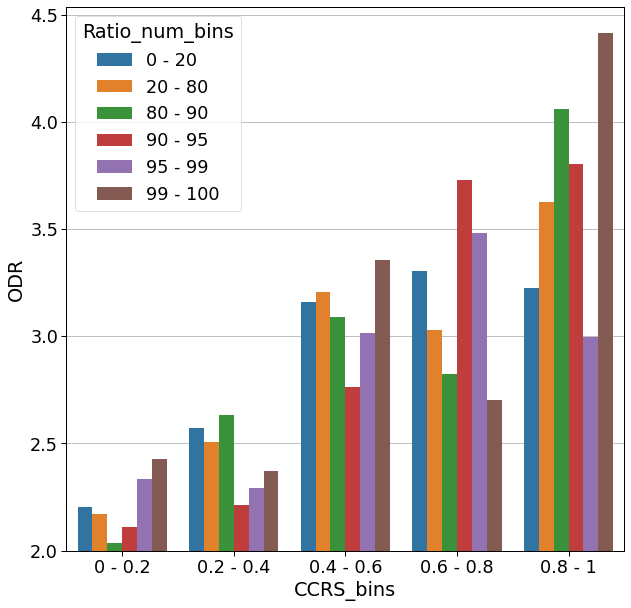

In [181]:

d = pd.pivot_table(merge_ccrs_variants.loc[merge_ccrs_variants['Const_Alt'] == 'Alt'].groupby(['Status', 'CCRS_bins', 'Ratio_num_bins']).size().reset_index(), index=['Ratio_num_bins', 'Status'], columns='CCRS_bins', values=0).fillna(1).to_dict()
new_d = collections.defaultdict(dict)
for k in d:
    new_d[k] = dict()
    for sub_k, v in d[k].items():
        if sub_k[0] not in new_d[k]:
            new_d[k][sub_k[0]] = dict()
        new_d[k][sub_k[0]][sub_k[1]] = v
labels = list(new_d[list(new_d.keys())[0]].keys())
labels
        # new_d
l = list()

for const_alt in new_d:
    for ccr in new_d[const_alt]:
        print(const_alt, ccr, new_d[const_alt][ccr])
        b = new_d[const_alt][ccr]['Benign']
        p = new_d[const_alt][ccr]['Pathogenic']
        other_b = sum([new_d[const_alt][e]['Benign'] for e in labels if new_d[const_alt][e]['Benign'] != b])
        other_p= sum([new_d[const_alt][e]['Pathogenic'] for e in labels if new_d[const_alt][e]['Pathogenic'] != p])
        print(const_alt, ccr, b, p, other_b, other_p)

        odr = ((p / b) / (other_p / other_b))
        l.append(
            {
                'Ratio_num_bins' : const_alt,
                'CCRS_bins' : ccr,
                'ODR' : odr,
            }        
        )

t = pd.DataFrame(l)
print(t)
f, ax = plt.subplots(figsize=(10,10))
ax.set_axisbelow(True)
ax.grid(True, axis='y')
# ax.set_yscale('log')
sns.barplot(data=t, x='CCRS_bins', y='ODR', hue='Ratio_num_bins', bottom=1)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x+1))


In [358]:
exotic_ccrs_variants = pd.merge(exotic, merge_ccrs_variants, left_on='Exon', right_on='ranges').drop_duplicates(subset=['MAP', 'CCRS_ranges', 'ID'])
exotic_ccrs_variants 

,MAP,Ratio_num_x,mRNA_nb,symbol,Adipose - Subcutaneous_exotic,Adipose - Visceral (Omentum)_exotic,Adrenal Gland_exotic,Artery - Aorta_exotic,Artery - Coronary_exotic,Artery - Tibial_exotic,...,VAR_ID,alleleid,ranges,rs,Ratio_num_y,Const_Alt,Ratio_num_bins_y,CCRS_ranges,CCRS_bins,CCRS_CCR_percentile
0,AAAS_53708535-53708633,0.5,2,AAAS,0.444111,0.654152,0.641317,0.235796,0.285570,0.218994,...,None,NaN,53708535-53708633,None,0.5,Alt,0.4 - 0.6,53708538-53708539,0 - 20,0.000000
1,AAAS_53708535-53708633,0.5,2,AAAS,0.444111,0.654152,0.641317,0.235796,0.285570,0.218994,...,None,NaN,53708535-53708633,None,0.5,Alt,0.4 - 0.6,53708539-53708552,20 - 80,62.574800
2,AAAS_53708535-53708633,0.5,2,AAAS,0.444111,0.654152,0.641317,0.235796,0.285570,0.218994,...,None,NaN,53708535-53708633,None,0.5,Alt,0.4 - 0.6,53708552-53708553,0 - 20,0.000000
3,AAAS_53708535-53708633,0.5,2,AAAS,0.444111,0.654152,0.641317,0.235796,0.285570,0.218994,...,None,NaN,53708535-53708633,None,0.5,Alt,0.4 - 0.6,53708553-53708554,0 - 20,0.000000
4,AAAS_53708535-53708633,0.5,2,AAAS,0.444111,0.654152,0.641317,0.235796,0.285570,0.218994,...,None,NaN,53708535-53708633,None,0.5,Alt,0.4 - 0.6,53708553-53708554,0 - 20,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76829,ZNF462_109689445-109692040,0.5,2,ZNF462,0.417414,0.388837,0.327725,0.643346,0.564145,0.570581,...,None,NaN,109689445-109692040,None,0.5,Alt,0.4 - 0.6,109691907-109691929,80 - 90,82.087911
76830,ZNF462_109689445-109692040,0.5,2,ZNF462,0.417414,0.388837,0.327725,0.643346,0.564145,0.570581,...,None,NaN,109689445-109692040,None,0.5,Alt,0.4 - 0.6,109691954-109691955,0 - 20,0.000000
76831,ZNF462_109689445-109692040,0.5,2,ZNF462,0.417414,0.388837,0.327725,0.643346,0.564145,0.570581,...,None,NaN,109689445-109692040,None,0.5,Alt,0.4 - 0.6,109691955-109692001,95 - 99,96.539502
76832,ZNF462_109689445-109692040,0.5,2,ZNF462,0.417414,0.388837,0.327725,0.643346,0.564145,0.570581,...,None,NaN,109689445-109692040,None,0.5,Alt,0.4 - 0.6,109692001-109692002,0 - 20,0.000000


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


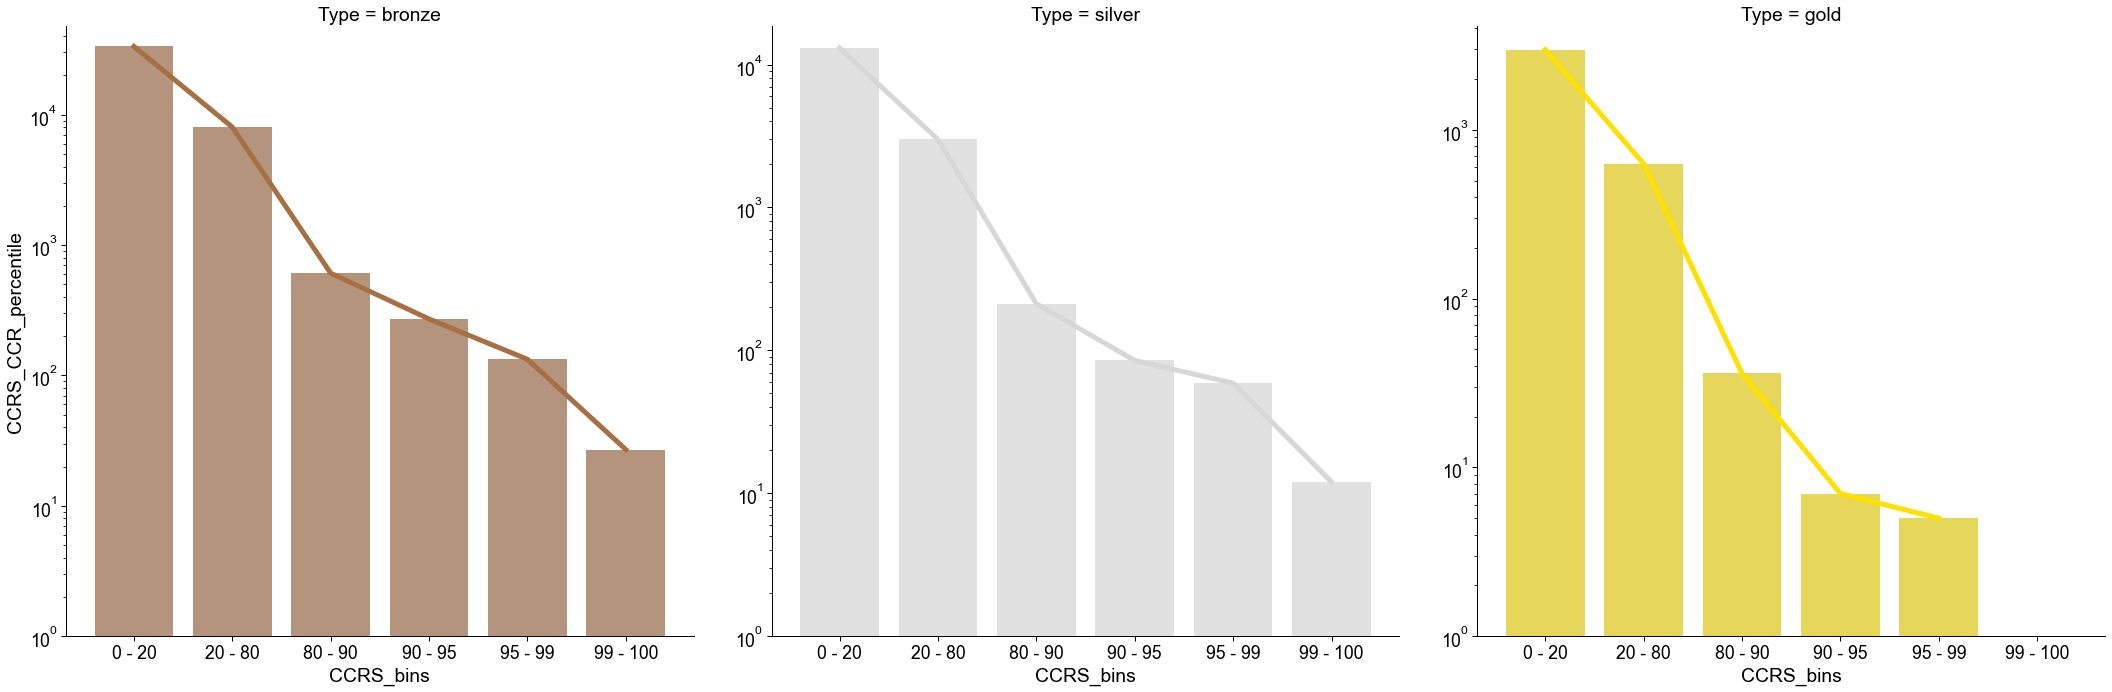

In [378]:

t = exotic_ccrs_variants[['Type', 'CCRS_bins', 'CCRS_CCR_percentile']].groupby(['Type', 'CCRS_bins']).count().reset_index()
g = sns.FacetGrid(data=t, col='Type', hue='Type', sharey=False, height=10, palette={'No\nthreshold' : "#2d3436", 'bronze' : "#A77044", 'silver' : "#D7D7D7", 'gold': "#FEE101"})
g.map(sns.barplot, 'CCRS_bins', 'CCRS_CCR_percentile', alpha=0.75)
g.map(sns.lineplot, 'CCRS_bins', 'CCRS_CCR_percentile', lw=5, )
for a in g.axes.ravel():
    
    a.set_yscale('log')
    a.set_ylim(ymin=1)

33377 <class 'str'>
8031 <class 'str'>
609 <class 'str'>
271 <class 'str'>
133 <class 'str'>
27 <class 'str'>
13065 <class 'str'>
2991 <class 'str'>
212 <class 'str'>
85 <class 'str'>
59 <class 'str'>
12 <class 'str'>
2979 <class 'str'>
629 <class 'str'>
36 <class 'str'>
7 <class 'str'>
5 <class 'str'>
nan <class 'str'>


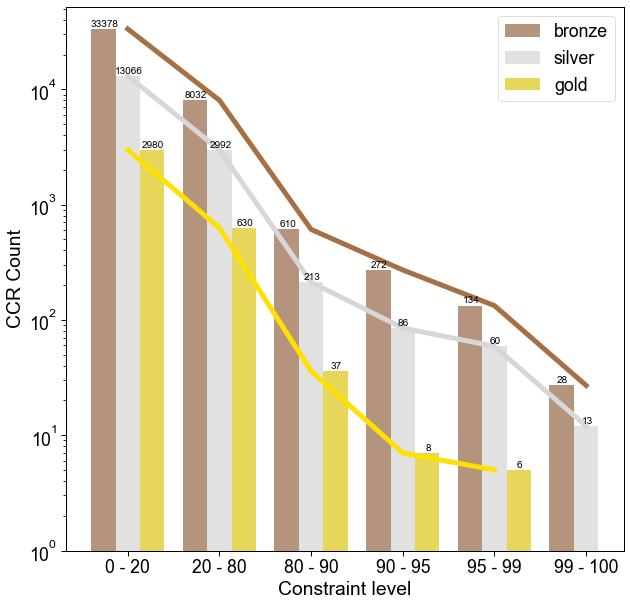

In [409]:

def show_values_on_bars(axs, i=0, fontsize=10, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
#             print(p)
            _x = p.get_x() + p.get_width() / 2 + 0.01
#             print(p.get_height())
#             if p.get_height() >= 1:
            _y = p.get_y() + ((p.get_height() / 2))  + (p.get_height() * 0.55)
#             elif p.get_height() < 1:
#                 _y = p.get_y() + (p.get_height() / 2) + p.get_height() * 0.2
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            print(value, type(value))
            if value != 'nan':
                ax.text(_x, _y, str(round(int(value) + 1, 2)), ha="center", fontsize=fontsize, rotation=rotation, color='black')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
                
f, ax = plt.subplots(figsize=(10,10))
t = exotic_ccrs_variants[['Type', 'CCRS_bins', 'CCRS_CCR_percentile']].groupby(['Type', 'CCRS_bins']).count().reset_index()
# g = sns.FacetGrid(data=t, col='Type', hue='Type', sharey=False, height=10, palette={'No\nthreshold' : "#2d3436", 'bronze' : "#A77044", 'silver' : "#D7D7D7", 'gold': "#FEE101"})
ax = sns.barplot(data=t, x='CCRS_bins', y='CCRS_CCR_percentile', hue='Type', alpha=0.75, palette={'No\nthreshold' : "#2d3436", 'bronze' : "#A77044", 'silver' : "#D7D7D7", 'gold': "#FEE101"})

sns.lineplot(data=t, x='CCRS_bins', y='CCRS_CCR_percentile', hue='Type', lw=5, legend=False, palette={'No\nthreshold' : "#2d3436", 'bronze' : "#A77044", 'silver' : "#D7D7D7", 'gold': "#FEE101"})
# for a in g.axes.ravel():
show_values_on_bars(ax)    
plt.yscale('log')
plt.ylim(ymin=1)
plt.xlabel('Constraint level')
plt.ylabel('CCR Count')
plt.legend(loc='upper right')


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


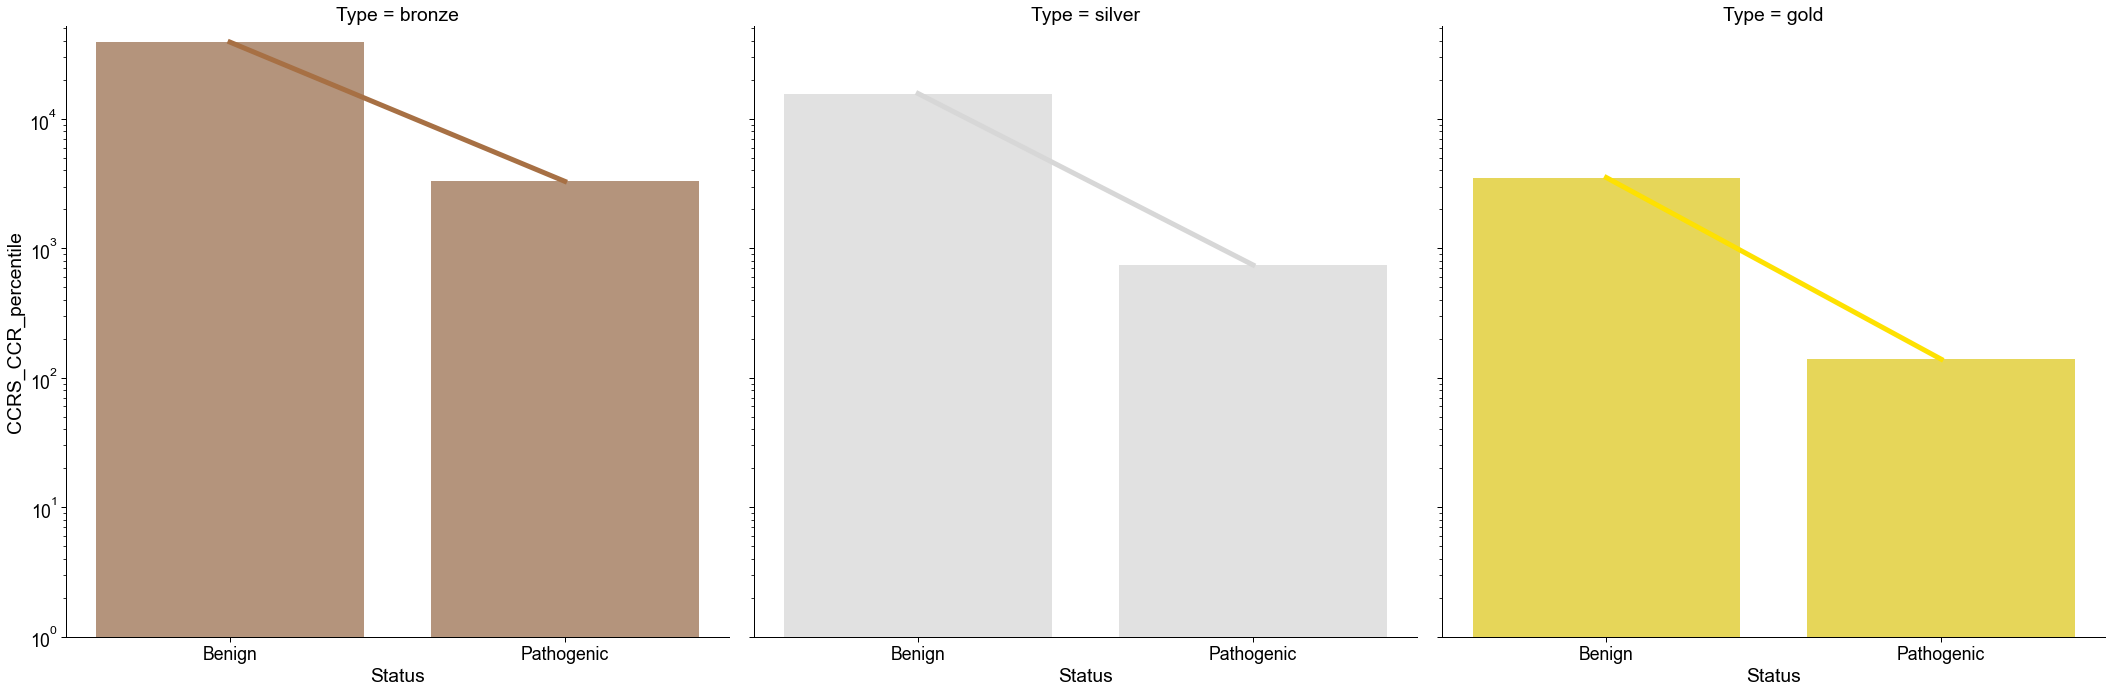

In [380]:

t = exotic_ccrs_variants[['Type', 'Status', 'CCRS_CCR_percentile']].groupby(['Type', 'Status']).count().reset_index()
g = sns.FacetGrid(data=t, col='Type', hue='Type', height=10, palette={'No\nthreshold' : "#2d3436", 'bronze' : "#A77044", 'silver' : "#D7D7D7", 'gold': "#FEE101"})
g.map(sns.barplot, 'Status', 'CCRS_CCR_percentile', alpha=0.75)
g.map(sns.lineplot, 'Status', 'CCRS_CCR_percentile', lw=5, )
for a in g.axes.ravel():
    
    a.set_yscale('log')
    a.set_ylim(ymin=1)

39155 <class 'str'>
3293 <class 'str'>
15680 <class 'str'>
744 <class 'str'>
3517 <class 'str'>
139 <class 'str'>


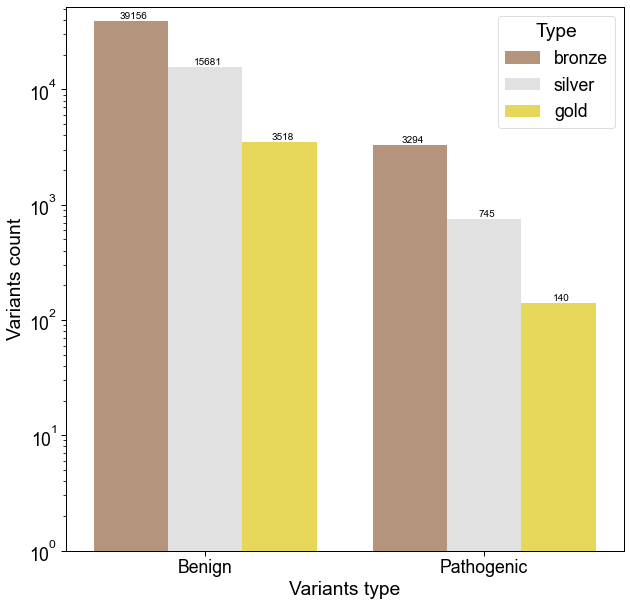

In [410]:
f, ax = plt.subplots(figsize=(10,10))
t = exotic_ccrs_variants[['Type', 'Status', 'CCRS_CCR_percentile']].groupby(['Type', 'Status']).count().reset_index()
# g = sns.FacetGrid(data=t, col='Type', hue='Type', sharey=False, height=10, palette={'No\nthreshold' : "#2d3436", 'bronze' : "#A77044", 'silver' : "#D7D7D7", 'gold': "#FEE101"})
ax = sns.barplot(data=t, x='Status', y='CCRS_CCR_percentile', hue='Type', alpha=0.75, palette={'No\nthreshold' : "#2d3436", 'bronze' : "#A77044", 'silver' : "#D7D7D7", 'gold': "#FEE101"})

# sns.lineplot(data=t, x='Status', y='CCRS_CCR_percentile', hue='Type', lw=5, legend=False, palette={'No\nthreshold' : "#2d3436", 'bronze' : "#A77044", 'silver' : "#D7D7D7", 'gold': "#FEE101"})
# for a in g.axes.ravel():
    
plt.yscale('log')
plt.ylim(ymin=1)
plt.ylabel('Variants count')
plt.xlabel('Variants type')
show_values_on_bars(ax)

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


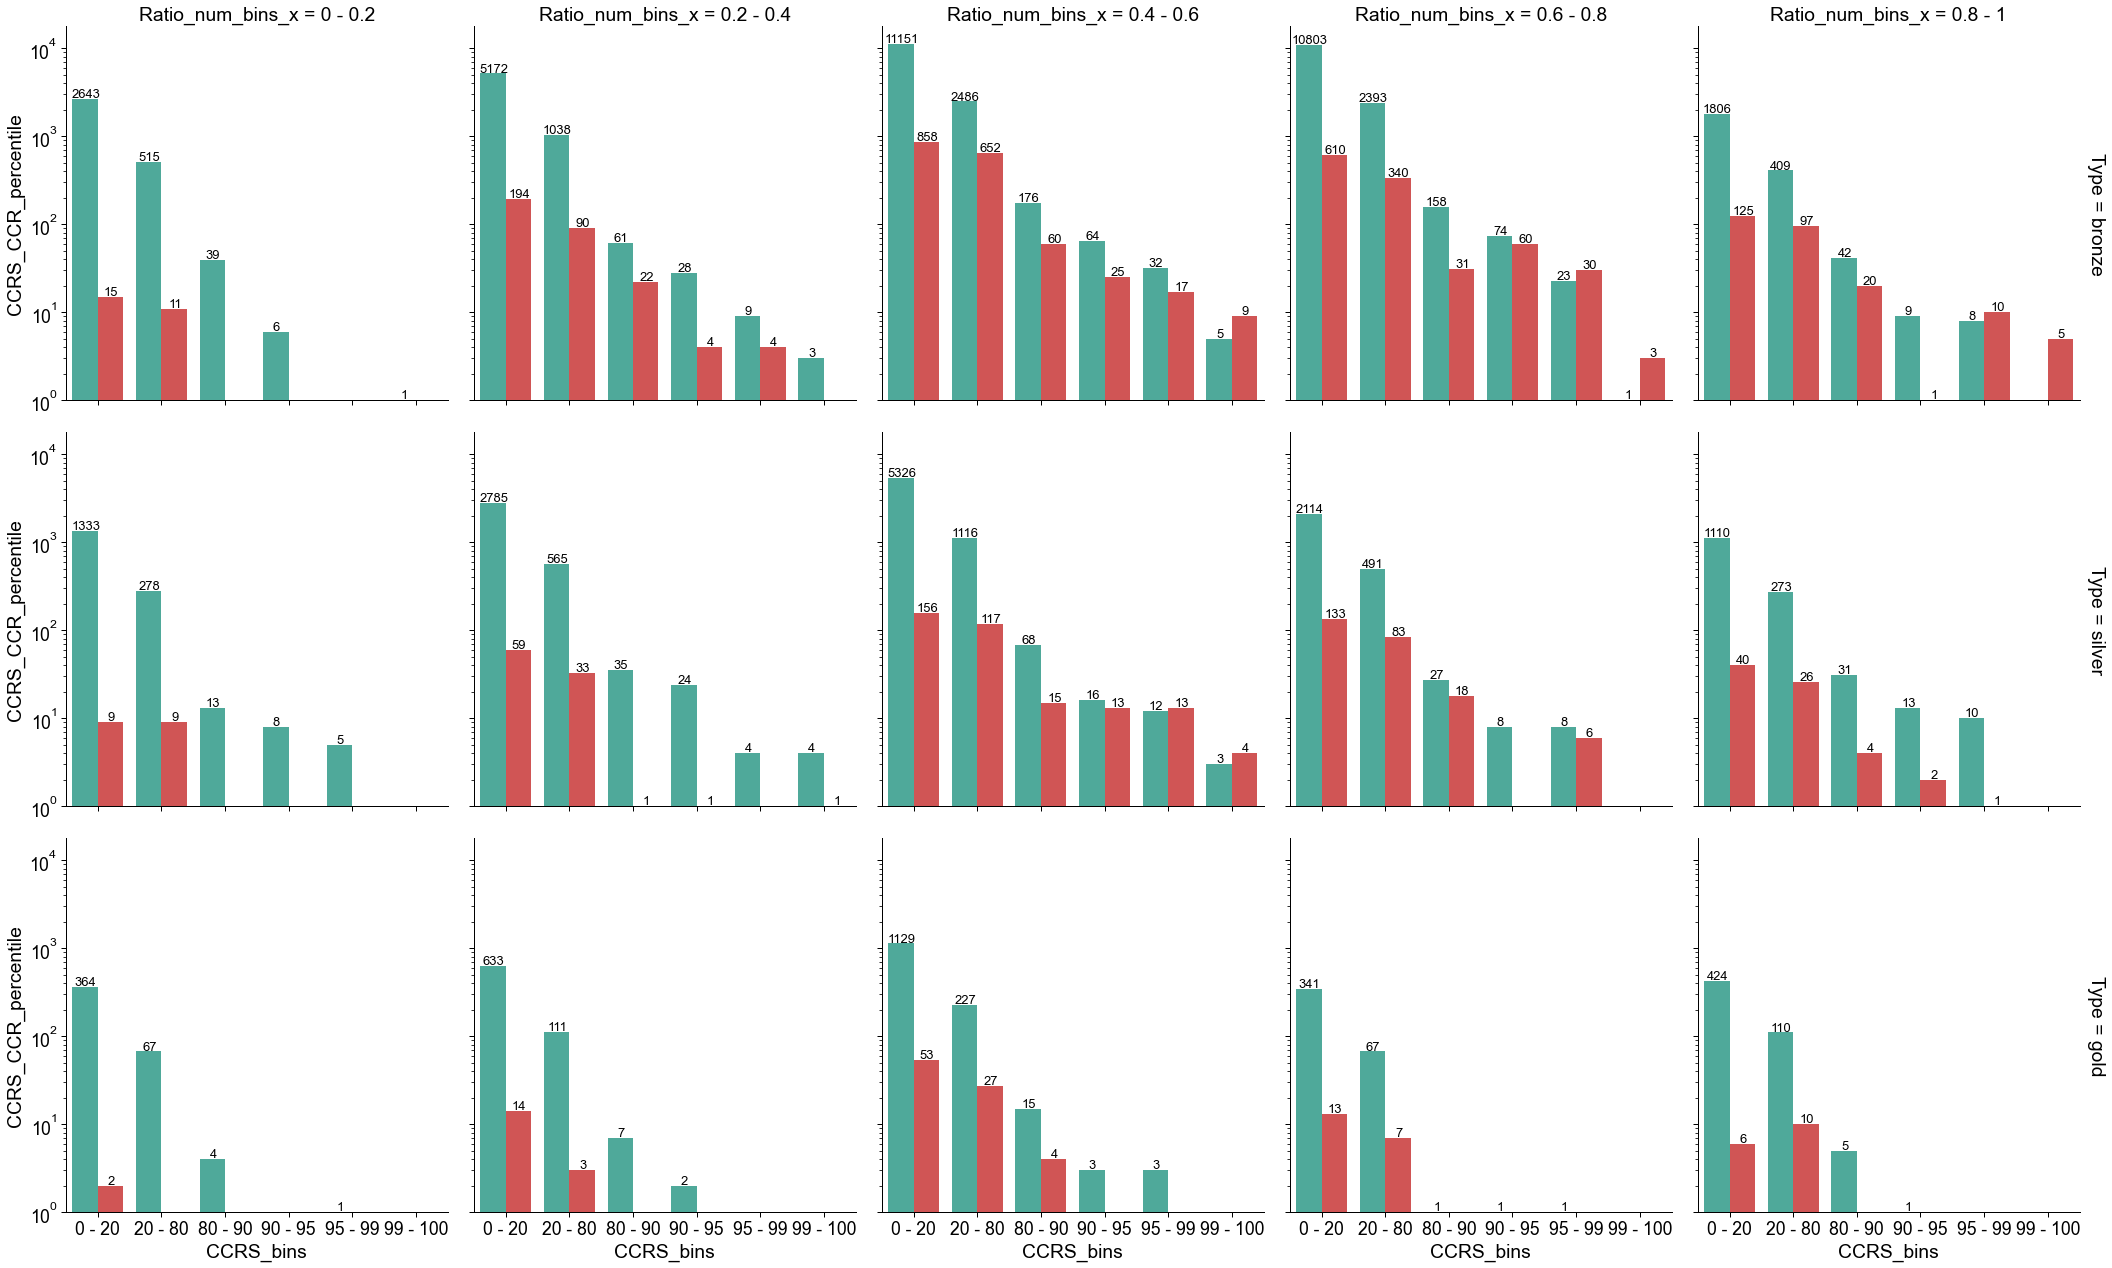

In [428]:
def show_values_on_bars(axs, i=0, fontsize=13, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2 + 0.01
#             if p.get_height() >= 1:
            _y = p.get_y() + ((p.get_height() / 2))  + (p.get_height() * 0.55)
#             elif p.get_height() < 1:
#                 _y = p.get_y() + (p.get_height() / 2) + p.get_height() * 0.2
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            if value != 'nan':
                ax.text(_x, _y, str(round(int(value), 2)), ha="center", fontsize=fontsize, rotation=rotation, color='black')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

sns.set_context('paper', font_scale=2)
t = exotic_ccrs_variants[['Type', 'CCRS_bins', 'Ratio_num_bins_x', 'Status',  'CCRS_CCR_percentile']].groupby(['Type', 'CCRS_bins', 'Ratio_num_bins_x', 'Status']).count().reset_index()
g = sns.FacetGrid(data=t, row='Type', col='Ratio_num_bins_x', height=6, margin_titles=True)
g.map(sns.barplot, 'CCRS_bins', 'CCRS_CCR_percentile', 'Status',  alpha=0.75, palette=["#00A087FF", '#DC0000FF'])
# g.map(sns.lineplot, 'Status', 'CCRS_CCR_percentile', lw=5, )
for a in g.axes.ravel():
    
    a.set_yscale('log')
    a.set_ylim(ymin=1)
    show_values_on_bars(a)

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


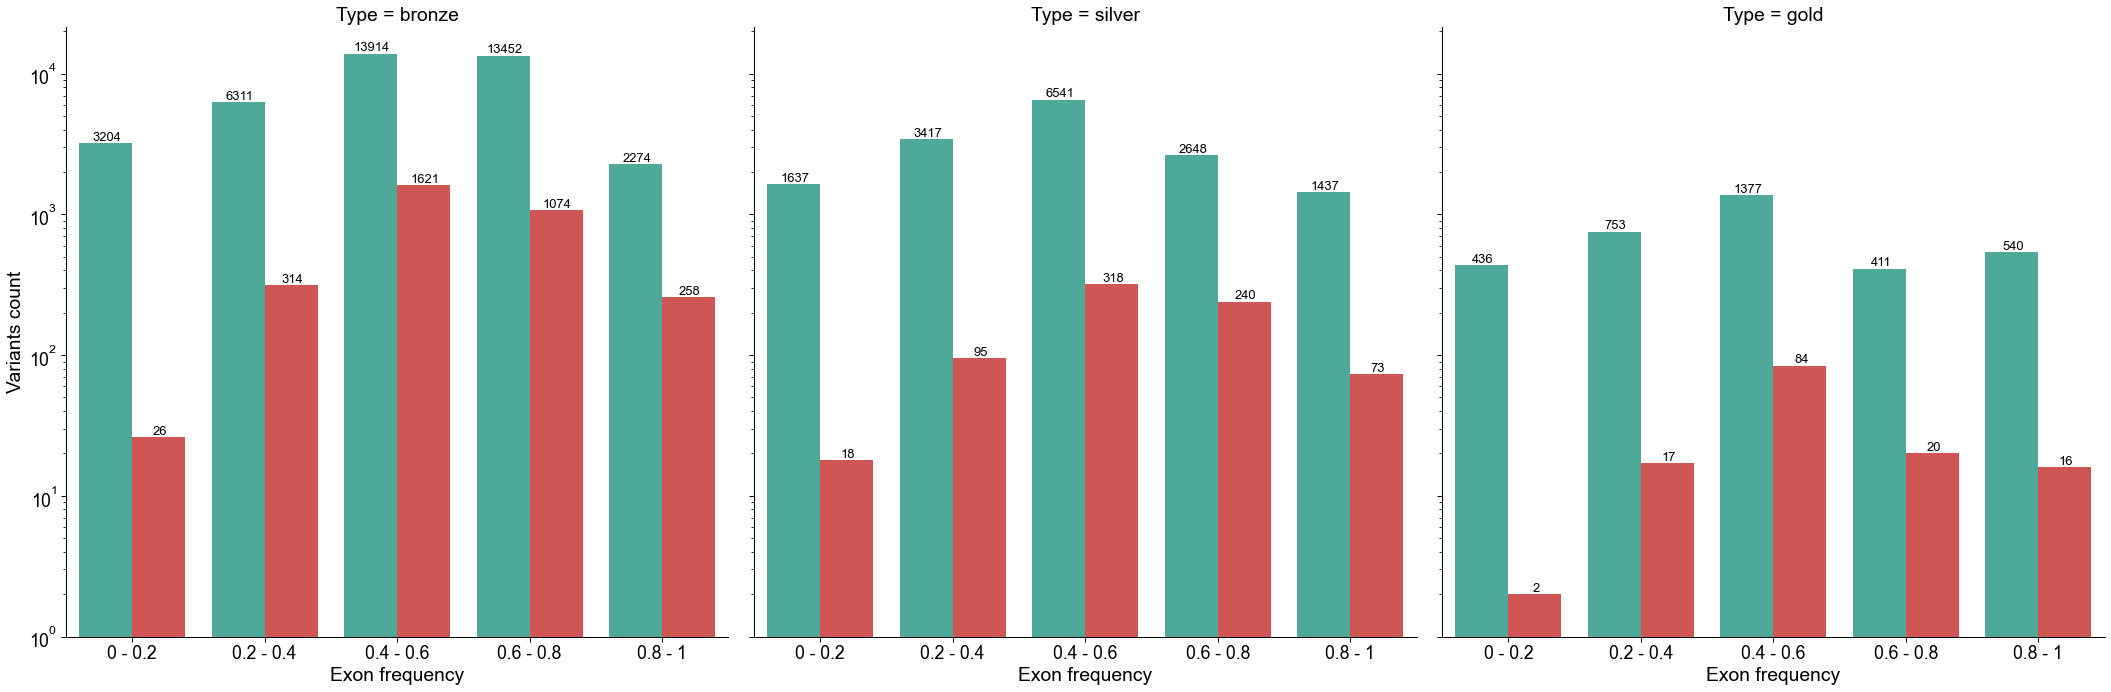

In [425]:
def show_values_on_bars(axs, i=0, fontsize=13, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2 + 0.01
#             if p.get_height() >= 1:
            _y = p.get_y() + ((p.get_height() / 2))  + (p.get_height() * 0.55)
#             elif p.get_height() < 1:
#                 _y = p.get_y() + (p.get_height() / 2) + p.get_height() * 0.2
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            if value != np.nan:
                ax.text(_x, _y, str(round(int(value) , 2)), ha="center", fontsize=fontsize, rotation=rotation, color='black')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

t = exotic_ccrs_variants[['Type', 'CCRS_bins', 'Ratio_num_bins_x', 'Status',  'CCRS_CCR_percentile']].groupby(['Type', 'Ratio_num_bins_x', 'Status']).count().reset_index()
g = sns.FacetGrid(data=t, col='Type',  height=10)
g.map(sns.barplot, 'Ratio_num_bins_x', 'CCRS_CCR_percentile', 'Status',  alpha=0.75, palette=["#00A087FF", '#DC0000FF'])
# g.map(sns.lineplot, 'Status', 'CCRS_CCR_percentile', lw=5, )
for j, a in enumerate(g.axes.ravel()):
    
    a.set_yscale('log')
    a.set_ylim(ymin=1)
    show_values_on_bars(a)
    a.set_xlabel('Exon frequency')
    if j == 0:
        a.set_ylabel('Variants count')

In [111]:
exotic = pd.read_parquet('/gstock/EXOTIC/data/EXOTIC/EXOTIC_tissues_ok.parquet')
# exotic["Exotic_Max"] = exotic.filter(regex='exotic').apply(lambda r: max(r.dropna()) if r.dropna().shape[0] > 0 else np.nan, axis=1)
# # exotic = exotic.rename({'Exon' : 'ranges'}, axis=1)
exotic = exotic.loc[exotic['OK'].str.len() > 0]
exotic['Exon'] = exotic['MAP'].apply(lambda r: r.split('_')[1])
exotic['Start'] = exotic['Exon'].apply(lambda r: r.split('-')[0])
exotic['Stop'] = exotic['Exon'].apply(lambda r: r.split('-')[1])
exotic['Start'] = exotic['Start'].astype(int)
exotic['Stop'] = exotic['Stop'].astype(int)
exotic['Length'] = exotic['Stop'] - exotic['Start']
exotic['Type'] = exotic[['OK_bronze', 'OK_silver', 'OK_gold']].apply(lambda r: [e for e, a in zip(['bronze', 'silver', 'gold'], r)  if len(a) > 0], axis=1)
exotic = exotic.explode('Type')
exotic


,MAP,Ratio_num,mRNA_nb,symbol,Adipose - Subcutaneous_exotic,Adipose - Visceral (Omentum)_exotic,Adrenal Gland_exotic,Artery - Aorta_exotic,Artery - Coronary_exotic,Artery - Tibial_exotic,...,pext_OK,OK_bronze,OK_silver,OK_gold,OK,Exon,Start,Stop,Length,Type
12,A2ML1_8997768-8997770,0.500000,2,A2ML1,0.326105,0.326105,0.326105,0.326105,0.326105,0.326105,...,"[Brain - Amygdala, Brain - Anterior cingulate ...","[Cervix - Endocervix, Uterus, Brain - Cerebell...",[],[],"[Cervix - Endocervix, Uterus, Brain - Cerebell...",8997768-8997770,8997768,8997770,2,bronze
13,AAAS_53708535-53708633,0.500000,2,AAAS,0.444111,0.654152,0.641317,0.235796,0.285570,0.218994,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[Whole Blood],[Cells - EBV-transformed lymphocytes],[],"[Whole Blood, Cells - EBV-transformed lymphocy...",53708535-53708633,53708535,53708633,98,bronze
13,AAAS_53708535-53708633,0.500000,2,AAAS,0.444111,0.654152,0.641317,0.235796,0.285570,0.218994,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[Whole Blood],[Cells - EBV-transformed lymphocytes],[],"[Whole Blood, Cells - EBV-transformed lymphocy...",53708535-53708633,53708535,53708633,98,silver
17,ABCA12_215896620-215896651,0.500000,2,ABCA12,NaN,NaN,NaN,NaN,NaN,NaN,...,[Cervix - Ectocervix],[],[],[Cervix - Ectocervix],[Cervix - Ectocervix],215896620-215896651,215896620,215896651,31,gold
26,ABCA2_139922527-139922592,0.500000,2,ABCA2,0.602375,0.531109,0.465133,0.848154,0.751631,0.884308,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[],[Cells - Cultured fibroblasts],[],[Cells - Cultured fibroblasts],139922527-139922592,139922527,139922592,65,silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15247,ZNF644_91403042-91403647,0.333333,3,ZNF644,0.529722,0.574844,0.475086,0.450758,0.580294,0.655881,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[Cells - Cultured fibroblasts, Muscle - Skeletal]",[],[],"[Cells - Cultured fibroblasts, Muscle - Skeletal]",91403042-91403647,91403042,91403647,605,bronze
15248,ZNF644_91403829-91406866,0.333333,3,ZNF644,0.529722,0.574844,0.475086,0.450758,0.580294,0.655881,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[Cells - Cultured fibroblasts, Muscle - Skeletal]",[],[],"[Cells - Cultured fibroblasts, Muscle - Skeletal]",91403829-91406866,91403829,91406866,3037,bronze
15249,ZNF644_91447888-91447910,0.333333,3,ZNF644,0.529722,0.574844,0.475086,0.450758,0.580294,0.655881,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[Cells - Cultured fibroblasts, Muscle - Skeletal]",[],[],"[Cells - Cultured fibroblasts, Muscle - Skeletal]",91447888-91447910,91447888,91447910,22,bronze
15250,ZNF711_84522284-84522421,0.500000,2,ZNF711,0.630747,0.477823,0.419602,0.355678,0.475627,0.256453,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[Skin - Sun Exposed (Lower leg)],[],[],[Skin - Sun Exposed (Lower leg)],84522284-84522421,84522284,84522421,137,bronze


In [112]:
exotic['Type'] = pd.Categorical(exotic['Type'], categories=['bronze', 'silver', 'gold'], ordered=True)
exotic


,MAP,Ratio_num,mRNA_nb,symbol,Adipose - Subcutaneous_exotic,Adipose - Visceral (Omentum)_exotic,Adrenal Gland_exotic,Artery - Aorta_exotic,Artery - Coronary_exotic,Artery - Tibial_exotic,...,pext_OK,OK_bronze,OK_silver,OK_gold,OK,Exon,Start,Stop,Length,Type
12,A2ML1_8997768-8997770,0.500000,2,A2ML1,0.326105,0.326105,0.326105,0.326105,0.326105,0.326105,...,"[Brain - Amygdala, Brain - Anterior cingulate ...","[Cervix - Endocervix, Uterus, Brain - Cerebell...",[],[],"[Cervix - Endocervix, Uterus, Brain - Cerebell...",8997768-8997770,8997768,8997770,2,bronze
13,AAAS_53708535-53708633,0.500000,2,AAAS,0.444111,0.654152,0.641317,0.235796,0.285570,0.218994,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[Whole Blood],[Cells - EBV-transformed lymphocytes],[],"[Whole Blood, Cells - EBV-transformed lymphocy...",53708535-53708633,53708535,53708633,98,bronze
13,AAAS_53708535-53708633,0.500000,2,AAAS,0.444111,0.654152,0.641317,0.235796,0.285570,0.218994,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[Whole Blood],[Cells - EBV-transformed lymphocytes],[],"[Whole Blood, Cells - EBV-transformed lymphocy...",53708535-53708633,53708535,53708633,98,silver
17,ABCA12_215896620-215896651,0.500000,2,ABCA12,NaN,NaN,NaN,NaN,NaN,NaN,...,[Cervix - Ectocervix],[],[],[Cervix - Ectocervix],[Cervix - Ectocervix],215896620-215896651,215896620,215896651,31,gold
26,ABCA2_139922527-139922592,0.500000,2,ABCA2,0.602375,0.531109,0.465133,0.848154,0.751631,0.884308,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[],[Cells - Cultured fibroblasts],[],[Cells - Cultured fibroblasts],139922527-139922592,139922527,139922592,65,silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15247,ZNF644_91403042-91403647,0.333333,3,ZNF644,0.529722,0.574844,0.475086,0.450758,0.580294,0.655881,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[Cells - Cultured fibroblasts, Muscle - Skeletal]",[],[],"[Cells - Cultured fibroblasts, Muscle - Skeletal]",91403042-91403647,91403042,91403647,605,bronze
15248,ZNF644_91403829-91406866,0.333333,3,ZNF644,0.529722,0.574844,0.475086,0.450758,0.580294,0.655881,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[Cells - Cultured fibroblasts, Muscle - Skeletal]",[],[],"[Cells - Cultured fibroblasts, Muscle - Skeletal]",91403829-91406866,91403829,91406866,3037,bronze
15249,ZNF644_91447888-91447910,0.333333,3,ZNF644,0.529722,0.574844,0.475086,0.450758,0.580294,0.655881,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[Cells - Cultured fibroblasts, Muscle - Skeletal]",[],[],"[Cells - Cultured fibroblasts, Muscle - Skeletal]",91447888-91447910,91447888,91447910,22,bronze
15250,ZNF711_84522284-84522421,0.500000,2,ZNF711,0.630747,0.477823,0.419602,0.355678,0.475627,0.256453,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[Skin - Sun Exposed (Lower leg)],[],[],[Skin - Sun Exposed (Lower leg)],84522284-84522421,84522284,84522421,137,bronze


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """


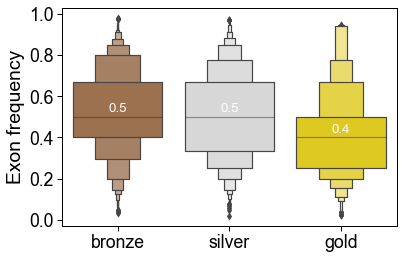

In [316]:
import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

medians = exotic.groupby(['Type'])['Ratio_num'].median()
vertical_offset = exotic['Ratio_num'].median() * 0.05 # offset from median for display

box_plot = sns.boxenplot(data=exotic, x='Type', y='Ratio_num', palette={'No\nthreshold' : "#2d3436", 'bronze' : "#A77044", 'silver' : "#D7D7D7", 'gold': "#FEE101"})
plt.ylabel("Exon frequency")
plt.xlabel('')

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')



In [61]:
exotic[['Type', 'Ratio_num']].pivot(columns='Type', values='Ratio_num').describe()

Type,bronze,gold,silver
count,4666.000000,668.000000,2903.000000
mean,0.544052,0.426809,0.520623
std,0.203744,0.210284,0.206767
min,0.033333,0.021739,0.020408
25%,0.400000,0.250000,0.333333
50%,0.500000,0.400000,0.500000
75%,0.666667,0.500000,0.666667
max,0.979592,0.947368,0.970588


In [113]:

bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = bins.copy()
labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]
exotic["Ratio_num_bins"] = pd.cut(t["Ratio_num"], bins=bins, labels=labels_ratio, include_lowest=True)
exotic

,MAP,Ratio_num,mRNA_nb,symbol,Adipose - Subcutaneous_exotic,Adipose - Visceral (Omentum)_exotic,Adrenal Gland_exotic,Artery - Aorta_exotic,Artery - Coronary_exotic,Artery - Tibial_exotic,...,OK_bronze,OK_silver,OK_gold,OK,Exon,Start,Stop,Length,Type,Ratio_num_bins
12,A2ML1_8997768-8997770,0.500000,2,A2ML1,0.326105,0.326105,0.326105,0.326105,0.326105,0.326105,...,"[Cervix - Endocervix, Uterus, Brain - Cerebell...",[],[],"[Cervix - Endocervix, Uterus, Brain - Cerebell...",8997768-8997770,8997768,8997770,2,bronze,0.4 - 0.6
13,AAAS_53708535-53708633,0.500000,2,AAAS,0.444111,0.654152,0.641317,0.235796,0.285570,0.218994,...,[Whole Blood],[Cells - EBV-transformed lymphocytes],[],"[Whole Blood, Cells - EBV-transformed lymphocy...",53708535-53708633,53708535,53708633,98,bronze,0.4 - 0.6
13,AAAS_53708535-53708633,0.500000,2,AAAS,0.444111,0.654152,0.641317,0.235796,0.285570,0.218994,...,[Whole Blood],[Cells - EBV-transformed lymphocytes],[],"[Whole Blood, Cells - EBV-transformed lymphocy...",53708535-53708633,53708535,53708633,98,silver,0.4 - 0.6
17,ABCA12_215896620-215896651,0.500000,2,ABCA12,NaN,NaN,NaN,NaN,NaN,NaN,...,[],[],[Cervix - Ectocervix],[Cervix - Ectocervix],215896620-215896651,215896620,215896651,31,gold,0.4 - 0.6
26,ABCA2_139922527-139922592,0.500000,2,ABCA2,0.602375,0.531109,0.465133,0.848154,0.751631,0.884308,...,[],[Cells - Cultured fibroblasts],[],[Cells - Cultured fibroblasts],139922527-139922592,139922527,139922592,65,silver,0.4 - 0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15247,ZNF644_91403042-91403647,0.333333,3,ZNF644,0.529722,0.574844,0.475086,0.450758,0.580294,0.655881,...,"[Cells - Cultured fibroblasts, Muscle - Skeletal]",[],[],"[Cells - Cultured fibroblasts, Muscle - Skeletal]",91403042-91403647,91403042,91403647,605,bronze,0.2 - 0.4
15248,ZNF644_91403829-91406866,0.333333,3,ZNF644,0.529722,0.574844,0.475086,0.450758,0.580294,0.655881,...,"[Cells - Cultured fibroblasts, Muscle - Skeletal]",[],[],"[Cells - Cultured fibroblasts, Muscle - Skeletal]",91403829-91406866,91403829,91406866,3037,bronze,0.2 - 0.4
15249,ZNF644_91447888-91447910,0.333333,3,ZNF644,0.529722,0.574844,0.475086,0.450758,0.580294,0.655881,...,"[Cells - Cultured fibroblasts, Muscle - Skeletal]",[],[],"[Cells - Cultured fibroblasts, Muscle - Skeletal]",91447888-91447910,91447888,91447910,22,bronze,0.2 - 0.4
15250,ZNF711_84522284-84522421,0.500000,2,ZNF711,0.630747,0.477823,0.419602,0.355678,0.475627,0.256453,...,[Skin - Sun Exposed (Lower leg)],[],[],[Skin - Sun Exposed (Lower leg)],84522284-84522421,84522284,84522421,137,bronze,0.4 - 0.6


Rectangle(xy=(-0.4, 0), width=0.266667, height=313, angle=0)
313.0
Rectangle(xy=(0.6, 0), width=0.266667, height=941, angle=0)
941.0
Rectangle(xy=(1.6, 0), width=0.266667, height=1534, angle=0)
1534.0
Rectangle(xy=(2.6, 0), width=0.266667, height=1485, angle=0)
1485.0
Rectangle(xy=(3.6, 0), width=0.266667, height=393, angle=0)
393.0
Rectangle(xy=(-0.133333, 0), width=0.266667, height=250, angle=0)
250.0
Rectangle(xy=(0.866667, 0), width=0.266667, height=654, angle=0)
654.0
Rectangle(xy=(1.86667, 0), width=0.266667, height=954, angle=0)
954.0
Rectangle(xy=(2.86667, 0), width=0.266667, height=797, angle=0)
797.0
Rectangle(xy=(3.86667, 0), width=0.266667, height=248, angle=0)
248.0
Rectangle(xy=(0.133333, 0), width=0.266667, height=92, angle=0)
92.0
Rectangle(xy=(1.13333, 0), width=0.266667, height=251, angle=0)
251.0
Rectangle(xy=(2.13333, 0), width=0.266667, height=185, angle=0)
185.0
Rectangle(xy=(3.13333, 0), width=0.266667, height=105, angle=0)
105.0
Rectangle(xy=(4.13333, 0), width=

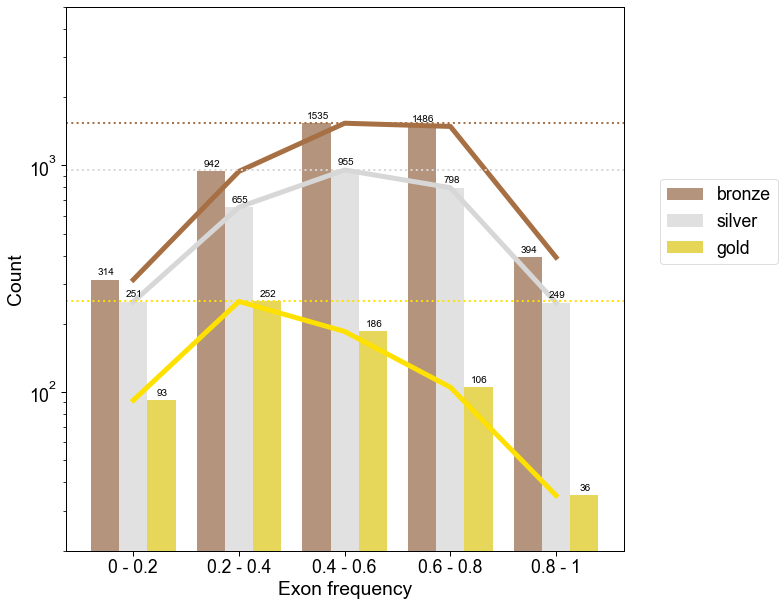

In [343]:


def show_values_on_bars(axs, i=0, fontsize=10, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2 + 0.01
            print(p.get_height())
#             if p.get_height() >= 1:
            _y = p.get_y() + ((p.get_height() / 2)) + p.get_height() * 0.55
#             elif p.get_height() < 1:
#                 _y = p.get_y() + (p.get_height() / 2) + p.get_height() * 0.2
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, str(round(int(value) + 1, 0)), ha="center", fontsize=fontsize, rotation=rotation, color='black')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

sns.set_context('paper', font_scale=2)
f, ax = plt.subplots(figsize=(10,10))
t = exotic.copy()
t2 = t[['Type', 'Ratio_num_bins', 'Ratio_num']].groupby(['Type', 'Ratio_num_bins']).count().reset_index()
ax = sns.barplot(data=t2, x='Ratio_num_bins', y='Ratio_num', hue='Type', alpha=0.75, palette={'No\nthreshold' : "#2d3436", 'bronze' : "#A77044", 'silver' : "#D7D7D7", 'gold': "#FEE101"})
sns.lineplot(data=t2, x='Ratio_num_bins', y='Ratio_num', hue='Type', legend=False, lw=5, palette={'No\nthreshold' : "#2d3436", 'bronze' : "#A77044", 'silver' : "#D7D7D7", 'gold': "#FEE101"})
ax.legend(bbox_to_anchor=(1.05,0.7,0,0))
# plt.legend(ax.legend())
plt.ylabel("Count")
plt.xlabel('Exon frequency')
# ax.set_xticks(rotation=45)
show_values_on_bars(ax)
plt.yscale('log')
plt.ylim(20,5000)
t2
for color, elem in zip(['#A77044', '#D7D7D7', '#FEE101'], t2.Type.unique()):
    ax.axhline(t2.loc[t2['Type'] == elem, 'Ratio_num'].max(), color=color, ls=':', lw=2)

In [95]:
t2 = t[['Type', 'Ratio_num_bins', 'Ratio_num']].groupby(['Type', 'Ratio_num_bins']).count().reset_index()
# t2['Ratio']= t2['Ratio_num'] / t2['Ratio_num'].groupby(level=0).sum()
t2

,Type,Ratio_num_bins,Ratio_num
0,bronze,0 - 0.2,313
1,bronze,0.2 - 0.4,941
2,bronze,0.4 - 0.6,1534
3,bronze,0.6 - 0.8,1485
4,bronze,0.8 - 1,393
5,gold,0 - 0.2,92
6,gold,0.2 - 0.4,251
7,gold,0.4 - 0.6,185
8,gold,0.6 - 0.8,105
9,gold,0.8 - 1,35


(0.0, 600.0)

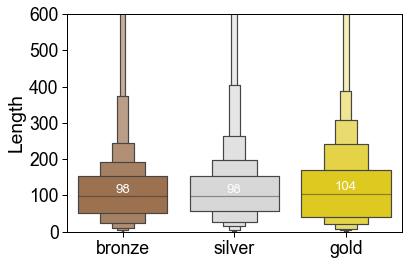

In [318]:
sns.set_context('paper', font_scale=2)
# f, ax = plt.subplots(figsize=(10,10))


medians = exotic.groupby(['Type'])['Length'].median()
vertical_offset = exotic['Length'].median() * 0.1 # offset from median for display

box_plot = sns.boxenplot(data=exotic, x='Type', y='Length', palette={'No\nthreshold' : "#2d3436", 'bronze' : "#A77044", 'silver' : "#D7D7D7", 'gold': "#FEE101"})

plt.ylabel("Length")
plt.xlabel('')

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

plt.ylim(0,600)


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


0
1
2
3
4


Ratio_num_bins  Type  
0 - 0.2         bronze     74.0
                silver     80.0
                gold       44.5
0.2 - 0.4       bronze     87.0
                silver     90.0
                gold      112.0
0.4 - 0.6       bronze    102.0
                silver    101.0
                gold      112.0
0.6 - 0.8       bronze    107.0
                silver    105.0
                gold      156.0
0.8 - 1         bronze     98.0
                silver     98.0
                gold      127.0
Name: Length, dtype: float64

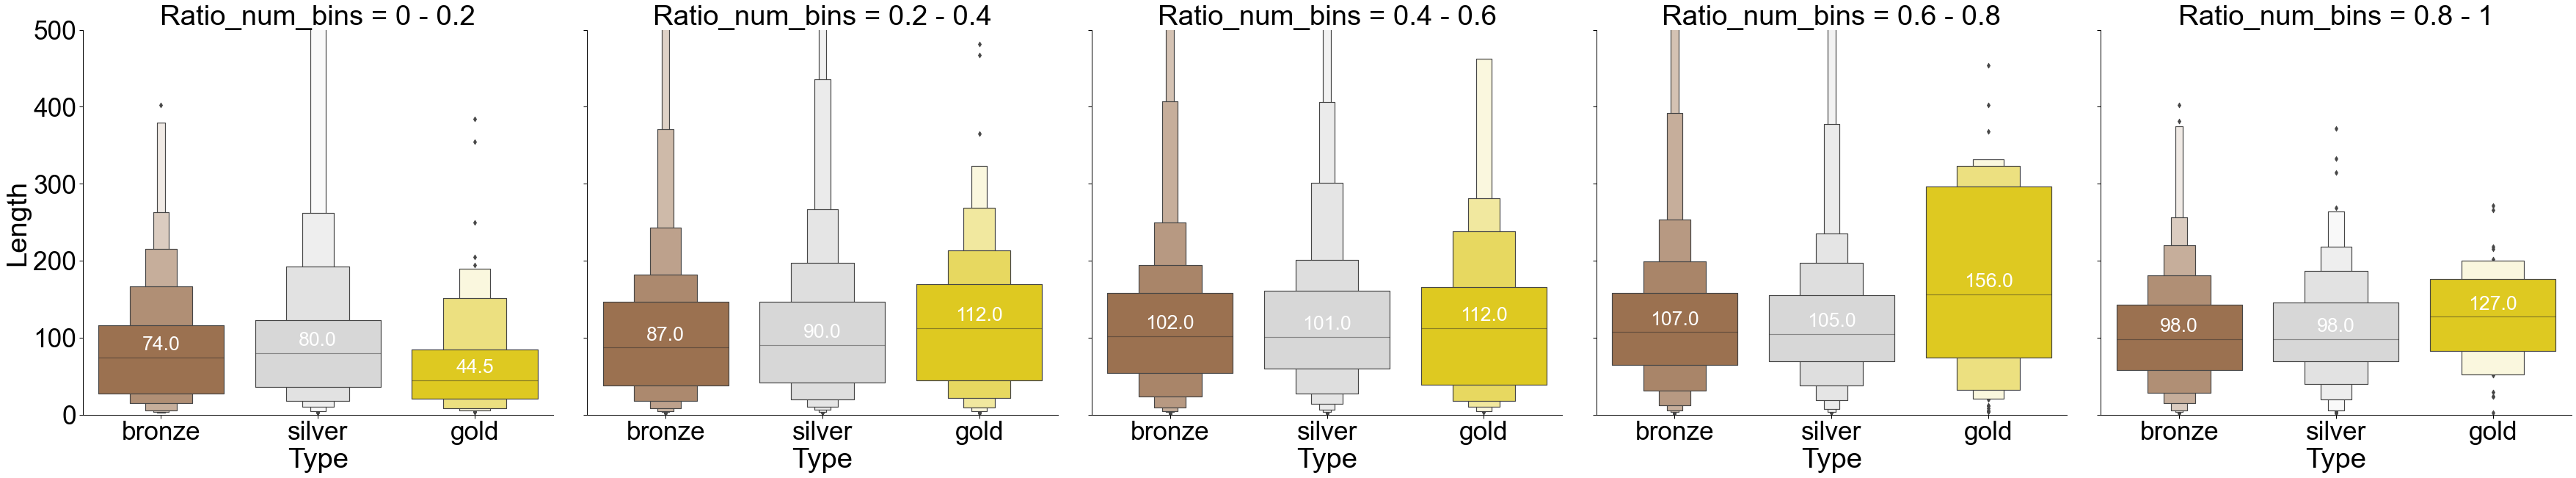

In [322]:


medians = exotic.groupby(['Ratio_num_bins', 'Type'])['Length'].median()
vertical_offset = exotic['Length'].median() * 0.1 # offset from median for display

sns.set_context('paper', font_scale=4)
g = sns.FacetGrid(data=exotic, col='Ratio_num_bins', height=10)
g.map(sns.boxenplot, 'Type', 'Length', palette={'No\nthreshold' : "#2d3436", 'bronze' : "#A77044", 'silver' : "#D7D7D7", 'gold': "#FEE101"})
for j, a in enumerate(g.axes.ravel()):
    print(j)
    a.set_ylim(0,500)
# box_plot = sns.boxenplot(data=exotic, x='Type', y='Length')

    for xtick in a.get_xticks():
        a.text(xtick,medians[3*j+xtick] + vertical_offset,medians[3*j+xtick], 
                horizontalalignment='center',size='x-small',color='w',weight='semibold')
medians
# plt.ylim(0,600)


In [329]:
t = pd.pivot_table(exotic, columns='Type', index='Ratio_num_bins', values='Length', aggfunc=[sum, np.median, min, max, np.std, np.mean,]).round(2)
t.to_excel('/gstock/EXOTIC/data/EXOTIC/stats_length_freq_thresholds.xlsx')
t


sum                median                  min              \
Type            bronze  silver   gold bronze silver   gold bronze silver gold   
Ratio_num_bins                                                                  
0 - 0.2          41058   43536   6567   74.0   80.0   44.5      2      2    3   
0.2 - 0.4       112728   81584  31600   87.0   90.0  112.0      1      2    1   
0.4 - 0.6       206770  141136  25042  102.0  101.0  112.0      1      1    3   
0.6 - 0.8       211694  114495  23117  107.0  105.0  156.0      1      2    3   
0.8 - 1          45016   29050   4446   98.0   98.0  127.0      1      1    2   

                  max                  std                    mean          \
Type           bronze silver  gold  bronze  silver    gold  bronze  silver   
Ratio_num_bins                                                               
0 - 0.2          7811   6454   522  573.10  612.53   84.77  131.18  174.14   
0.2 - 0.4        3153   3318   929  198.81  196.03  116.61  119.80  124.75   
0.4 - 0.6        4754   4754  1547  232.21  288.75  168.84  134.79  147.94   
0.6 - 0.8        5915   5915  3356  264.46  277.75  369.22  142.55  143.66   
0.8 - 1          1423    938   272  126.54   96.53   67.99  114.54  117.14   

                        
Type              gold  
Ratio_num_bins          
0 - 0.2          71.38  
0.2 - 0.4       125.90  
0.4 - 0.6       135.36  
0.6 - 0.8       220.16  
0.8 - 1         127.03

In [160]:
exotic

,MAP,Ratio_num,mRNA_nb,symbol,Adipose - Subcutaneous_exotic,Adipose - Visceral (Omentum)_exotic,Adrenal Gland_exotic,Artery - Aorta_exotic,Artery - Coronary_exotic,Artery - Tibial_exotic,...,OK_bronze,OK_silver,OK_gold,OK,Exon,Start,Stop,Length,Type,Ratio_num_bins
12,A2ML1_8997768-8997770,0.500000,2,A2ML1,0.326105,0.326105,0.326105,0.326105,0.326105,0.326105,...,"[Cervix - Endocervix, Uterus, Brain - Cerebell...",[],[],"[Cervix - Endocervix, Uterus, Brain - Cerebell...",8997768-8997770,8997768,8997770,2,bronze,0.4 - 0.6
13,AAAS_53708535-53708633,0.500000,2,AAAS,0.444111,0.654152,0.641317,0.235796,0.285570,0.218994,...,[Whole Blood],[Cells - EBV-transformed lymphocytes],[],"[Whole Blood, Cells - EBV-transformed lymphocy...",53708535-53708633,53708535,53708633,98,bronze,0.4 - 0.6
13,AAAS_53708535-53708633,0.500000,2,AAAS,0.444111,0.654152,0.641317,0.235796,0.285570,0.218994,...,[Whole Blood],[Cells - EBV-transformed lymphocytes],[],"[Whole Blood, Cells - EBV-transformed lymphocy...",53708535-53708633,53708535,53708633,98,silver,0.4 - 0.6
17,ABCA12_215896620-215896651,0.500000,2,ABCA12,NaN,NaN,NaN,NaN,NaN,NaN,...,[],[],[Cervix - Ectocervix],[Cervix - Ectocervix],215896620-215896651,215896620,215896651,31,gold,0.4 - 0.6
26,ABCA2_139922527-139922592,0.500000,2,ABCA2,0.602375,0.531109,0.465133,0.848154,0.751631,0.884308,...,[],[Cells - Cultured fibroblasts],[],[Cells - Cultured fibroblasts],139922527-139922592,139922527,139922592,65,silver,0.4 - 0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15247,ZNF644_91403042-91403647,0.333333,3,ZNF644,0.529722,0.574844,0.475086,0.450758,0.580294,0.655881,...,"[Cells - Cultured fibroblasts, Muscle - Skeletal]",[],[],"[Cells - Cultured fibroblasts, Muscle - Skeletal]",91403042-91403647,91403042,91403647,605,bronze,0.2 - 0.4
15248,ZNF644_91403829-91406866,0.333333,3,ZNF644,0.529722,0.574844,0.475086,0.450758,0.580294,0.655881,...,"[Cells - Cultured fibroblasts, Muscle - Skeletal]",[],[],"[Cells - Cultured fibroblasts, Muscle - Skeletal]",91403829-91406866,91403829,91406866,3037,bronze,0.2 - 0.4
15249,ZNF644_91447888-91447910,0.333333,3,ZNF644,0.529722,0.574844,0.475086,0.450758,0.580294,0.655881,...,"[Cells - Cultured fibroblasts, Muscle - Skeletal]",[],[],"[Cells - Cultured fibroblasts, Muscle - Skeletal]",91447888-91447910,91447888,91447910,22,bronze,0.2 - 0.4
15250,ZNF711_84522284-84522421,0.500000,2,ZNF711,0.630747,0.477823,0.419602,0.355678,0.475627,0.256453,...,[Skin - Sun Exposed (Lower leg)],[],[],[Skin - Sun Exposed (Lower leg)],84522284-84522421,84522284,84522421,137,bronze,0.4 - 0.6


In [54]:
exotic.loc[(exotic['Length'] > 1000) & (exotic['Type'] == 'gold')]

,MAP,Ratio_num,mRNA_nb,symbol,Adipose - Subcutaneous_exotic,Adipose - Visceral (Omentum)_exotic,Adrenal Gland_exotic,Artery - Aorta_exotic,Artery - Coronary_exotic,Artery - Tibial_exotic,...,pext_OK,OK_bronze,OK_silver,OK_gold,OK,Exon,Start,Stop,Length,Type
11210,RNF213_78313001-78314156,0.500000,2,RNF213,0.412201,0.371267,0.490208,0.569370,0.517187,0.644120,...,[Cells - Cultured fibroblasts],[],[],[Cells - Cultured fibroblasts],[Cells - Cultured fibroblasts],78313001-78314156,78313001,78314156,1155,gold
11827,SH3PXD2B_171765373-171766920,0.500000,2,SH3PXD2B,0.574579,0.535947,0.317929,0.611224,0.575435,0.716197,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[Muscle - Skeletal],[],[Cells - EBV-transformed lymphocytes],"[Muscle - Skeletal, Cells - EBV-transformed ly...",171765373-171766920,171765373,171766920,1547,gold
13575,TNXB_32063388-32065226,0.666667,3,TNXB,0.446490,0.432018,0.072622,0.648103,0.475684,0.630192,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[],[],[Cells - Cultured fibroblasts],[Cells - Cultured fibroblasts],32063388-32065226,32063388,32065226,1838,gold
15051,XIRP1_39227580-39230936,0.666667,3,XIRP1,0.423397,0.423397,0.372125,0.582704,0.718860,0.455055,...,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[],[],[Bladder],[Bladder],39227580-39230936,39227580,39230936,3356,gold


In [ ]:
ccrs = pd.read_parquet('')

In [156]:
exotic = pd.read_parquet('/home/weber/PycharmProjects/ExoCarto/data/clean/2_expression/RefSeq_PEXT_pct.parquet')
exotic["Exotic_Max"] = exotic.filter(regex='exotic').apply(lambda r: max(r.dropna()) if r.dropna().shape[0] > 0 else np.nan, axis=1)
exotic = exotic.rename({'Exon' : 'ranges'}, axis=1)


In [191]:
exotic


,symbol,ensg,HGNC,ranges,Ratio_num,mRNA_nb,MAP,mean_proportion,Adipose - Subcutaneous_exotic,Adipose - Visceral (Omentum)_exotic,...,Skin - Sun Exposed (Lower leg)_pextvalue,Small Intestine - Terminal Ileum_pextvalue,Spleen_pextvalue,Stomach_pextvalue,Testis_pextvalue,Thyroid_pextvalue,Uterus_pextvalue,Vagina_pextvalue,Whole Blood_pextvalue,Exotic_Max
0,A1CF,ENSG00000148584,24086,52573798-52573822,0.375000,8,A1CF_52573798-52573822,0.030960,NaN,NaN,...,0.00000,0.16110,NaN,0.00000,0.00000,0.00000,NaN,NaN,NaN,0.949734
1,A1CF,ENSG00000148584,24086,52610425-52610547,0.375000,8,A1CF_52610425-52610547,0.006439,NaN,NaN,...,0.00000,0.05501,NaN,0.00000,0.00000,0.00000,NaN,NaN,NaN,0.957909
2,A1CF,ENSG00000148584,24086,52619602-52619700,0.625000,8,A1CF_52619602-52619700,0.979670,NaN,NaN,...,1.00000,0.94499,NaN,1.00000,0.66667,1.00000,NaN,NaN,NaN,0.574705
3,A2ML1,ENSG00000166535,23336,8975248-8975309,0.500000,2,A2ML1_8975248-8975309,0.695140,0.735143,0.735143,...,0.54618,1.00000,1.00000,1.00000,0.20471,1.00000,0.43478,0.69070,1.0000,0.735143
4,A2ML1,ENSG00000166535,23336,8975778-8975961,0.500000,2,A2ML1_8975778-8975961,0.695140,0.735143,0.735143,...,0.54618,1.00000,1.00000,1.00000,0.20471,1.00000,0.43478,0.69070,1.0000,0.735143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45049,ZYG11A,ENSG00000203995,32058,53308556-53308645,0.500000,2,ZYG11A_53308556-53308645,0.160540,0.372350,0.372350,...,0.16667,0.00000,0.53846,0.00000,0.80328,0.80000,0.00000,0.00000,NaN,0.939435
45050,ZYG11A,ENSG00000203995,32058,53320137-53320302,0.500000,2,ZYG11A_53320137-53320302,0.160540,0.372350,0.372350,...,0.16667,0.00000,0.53846,0.00000,0.80328,0.80000,0.00000,0.00000,NaN,0.939435
45051,ZYG11A,ENSG00000203995,32058,53322670-53323421,0.500000,2,ZYG11A_53322670-53323421,0.160540,0.372350,0.372350,...,0.16667,0.00000,0.53846,0.00000,0.80328,0.80000,0.00000,0.00000,NaN,0.939435
45052,ZYG11A,ENSG00000203995,32058,53326403-53326421,0.500000,2,ZYG11A_53326403-53326421,0.160540,0.372350,0.372350,...,0.16667,0.00000,0.53846,0.00000,0.80328,0.80000,0.00000,0.00000,NaN,0.939435


In [161]:
merge_exotic = pd.merge(exotic[['ranges', 'Exotic_Max']], merge_ccrs_variants, on='ranges')
bins = [0, 0.9, 0.95, 0.99, 1]
labels = bins.copy()
labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]
merge_exotic["Exotic_Max_bins"] = pd.cut(merge_exotic["Exotic_Max"], bins=bins, labels=labels_ratio, include_lowest=True)
merge_exotic

,ranges,Exotic_Max,ALT,CHROM,CLNREVSTAT,Gene,ID,MC,POS,REF,...,VAR_ID,alleleid,rs,Ratio_num,Const_Alt,Ratio_num_bins,CCRS_ranges,CCRS_bins,CCRS_CCR_percentile,Exotic_Max_bins
0,8975248-8975309,0.735143,T,12,"criteria_provided,_single_submitter",A2ML1,12_8975257_C_T,nonsense,8975257.0,C,...,12_8975257_C_['T'],608923.0,1409944554,0.5,Alt,0.4 - 0.6,8975256-8975257,0 - 20,0.000000,0 - 0.9
1,8975248-8975309,0.735143,T,12,"criteria_provided,_single_submitter",A2ML1,12_8975257_C_T,nonsense,8975257.0,C,...,12_8975257_C_['T'],608923.0,1409944554,0.5,Alt,0.4 - 0.6,8975257-8975259,0 - 20,7.271167,0 - 0.9
2,8975248-8975309,0.735143,C,12,None,A2ML1,12_8975273_T_C,None,8975273.0,T,...,None,NaN,None,0.5,Alt,0.4 - 0.6,8975272-8975273,0 - 20,0.000000,0 - 0.9
3,8975248-8975309,0.735143,C,12,None,A2ML1,12_8975273_T_C,None,8975273.0,T,...,None,NaN,None,0.5,Alt,0.4 - 0.6,8975273-8975277,0 - 20,17.128583,0 - 0.9
4,8975248-8975309,0.735143,G,12,None,A2ML1,12_8975281_C_G,None,8975281.0,C,...,None,NaN,None,0.5,Alt,0.4 - 0.6,8975280-8975281,0 - 20,0.000000,0 - 0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127046,34851067-34851248,0.887161,C,17,None,ZNHIT3,17_34851211_T_C,None,34851211.0,T,...,None,NaN,None,0.5,Alt,0.4 - 0.6,34851211-34851213,0 - 20,4.294850,0 - 0.9
127047,34851067-34851248,0.887161,C,17,None,ZNHIT3,17_34851219_G_C,None,34851219.0,G,...,None,NaN,None,0.5,Alt,0.4 - 0.6,34851218-34851219,0 - 20,0.000000,0 - 0.9
127048,34851067-34851248,0.887161,C,17,None,ZNHIT3,17_34851219_G_C,None,34851219.0,G,...,None,NaN,None,0.5,Alt,0.4 - 0.6,34851219-34851228,20 - 80,43.349160,0 - 0.9
127049,34851067-34851248,0.887161,A,17,None,ZNHIT3,17_34851237_G_A,None,34851237.0,G,...,None,NaN,None,0.5,Alt,0.4 - 0.6,34851236-34851237,0 - 20,0.000000,0 - 0.9


In [192]:
merge_exotic.groupby(['Exotic_Max_bins', 'Status']).size().reset_index().pivot(index='Status', columns='Exotic_Max_bins', values=0)

Exotic_Max_bins,0 - 0.9,0.9 - 0.95,0.95 - 0.99,0.99 - 1
Status,,,,
Benign,58626,28595,26124,5165
Pathogenic,4899,1922,1357,363


0 - 0.9 99 - 100 1.3740041233090041 58626 4899 59884 3642
0.9 - 0.95 99 - 100 0.9130678475950045 28595 1922 89915 6619
0.95 - 0.99 99 - 100 0.6680054611056606 26124 1357 92386 7184
0.99 - 1 99 - 100 0.9740731218292318 5165 363 113345 8178


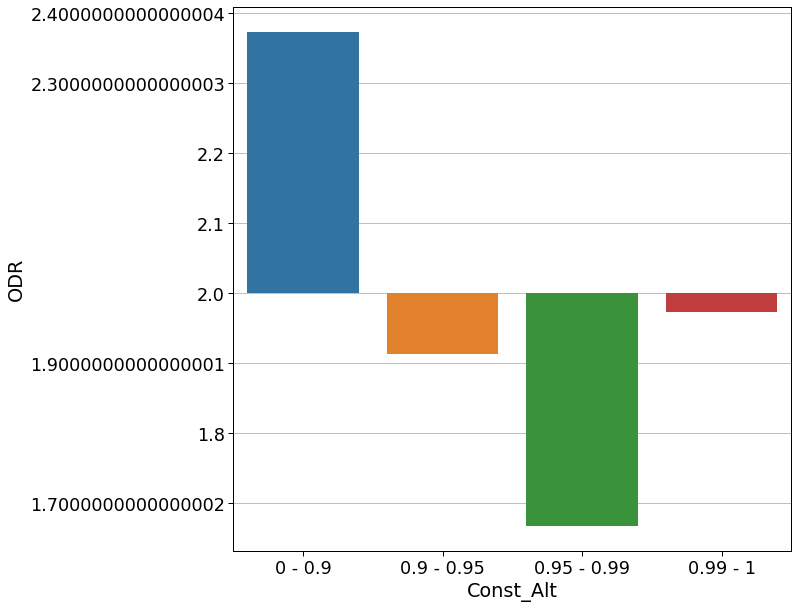

In [194]:
d = merge_exotic.groupby(['Exotic_Max_bins', 'Status']).size().reset_index().pivot(index='Status', columns='Exotic_Max_bins', values=0).to_dict()
# d = tmp_merge_cons_ccrs_variants.groupby(['Const_Alt', 'Status', 'CCRS_bins', 'phyloCSF_score_bins']).size()
new_d = d

# d = pd.pivot_table(merge_ccrs_variants.groupby(['Const_Alt', 'Status', 'CCRS_bins', 'phyloCSF_score_bins']).size().reset_index(), index=['CCRS_bins', 'Status', 'phyloCSF_score_bins'], columns='Const_Alt', values=0).to_dict()
# new_d = collections.defaultdict(dict)
# for k in d:
#     new_d[k] = dict()
#     for sub_k, v in d[k].items():
# #         if sub_k[0] not in new_d[k]:
# #             new_d[k][sub_k[0]] = dict()
#         new_d[k][sub_k] = v
# d

odr_alt = list()
odr_const = list()
labels = list(d.keys())
labels

l = list()


for const_alt in new_d:
    b = new_d[const_alt]['Benign']
    p = new_d[const_alt]['Pathogenic']
    other_b = sum([new_d[e]['Benign'] for e in labels if new_d[e]['Benign'] != b])
    other_p= sum([new_d[e]['Pathogenic'] for e in labels if new_d[e]['Pathogenic'] != p])
    odr = ((p / b) / (other_p / other_b))
    print(const_alt, ccr, odr, b, p, other_b, other_p)
    l.append(
        {
            'Const_Alt' : const_alt,
            'CCRS_bins' : ccr,
            'ODR' : odr,
        }        
    )

t = pd.DataFrame(l)
t['ODR'] = t['ODR'] -1 
# t

f, ax = plt.subplots(figsize=(10,10))
ax.set_axisbelow(True)
ax.grid(True, axis='y')
sns.barplot(data=t, x='Const_Alt', y='ODR', bottom=1)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x+1))
# plt.yscale('log')



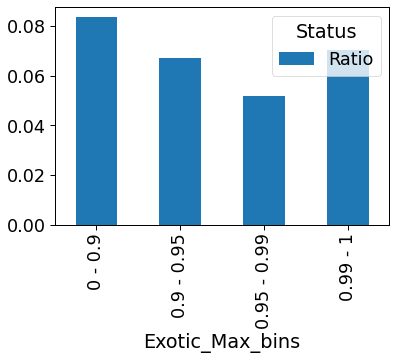

In [195]:
tmp = merge_exotic.groupby(['Exotic_Max_bins', 'Status']).size().reset_index().pivot(index='Exotic_Max_bins', columns='Status', values=0)
tmp['Ratio'] = tmp['Pathogenic'] / tmp['Benign']
tmp[['Ratio']].plot.bar()


In [167]:
merge_exotic.groupby(['Exotic_Max_bins', 'CCRS_bins', 'Status']).size()

Exotic_Max_bins  CCRS_bins  Status    
0 - 0.9          0 - 20     Benign        24966
                            Pathogenic     6792
                 20 - 80    Benign        19526
                            Pathogenic     4296
                 80 - 90    Benign         1443
                            Pathogenic      866
                 90 - 95    Benign          639
                            Pathogenic      784
                 95 - 99    Benign          317
                            Pathogenic      335
                 99 - 100   Benign           98
                            Pathogenic      103
0.9 - 0.95       0 - 20     Benign        18572
                            Pathogenic     3317
                 20 - 80    Benign        14366
                            Pathogenic     2675
                 80 - 90    Benign          452
                            Pathogenic      495
                 90 - 95    Benign          616
                            Pathogenic     1312
 

In [64]:
tmp_phylocsf_path = '/home/weber/PycharmProjects/ExoCarto/data/2_processed/phyloCSF_modified2.parquet'
df = pd.read_parquet(tmp_phylocsf_path)
bins = [df.phyloCSF_score.min(), -100, 1000, df.phyloCSF_score.max()]
labels = bins.copy()
labels_ratio = [str(round(labels[j], 1)) + " - " + str(round(labels[j + 1], 1)) for j in range(len(labels) - 1)]
# df["phyloCSF_score_bins"] = pd.cut(df["phyloCSF_score"], bins=bins, labels=labels_ratio, include_lowest=True)
df.loc[df['phyloCSF_score'] < -100, "phyloCSF_score_bins"] = 'Unconserved'
df.loc[df['phyloCSF_score'] > 1000, "phyloCSF_score_bins"] = 'Conserved'
df.loc[(df['phyloCSF_score'] > -100) & (df['phyloCSF_score'] < 1000), "phyloCSF_score_bins"] = 'Standard'
df

,ENSEMBLE_GENEID,Chrom,Start,End,TAG,HGNC,Gene,phyloCSF_ranges,phyloCSF_score,ranges,Ratio_num,Const_Alt,Ratio_num_bins,phyloCSF_score_bins
0,ENSG00000148584,10,52569654,52569802,CCDS,24086,A1CF,52569654-52569802,829.2853,52569654-52569802,1.0,Const,0.8 - 1,Standard
1,ENSG00000148584,10,52570800,52570936,CCDS,24086,A1CF,52570800-52570936,491.1834,52570800-52570936,1.0,Const,0.8 - 1,Standard
2,ENSG00000148584,10,52573617,52573798,CCDS,24086,A1CF,52573617-52573798,473.1124,52573617-52573798,1.0,Const,0.8 - 1,Standard
3,ENSG00000148584,10,52575766,52576039,CCDS,24086,A1CF,52575766-52576039,964.3430,52575766-52576039,1.0,Const,0.8 - 1,Standard
4,ENSG00000148584,10,52580312,52580409,CCDS,24086,A1CF,52580312-52580409,454.8371,52580312-52580409,1.0,Const,0.8 - 1,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194465,ENSG00000159840,7,143085860,143086038,CCDS,13200,ZYX,143085860-143086038,666.7179,143085860-143086038,1.0,Const,0.8 - 1,Standard
194466,ENSG00000159840,7,143086950,143087070,CCDS,13200,ZYX,143086950-143087070,728.2201,143086950-143087070,1.0,Const,0.8 - 1,Standard
194467,ENSG00000159840,7,143086950,143087070,CCDS,13200,ZYX,143086950-143087070,728.2201,143086950-143087070,1.0,Const,0.8 - 1,Standard
194468,ENSG00000159840,7,143086950,143087070,CCDS,13200,ZYX,143086950-143087070,728.2201,143086950-143087070,1.0,Const,0.8 - 1,Standard


Rectangle(xy=(-0.4, 0), width=0.8, height=1.10428, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=0.830322, angle=0)


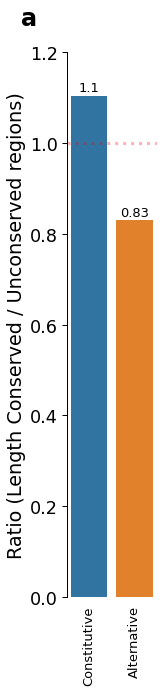

In [65]:
# Custom function to draw the diff bars


def show_values_on_bars(axs, i=0, fontsize=10, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height()) + 0.01
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, str(round(float(value), 2)), ha="center", fontsize=fontsize, rotation=rotation, color='black')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)



def label_diff(i,j,text,X,Y):
    x = (X[i]+X[j])/2
    y = max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-', 'shrinkA':0.1,'shrinkB':0.1,'linewidth':2}
    ax.annotate(text, xy=(X[i] +0.05,y+0.22), zorder=10, fontsize=13)
    ax.annotate('', xy=(X[i],y+0.1), xytext=(X[j],y+0.1), arrowprops=props)

df22 = df.loc[df['phyloCSF_score_bins'] != 'Standard']
df2 = df22.groupby(['Const_Alt', 'phyloCSF_score_bins']).size().reset_index().pivot(index='Const_Alt', columns='phyloCSF_score_bins')
df2.columns = df2.columns.droplevel(0)
# df2 = df2.T

df2['Ratio'] = df2['Conserved'] / df2['Unconserved']
# df2['Const'] = (df2['Const']-df2['Const'].min())/(df2['Const'].max() - df2['Const'].min())
# df2['Alt'] = (df2['Alt']-df2['Alt'].min())/(df2['Alt'].max() - df2['Alt'].min())
# sns.heatmap(df2, annot=True)
sns.set_context('paper', font_scale=2)
f, ax = plt.subplots(figsize=(3,10))

# df2['Ratio'].plot.bar(ax=ax)
ax.set_axisbelow(True)
plt.axhline(1, color='r', alpha=0.3, lw=3, linestyle=':')

p = sns.barplot(data=df2.reset_index().sort_values(by='Const_Alt', ascending=False), y='Ratio', x='Const_Alt')
# plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Ratio (Length Conserved / Unconserved regions)')
ax.set_xticklabels(['Constitutive', 'Alternative'])

ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False, labelsize=13, rotation=90)
legend = p.get_legend()
# label_diff(0,1,'p=0.0370',[0,1],(0.81, 1.05))
show_values_on_bars(ax, i=2, fontsize=13)
plt.ylim(0,1.2)

ax.text(-0.5, 1.05, 'a', transform=ax.transAxes, size=24, weight='bold')
plt.tight_layout()
# legend.set_title('')
# legend.texts[0].set_text("Constitutive")
# legend.texts[1].set_text("Alternative")
# df2

Rectangle(xy=(-0.4, 0), width=0.8, height=0.225275, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=0.432473, angle=0)
Rectangle(xy=(1.6, 0), width=0.8, height=0.638608, angle=0)
Rectangle(xy=(2.6, 0), width=0.8, height=1.41579, angle=0)
Rectangle(xy=(3.6, 0), width=0.8, height=2.22819, angle=0)


Text(-0.25, 1.05, 'b')

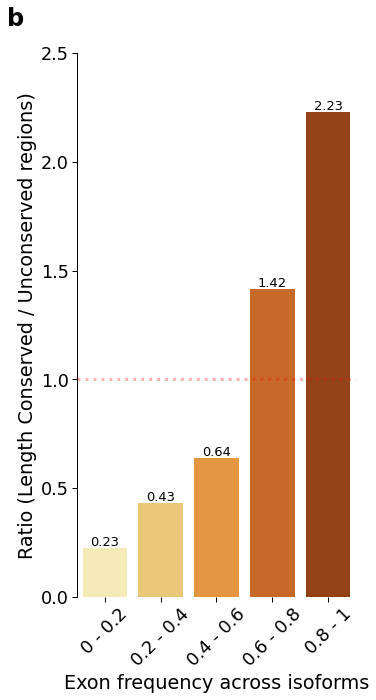

In [66]:
df2 = df.loc[df['phyloCSF_score_bins'] != 'Standard']
# df2['Ratio_num_bins'] = df2['Ratio_num_bins'].cat.add_categories(['1'])
# df2.loc[df2['Const_Alt'] == 'Const', 'Ratio_num_bins'] = '1'
df2 = df2.loc[df2['Const_Alt'] == 'Alt'].groupby(['Ratio_num_bins', 'phyloCSF_score_bins']).size().reset_index().pivot(index='Ratio_num_bins', columns='phyloCSF_score_bins')
df2.columns = df2.columns.droplevel(0)
# df2 = df2.T
df2['Ratio'] = df2['Conserved'] / df2['Unconserved']
# df2['Const'] = (df2['Const']-df2['Const'].min())/(df2['Const'].max() - df2['Const'].min())
# df2['Alt'] = (df2['Alt']-df2['Alt'].min())/(df2['Alt'].max() - df2['Alt'].min())
# sns.heatmap(df2, annot=True)
# ax = df2[['Conserved', 'Unconserved']].plot.bar()
# ax2 = ax.twinx()
sns.set_context('paper', font_scale=2)

f, ax = plt.subplots(figsize=(5,10))
ax.set_axisbelow(True)
# ax.grid(True, axis='y')
df2 = df2.reset_index()
# df2['Ratio_nu']
p = sns.barplot(data=df2, y='Ratio', x='Ratio_num_bins', palette='YlOrBr')
plt.axhline(1, color='r', alpha=0.3, ls=':', lw=3)
plt.xticks(rotation=45)
plt.ylabel('Ratio (Length Conserved / Unconserved regions)')
plt.xlabel('Exon frequency across isoforms')
plt.ylim(0,2.5)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
show_values_on_bars(ax, i=2, fontsize=13)
ax.text(-0.25, 1.05, 'b', transform=ax.transAxes, size=24, weight='bold')

# df2[['Ratio']].plot.bar(ax=ax, color=sns.color_palette('Paired'))



In [ ]:
f, ax = plt.subplots()

In [197]:
merge_cons_ccrs_variants = pd.merge(merge_ccrs_variants, df[['phyloCSF_score', 'phyloCSF_score_bins', 'ranges']], on='ranges')


In [198]:
tmp_merge_cons_ccrs_variants = merge_cons_ccrs_variants.loc[merge_cons_ccrs_variants['phyloCSF_score_bins'] != 'Standard']
tmp_merge_cons_ccrs_variants

,ALT,CHROM,CLNREVSTAT,Gene,ID,MC,POS,REF,RS_STARS,Real_Status,...,ranges,rs,Ratio_num,Const_Alt,Ratio_num_bins,CCRS_ranges,CCRS_bins,CCRS_CCR_percentile,phyloCSF_score,phyloCSF_score_bins
268,A,12,None,A2ML1,12_9002268_G_A,None,9002268.0,G,NaN,None,...,9002265-9002355,None,1.0,Const,0.8 - 1,9002267-9002268,0 - 20,0.000000,-128.3333,Unconserved
269,A,12,None,A2ML1,12_9002268_G_A,None,9002268.0,G,NaN,None,...,9002265-9002355,None,1.0,Const,0.8 - 1,9002268-9002271,0 - 20,11.809070,-128.3333,Unconserved
270,T,12,None,A2ML1,12_9002287_C_T,None,9002287.0,C,NaN,None,...,9002265-9002355,None,1.0,Const,0.8 - 1,9002286-9002287,0 - 20,0.000000,-128.3333,Unconserved
271,T,12,None,A2ML1,12_9002287_C_T,None,9002287.0,C,NaN,None,...,9002265-9002355,None,1.0,Const,0.8 - 1,9002287-9002289,0 - 20,7.271167,-128.3333,Unconserved
272,G,12,None,A2ML1,12_9002290_A_G,None,9002290.0,A,NaN,None,...,9002265-9002355,None,1.0,Const,0.8 - 1,9002289-9002290,0 - 20,0.000000,-128.3333,Unconserved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408453,A,5,None,TERT,5_1294484_G_A,None,1294484.0,G,NaN,None,...,1293428-1294781,None,1.0,Const,0.8 - 1,1294430-1294492,95 - 99,96.444464,2567.9141,Conserved
408454,A,5,"criteria_provided,_single_submitter",TERT,5_1294654_G_A,missense_variant,1294654.0,G,1.0,Likely_pathogenic,...,1293428-1294781,None,1.0,Const,0.8 - 1,1294619-1294754,99 - 100,99.712331,2567.9141,Conserved
408455,C,5,"criteria_provided,_single_submitter",TERT,5_1294656_G_C,missense_variant,1294656.0,G,1.0,Likely_pathogenic,...,1293428-1294781,1579598699,1.0,Const,0.8 - 1,1294619-1294754,99 - 100,99.712331,2567.9141,Conserved
408456,T,5,None,TERT,5_1294741_C_T,None,1294741.0,C,NaN,None,...,1293428-1294781,None,1.0,Const,0.8 - 1,1294619-1294754,99 - 100,99.712331,2567.9141,Conserved


In [199]:
tmp_merge_cons_ccrs_variants = tmp_merge_cons_ccrs_variants.drop('HPO', axis=1).drop_duplicates()
tmp_merge_cons_ccrs_variants

KeyError: "['HPO'] not found in axis"

In [509]:
tmp_merge_cons_ccrs_variants

,Gene,VAR_ID,MC,Status,Real_Status,RS_STARS,CLNREVSTAT,rs,alleleid,POS,...,CCRS_ranges,CCRS_bins,CCRS_CCR_percentile,CHROM,REF,ALT,ID,_merge,phyloCSF_score,phyloCSF_score_bins
94,A2ML1,12_9002268_G_['T'],missense_variant,Benign,Benign/Likely_benign,2.0,"criteria_provided,_multiple_submitters,_no_con...",148198269,552732.0,9002268,...,9002267-9002268,0 - 20,0.000000,12,G,T,12_9002268_G_T,left_only,-128.3333,Unconserved
95,A2ML1,12_9002268_G_['T'],missense_variant,Benign,Benign/Likely_benign,2.0,"criteria_provided,_multiple_submitters,_no_con...",148198269,552732.0,9002268,...,9002268-9002271,0 - 20,11.809070,12,G,T,12_9002268_G_T,left_only,-128.3333,Unconserved
292,ACOX1,17_73944415_CA_['C'],frameshift_variant,Pathogenic,Likely_pathogenic,1.0,"criteria_provided,_single_submitter",797045080,205187.0,73944415,...,73944403-73944420,20 - 80,74.120032,17,CA,C,17_73944415_CA_C,left_only,1198.9593,Conserved
293,ACOX1,17_73944473_C_['A'],synonymous_variant,Benign,Benign,1.0,"criteria_provided,_single_submitter",79605652,715717.0,73944473,...,73944469-73944473,0 - 20,16.450020,17,C,A,17_73944473_C_A,left_only,1198.9593,Conserved
294,ACOX1,17_73944473_C_['A'],synonymous_variant,Benign,Benign,1.0,"criteria_provided,_single_submitter",79605652,715717.0,73944473,...,73944473-73944478,0 - 20,0.000000,17,C,A,17_73944473_C_A,left_only,1198.9593,Conserved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43488768,TCOF1,5_149772954_T_['A'],missense_variant,Benign,Benign,1.0,"criteria_provided,_single_submitter",139081024,302447.0,149772954,...,149772954-149772958,0 - 20,15.303842,5,T,A,5_149772954_T_A,left_only,-177.2804,Unconserved
43488769,TCOF1,5_149772955_GA_['G'],frameshift_variant,Pathogenic,Pathogenic,1.0,"criteria_provided,_single_submitter",1581210464,633650.0,149772955,...,149772954-149772958,0 - 20,15.303842,5,GA,G,5_149772955_GA_G,left_only,-177.2804,Unconserved
43488770,TCOF1,5_149773043_G_['A'],missense_variant,Benign,Benign/Likely_benign,2.0,"criteria_provided,_multiple_submitters,_no_con...",137960641,298297.0,149773043,...,149773042-149773043,0 - 20,0.000000,5,G,A,5_149773043_G_A,left_only,-177.2804,Unconserved
43488771,TCOF1,5_149773043_G_['A'],missense_variant,Benign,Benign/Likely_benign,2.0,"criteria_provided,_multiple_submitters,_no_con...",137960641,298297.0,149773043,...,149773043-149773044,0 - 20,0.000000,5,G,A,5_149773043_G_A,left_only,-177.2804,Unconserved


In [200]:
d = tmp_merge_cons_ccrs_variants.groupby(['Const_Alt', 'Status', 'CCRS_bins', 'phyloCSF_score_bins']).size()
d

# d = pd.pivot_table(merge_ccrs_variants.groupby(['Const_Alt', 'Status', 'CCRS_bins', 'phyloCSF_score_bins']).size().reset_index(), index=['CCRS_bins', 'Status', 'phyloCSF_score_bins'], columns='Const_Alt', values=0).to_dict()
# new_d = collections.defaultdict(dict)
# for k in d:
#     new_d[k] = dict()
#     for sub_k, v in d[k].items():
#         if sub_k[0] not in new_d[k]:
#             new_d[k][sub_k[0]] = dict()
#         new_d[k][sub_k[0]][sub_k[1]] = v
# odr_alt = list()
# odr_const = list()
# labels = list(new_d['Alt'].keys())

# l = list()


# for const_alt in new_d:
#     for ccr in new_d[const_alt]:
#         b = new_d[const_alt][ccr]['Benign']
#         p = new_d[const_alt][ccr]['Pathogenic']
#         other_b = sum([new_d[const_alt][e]['Benign'] for e in labels if new_d[const_alt][e]['Benign'] != b])
#         other_p= sum([new_d[const_alt][e]['Pathogenic'] for e in labels if new_d[const_alt][e]['Pathogenic'] != p])
#         odr = ((p / b) / (other_p / other_b)) - 1
# #         print(const_alt, ccr, odr)
#         l.append(
#             {
#                 'Const_Alt' : const_alt,
#                 'CCRS_bins' : ccr,
#                 'ODR' : odr,
#             }        
#         )

# t = pd.DataFrame(l)
# t['ODR'] = t['ODR'] -1 
# # t

# f, ax = plt.subplots(figsize=(10,10))
# ax.set_axisbelow(True)
# ax.grid(True, axis='y')
# sns.barplot(data=t, x='CCRS_bins', y='ODR', hue='Const_Alt')
# plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x+1))
# # plt.yscale('lor')



Const_Alt  Status      CCRS_bins  phyloCSF_score_bins
Alt        Benign      0 - 20     Conserved              21184
                                  Unconserved             3281
                       20 - 80    Conserved               4677
                                  Unconserved              639
                       80 - 90    Conserved                294
                                  Unconserved               19
                       90 - 95    Conserved                 70
                                  Unconserved                5
                       95 - 99    Conserved                 37
                                  Unconserved               15
                       99 - 100   Conserved                  3
           Pathogenic  0 - 20     Conserved                708
                                  Unconserved               90
                       20 - 80    Conserved                545
                                  Unconserved               46
 

In [286]:
df2

phyloCSF_score_bins,Conserved,Unconserved,Ratio
Const_Alt,,,
Alt,2344,2823,0.830322
Const,8133,7365,1.104277


In [313]:
pd.pivot_table(pd.merge(merge_df_variants, df22[['ranges', 'phyloCSF_score_bins']], on='ranges').drop(['HPO'], axis=1).drop_duplicates().groupby(['Status', 'Const_Alt', 'phyloCSF_score_bins']).size().reset_index(), index=['phyloCSF_score_bins', 'Status'], columns='Const_Alt', values=0)

Const_Alt                        Alt  Const
phyloCSF_score_bins Status                 
Conserved           Benign      6743  14937
                    Pathogenic  2699   4919
Unconserved         Benign      1333   1701
                    Pathogenic   326    678

Alt 5175 2695 887 326 Conserved 0.41694970510654694
Alt 887 326 5175 2695 Unconserved -0.2942586484219598
Const 11255 4909 1130 678 Conserved -0.2730638234858581
Const 1130 678 11255 4909 Unconserved 0.3756365858627011


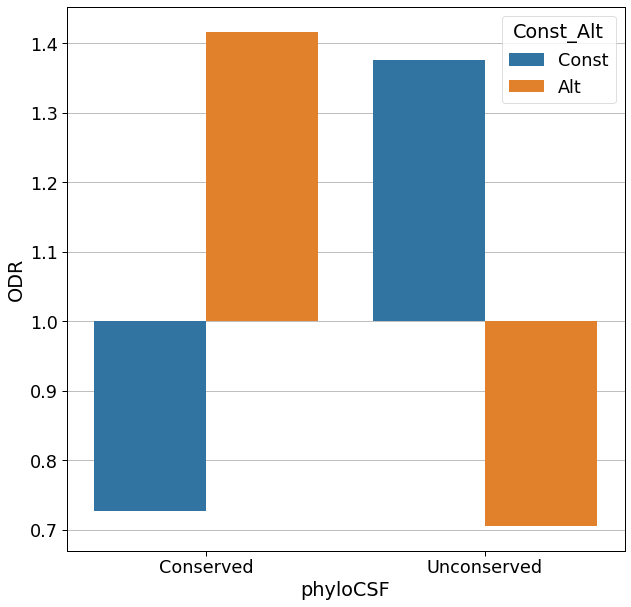

In [201]:
d = pd.pivot_table(pd.merge(merge_df_variants, df22[['ranges', 'phyloCSF_score_bins']], on='ranges').drop(['HPO'], axis=1).drop_duplicates().groupby(['Status', 'Const_Alt', 'phyloCSF_score_bins']).size().reset_index(), index=['phyloCSF_score_bins', 'Status'], columns='Const_Alt', values=0).to_dict()
new_d = collections.defaultdict(dict)
for k in d:
    new_d[k] = dict()
    for sub_k, v in d[k].items():
        if sub_k[0] not in new_d[k]:
            new_d[k][sub_k[0]] = dict()
        new_d[k][sub_k[0]][sub_k[1]] = v
new_d
odr_alt = list()
odr_const = list()
labels = list(new_d[list(new_d.keys())[0]].keys())

l = list()


for const_alt in new_d:
    for ccr in new_d[const_alt]:
        b = new_d[const_alt][ccr]['Benign']
        p = new_d[const_alt][ccr]['Pathogenic']
        other_b = sum([new_d[const_alt][e]['Benign'] for e in labels if new_d[const_alt][e]['Benign'] != b])
        other_p= sum([new_d[const_alt][e]['Pathogenic'] for e in labels if new_d[const_alt][e]['Pathogenic'] != p])
        odr = ((p / b) / (other_p / other_b))-1
        print(const_alt, b, p, other_b, other_p, ccr, odr)
        l.append(
            {
                'Const_Alt' : const_alt,
                'phyloCSF' : ccr,
                'ODR' : odr,
            }        
        )
t = pd.DataFrame(l)
# t['ODR'] = t['ODR'] -1 
# t

f, ax = plt.subplots(figsize=(10,10))
ax.set_axisbelow(True)
ax.grid(True, axis='y')
sns.barplot(data=t.sort_values(by='Const_Alt', ascending=False), x='phyloCSF', y='ODR', hue='Const_Alt')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: round(x+1, 2)))
# plt.yscale('lor')


In [329]:
d = pd.pivot_table(pd.merge(merge_df_variants.loc[merge_df_variants['Const_Alt'] == 'Alt'], df22[['ranges', 'phyloCSF_score_bins']], on='ranges').drop(['HPO'], axis=1).drop_duplicates().groupby(['Status', 'Ratio_num_bins', 'phyloCSF_score_bins']).size().reset_index(), index=['phyloCSF_score_bins', 'Status'], columns='Ratio_num_bins', values=0).to_dict()
new_d = collections.defaultdict(dict)
for k in d:
    new_d[k] = dict()
    for sub_k, v in d[k].items():
        if sub_k[0] not in new_d[k]:
            new_d[k][sub_k[0]] = dict()
        new_d[k][sub_k[0]][sub_k[1]] = v
new_d

defaultdict(dict,
            {'0 - 0.2': {'Conserved': {'Benign': 403, 'Pathogenic': 17},
              'Unconserved': {'Benign': 74, 'Pathogenic': 6}},
             '0.2 - 0.4': {'Conserved': {'Benign': 554, 'Pathogenic': 96},
              'Unconserved': {'Benign': 379, 'Pathogenic': 100}},
             '0.4 - 0.6': {'Conserved': {'Benign': 1999, 'Pathogenic': 892},
              'Unconserved': {'Benign': 545, 'Pathogenic': 144}},
             '0.6 - 0.8': {'Conserved': {'Benign': 1907, 'Pathogenic': 653},
              'Unconserved': {'Benign': 284, 'Pathogenic': 70}},
             '0.8 - 1': {'Conserved': {'Benign': 1880, 'Pathogenic': 1041},
              'Unconserved': {'Benign': 51, 'Pathogenic': 6}}})

In [336]:
pd.pivot_table(pd.merge(merge_df_variants.loc[merge_df_variants['Const_Alt'] == 'Alt'], df22[['ranges', 'phyloCSF_score_bins']], on='ranges').drop(['HPO'], axis=1).drop_duplicates().groupby(['Status', 'Ratio_num_bins', 'phyloCSF_score_bins']).size().reset_index(), index=['phyloCSF_score_bins', 'Status'], columns='Ratio_num_bins', values=0)

Ratio_num_bins                  0 - 0.2  0.2 - 0.4  0.4 - 0.6  0.6 - 0.8  \
phyloCSF_score_bins Status                                                 
Conserved           Benign          403        554       1999       1907   
                    Pathogenic       17         96        892        653   
Unconserved         Benign           74        379        545        284   
                    Pathogenic        6        100        144         70   

Ratio_num_bins                  0.8 - 1  
phyloCSF_score_bins Status               
Conserved           Benign         1880  
                    Pathogenic     1041  
Unconserved         Benign           51  
                    Pathogenic        6

In [358]:
merge_df_variants

,Gene,VAR_ID,MC,Status,Real_Status,RS_STARS,CLNREVSTAT,HPO,rs,alleleid,POS,ranges,Ratio_num,Const_Alt,Ratio_num_bins
0,A1CF,10_52573772_C_['T'],missense_variant,Benign,Likely_benign,1,"criteria_provided,_single_submitter",[],41274050,712394,52573772,52573617-52573798,1.0,Const,0.8 - 1
1,A1CF,10_52573797_C_['T'],synonymous_variant,Benign,Likely_benign,1,"criteria_provided,_single_submitter",[],924638663,767784,52573797,52573617-52573798,1.0,Const,0.8 - 1
2,A1CF,10_52576025_G_['A'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],142026324,701372,52576025,52575766-52576039,1.0,Const,0.8 - 1
3,A1CF,10_52595853_C_['T'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],61742973,712395,52595853,52595834-52596072,1.0,Const,0.8 - 1
4,A1CF,10_52603754_A_['G'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],35967725,712396,52603754,52603748-52603882,1.0,Const,0.8 - 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477394,ZYX,7_143085922_G_['A'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],75965463,710836,143085922,143085860-143086038,1.0,Const,0.8 - 1
477395,ZYX,7_143085922_G_['A'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],75965463,710836,143085922,143085860-143086038,1.0,Const,0.8 - 1
477396,ZYX,7_143085985_C_['T'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],142288548,736003,143085985,143085860-143086038,1.0,Const,0.8 - 1
477397,ZYX,7_143085985_C_['T'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],142288548,736003,143085985,143085860-143086038,1.0,Const,0.8 - 1


0 - 0.2 287 17 49 6 Conserved
0 - 0.2 49 6 287 17 Unconserved
0.2 - 0.4 277 96 262 100 Conserved
0.2 - 0.4 262 100 277 96 Unconserved
0.4 - 0.6 1486 889 379 144 Conserved
0.4 - 0.6 379 144 1486 889 Unconserved
0.6 - 0.8 1434 652 182 70 Conserved
0.6 - 0.8 182 70 1434 652 Unconserved
0.8 - 1 1691 1041 15 6 Conserved
0.8 - 1 15 6 1691 1041 Unconserved


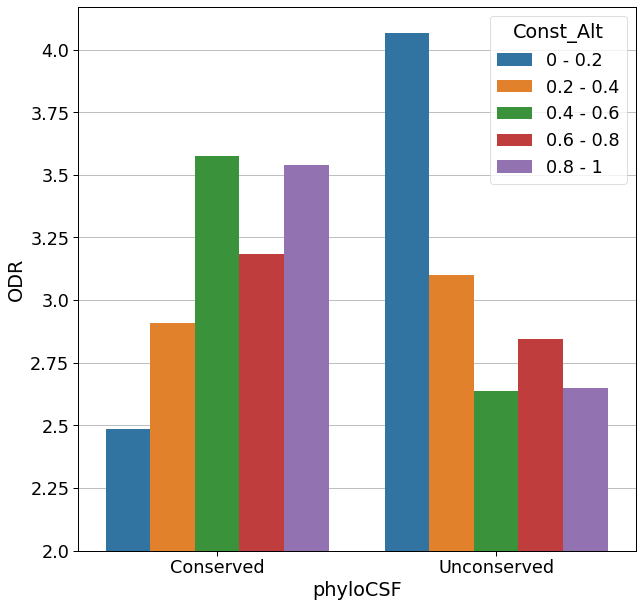

In [203]:
d = pd.pivot_table(pd.merge(merge_df_variants.loc[merge_df_variants['Const_Alt'] == 'Alt'], df22[['ranges', 'phyloCSF_score_bins']], on='ranges').drop(['HPO'], axis=1).drop_duplicates().groupby(['Status', 'Ratio_num_bins', 'phyloCSF_score_bins']).size().reset_index(), index=['phyloCSF_score_bins', 'Status'], columns='Ratio_num_bins', values=0).to_dict()
new_d = collections.defaultdict(dict)
for k in d:
    new_d[k] = dict()
    for sub_k, v in d[k].items():
        if sub_k[0] not in new_d[k]:
            new_d[k][sub_k[0]] = dict()
        new_d[k][sub_k[0]][sub_k[1]] = v
new_d
# odr_alt = list()
# odr_const = list()
labels = list(new_d[list(new_d.keys())[0]].keys())
labels

l = list()


for const_alt in new_d:
    for ccr in new_d[const_alt]:
        b = new_d[const_alt][ccr]['Benign']
        p = new_d[const_alt][ccr]['Pathogenic']
        other_b = sum([new_d[const_alt][e]['Benign'] for e in labels if new_d[const_alt][e]['Benign'] != b])
        other_p= sum([new_d[const_alt][e]['Pathogenic'] for e in labels if new_d[const_alt][e]['Pathogenic'] != p])
        print(const_alt, b, p, other_b, other_p, ccr)
        odr = ((p / b) / (other_p / other_b))
        l.append(
            {
                'Const_Alt' : const_alt,
                'phyloCSF' : ccr,
                'ODR' : odr,
            }        
        )
t = pd.DataFrame(l)
# # t['ODR'] = t['ODR'] -1 
# # t

f, ax = plt.subplots(figsize=(10,10))
ax.set_axisbelow(True)
ax.grid(True, axis='y')
sns.barplot(data=t, x='phyloCSF', y='ODR', hue='Const_Alt', bottom=1)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x+1))
# plt.yscale('lor')


In [339]:
pd.pivot_table(pd.merge(merge_df_variants.loc[merge_df_variants['Const_Alt'] == 'Alt'], df22[['ranges', 'phyloCSF_score_bins']], on='ranges').drop(['HPO'], axis=1).drop_duplicates().groupby(['Status', 'Ratio_num_bins', 'phyloCSF_score_bins']).size().reset_index(), index=['phyloCSF_score_bins', 'Status'], columns='Ratio_num_bins', values=0)

Ratio_num_bins                  0 - 0.2  0.2 - 0.4  0.4 - 0.6  0.6 - 0.8  \
phyloCSF_score_bins Status                                                 
Conserved           Benign          403        554       1999       1907   
                    Pathogenic       17         96        892        653   
Unconserved         Benign           74        379        545        284   
                    Pathogenic        6        100        144         70   

Ratio_num_bins                  0.8 - 1  
phyloCSF_score_bins Status               
Conserved           Benign         1880  
                    Pathogenic     1041  
Unconserved         Benign           51  
                    Pathogenic        6

Conserved 287 17 4888 2678 0 - 0.2
Conserved 277 96 4898 2599 0.2 - 0.4
Conserved 1486 889 3689 1806 0.4 - 0.6
Conserved 1434 652 3741 2043 0.6 - 0.8
Conserved 1691 1041 3484 1654 0.8 - 1
Unconserved 49 6 838 314 0 - 0.2
Unconserved 262 100 625 226 0.2 - 0.4
Unconserved 379 144 508 182 0.4 - 0.6
Unconserved 182 70 705 256 0.6 - 0.8
Unconserved 15 6 872 314 0.8 - 1


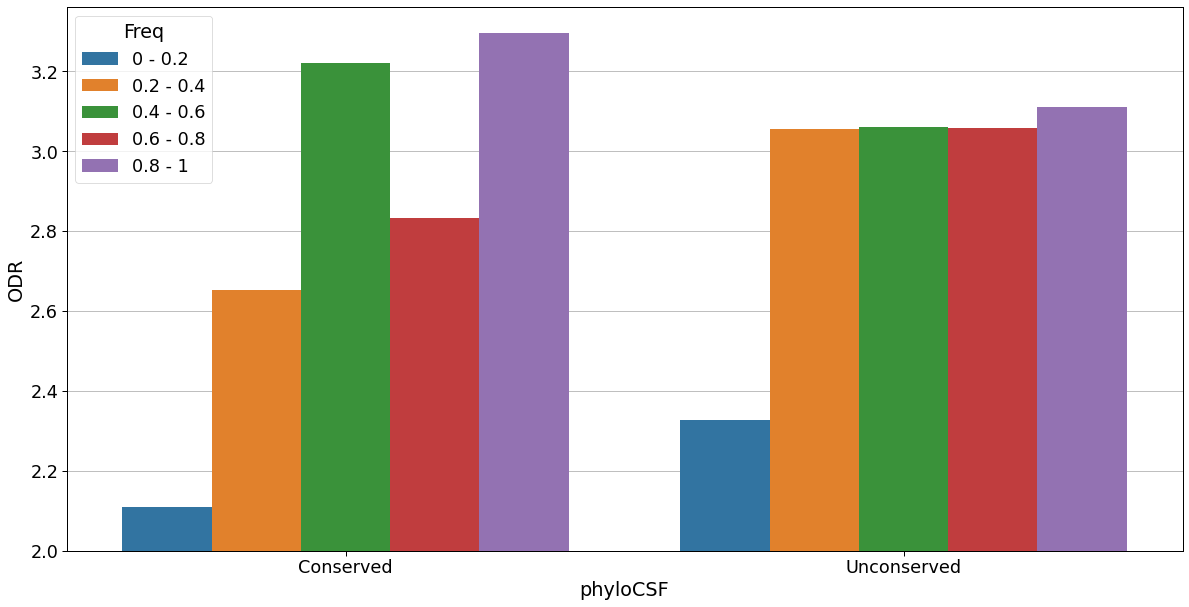

In [205]:
d = pd.pivot_table(pd.merge(merge_df_variants.loc[merge_df_variants['Const_Alt'] == 'Alt'], df22[['ranges', 'phyloCSF_score_bins']], on='ranges').drop(['HPO'], axis=1).drop_duplicates().groupby(['Status', 'Ratio_num_bins', 'phyloCSF_score_bins']).size().reset_index(), index=['Ratio_num_bins', 'Status'], columns='phyloCSF_score_bins', values=0).to_dict()
new_d = collections.defaultdict(dict)
for k in d:
    new_d[k] = dict()
    for sub_k, v in d[k].items():
        if sub_k[0] not in new_d[k]:
            new_d[k][sub_k[0]] = dict()
        new_d[k][sub_k[0]][sub_k[1]] = v
new_d
# odr_alt = list()
# odr_const = list()
labels = list(new_d[list(new_d.keys())[0]].keys())
labels

l = list()


for const_alt in new_d:
    for ccr in new_d[const_alt]:
        b = new_d[const_alt][ccr]['Benign']
        p = new_d[const_alt][ccr]['Pathogenic']
        other_b = sum([new_d[const_alt][e]['Benign'] for e in labels if new_d[const_alt][e]['Benign'] != b])
        other_p= sum([new_d[const_alt][e]['Pathogenic'] for e in labels if new_d[const_alt][e]['Pathogenic'] != p])
        print(const_alt, b, p, other_b, other_p, ccr)
        odr = ((p / b) / (other_p / other_b))
        l.append(
            {
                'phyloCSF' : const_alt,
                'Freq' : ccr,
                'ODR' : odr,
            }        
        )
t = pd.DataFrame(l)
# # t['ODR'] = t['ODR'] -1 
# # t

f, ax = plt.subplots(figsize=(20,10))
ax.set_axisbelow(True)
ax.grid(True, axis='y')
sns.barplot(data=t, x='phyloCSF', y='ODR', hue='Freq', bottom=1)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: round(x+1, 2)))
# plt.yscale('lor')


In [432]:
pd.pivot_table(pd.merge(merge_df_variants.loc[merge_df_variants['Const_Alt'] == 'Alt'], df22[['ranges', 'phyloCSF_score_bins']], on='ranges').drop(['HPO'], axis=1).drop_duplicates().groupby(['Status', 'phyloCSF_score_bins']).size().reset_index(), index=['Status'], columns='phyloCSF_score_bins', values=0)

phyloCSF_score_bins,Conserved,Unconserved
Status,,
Benign,6743,1333
Pathogenic,2699,326


In [435]:
# basic ODR
(2699/6743)/(326/1333)

1.636674342581127

In [436]:
pd.pivot_table(tmp_merge_cons_ccrs_variants.loc[tmp_merge_cons_ccrs_variants['Const_Alt'] == 'Alt'].groupby(['Status', 'phyloCSF_score_bins', 'CCRS_bins']).size().reset_index(), index=['phyloCSF_score_bins', 'Status'], columns='CCRS_bins', values=0)

CCRS_bins                       0 - 20  20 - 80  80 - 90  90 - 95  95 - 99  \
phyloCSF_score_bins Status                                                   
Conserved           Benign      4337.0   2477.0    338.0    116.0     80.0   
                    Pathogenic  1328.0   1080.0    158.0     81.0     69.0   
Unconserved         Benign       987.0    404.0     24.0      9.0      4.0   
                    Pathogenic   224.0    108.0     10.0      NaN      NaN   

CCRS_bins                       99 - 100  
phyloCSF_score_bins Status                
Conserved           Benign          15.0  
                    Pathogenic      24.0  
Unconserved         Benign           NaN  
                    Pathogenic       NaN

0 - 20 21184.0 708.0 3281.0 90.0 Conserved
0 - 20 3281.0 90.0 21184.0 708.0 Unconserved
20 - 80 4677.0 545.0 639.0 46.0 Conserved
20 - 80 639.0 46.0 4677.0 545.0 Unconserved
80 - 90 294.0 63.0 19.0 4.0 Conserved
80 - 90 19.0 4.0 294.0 63.0 Unconserved
90 - 95 70.0 47.0 5.0 nan Conserved
90 - 95 5.0 nan 70.0 nan Unconserved
95 - 99 37.0 32.0 15.0 nan Conserved
95 - 99 15.0 nan 37.0 nan Unconserved
99 - 100 3.0 15.0 nan nan Conserved
99 - 100 nan nan nan nan Unconserved


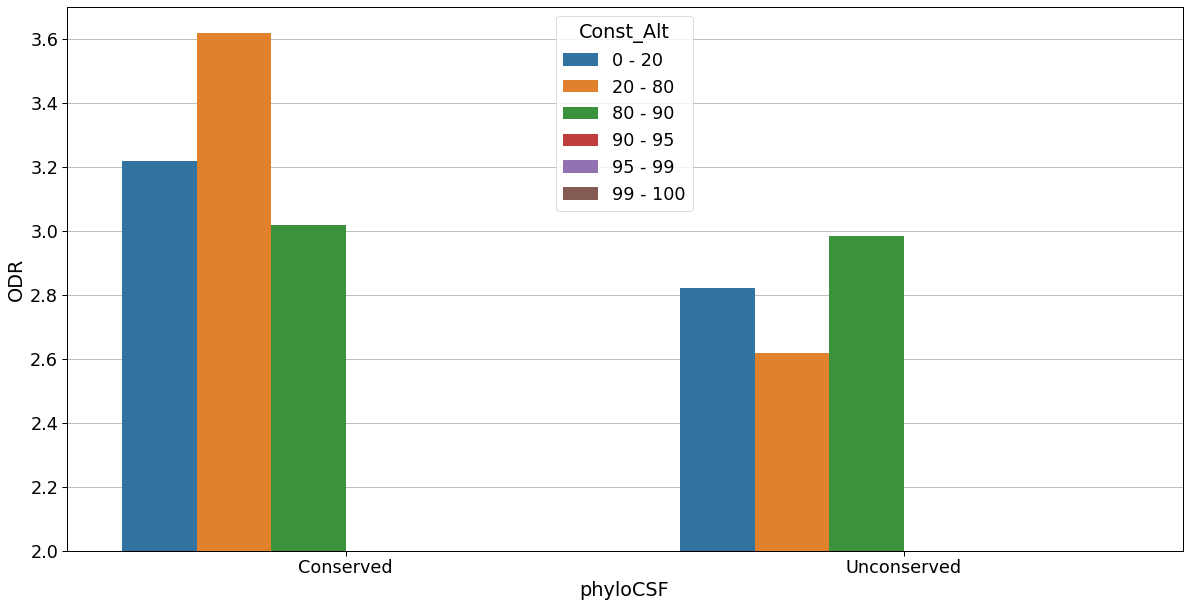

In [206]:

d = pd.pivot_table(tmp_merge_cons_ccrs_variants.loc[tmp_merge_cons_ccrs_variants['Const_Alt'] == 'Alt'].groupby(['Status', 'phyloCSF_score_bins', 'CCRS_bins']).size().reset_index(), index=['phyloCSF_score_bins', 'Status'], columns='CCRS_bins', values=0).to_dict()
new_d = collections.defaultdict(dict)
for k in d:
    new_d[k] = dict()
    for sub_k, v in d[k].items():
        if sub_k[0] not in new_d[k]:
            new_d[k][sub_k[0]] = dict()
        new_d[k][sub_k[0]][sub_k[1]] = v
new_d
labels = list(new_d[list(new_d.keys())[0]].keys())
labels

l = list()


for const_alt in new_d:
    for ccr in new_d[const_alt]:
        b = new_d[const_alt][ccr]['Benign']
        p = new_d[const_alt][ccr]['Pathogenic']
        other_b = sum([new_d[const_alt][e]['Benign'] for e in labels if new_d[const_alt][e]['Benign'] != b])
        other_p= sum([new_d[const_alt][e]['Pathogenic'] for e in labels if new_d[const_alt][e]['Pathogenic'] != p])
        print(const_alt, b, p, other_b, other_p, ccr)
        odr = ((p / b) / (other_p / other_b))
        l.append(
            {
                'Const_Alt' : const_alt,
                'phyloCSF' : ccr,
                'ODR' : odr,
            }        
        )
t = pd.DataFrame(l)
# # t['ODR'] = t['ODR'] -1 
# # t

f, ax = plt.subplots(figsize=(20,10))
ax.set_axisbelow(True)
ax.grid(True, axis='y')
sns.barplot(data=t, x='phyloCSF', y='ODR', hue='Const_Alt', bottom=1)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: round(x+1, 2)))
# plt.yscale('lor')


In [ ]:
pd.pivot_table(pd.merge(merge_df_variants.loc[merge_df_variants['Const_Alt'] == 'Alt'], df22[['ranges', 'phyloCSF_score_bins']], on='ranges').drop(['HPO'], axis=1).drop_duplicates().groupby(['Status', 'Ratio_num_bins', 'phyloCSF_score_bins', 'CCRS_bins']).size().reset_index(), index=['phyloCSF_score_bins', 'Status'], columns='Ratio_num_bins', values=0)

In [369]:
merge_df_variants

,Gene,VAR_ID,MC,Status,Real_Status,RS_STARS,CLNREVSTAT,HPO,rs,alleleid,POS,ranges,Ratio_num,Const_Alt,Ratio_num_bins
0,A1CF,10_52573772_C_['T'],missense_variant,Benign,Likely_benign,1,"criteria_provided,_single_submitter",[],41274050,712394,52573772,52573617-52573798,1.0,Const,0.8 - 1
1,A1CF,10_52573797_C_['T'],synonymous_variant,Benign,Likely_benign,1,"criteria_provided,_single_submitter",[],924638663,767784,52573797,52573617-52573798,1.0,Const,0.8 - 1
2,A1CF,10_52576025_G_['A'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],142026324,701372,52576025,52575766-52576039,1.0,Const,0.8 - 1
3,A1CF,10_52595853_C_['T'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],61742973,712395,52595853,52595834-52596072,1.0,Const,0.8 - 1
4,A1CF,10_52603754_A_['G'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],35967725,712396,52603754,52603748-52603882,1.0,Const,0.8 - 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477394,ZYX,7_143085922_G_['A'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],75965463,710836,143085922,143085860-143086038,1.0,Const,0.8 - 1
477395,ZYX,7_143085922_G_['A'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],75965463,710836,143085922,143085860-143086038,1.0,Const,0.8 - 1
477396,ZYX,7_143085985_C_['T'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],142288548,736003,143085985,143085860-143086038,1.0,Const,0.8 - 1
477397,ZYX,7_143085985_C_['T'],synonymous_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[],142288548,736003,143085985,143085860-143086038,1.0,Const,0.8 - 1


In [463]:
pd.pivot_table(tmp_merge_cons_ccrs_variants.loc[tmp_merge_cons_ccrs_variants['Const_Alt'] == 'Alt'].groupby(['Status', 'phyloCSF_score_bins', 'CCRS_bins']).size().reset_index(), index=['Status', 'phyloCSF_score_bins'], columns='CCRS_bins', values=0).fillna(0).astype(int)

CCRS_bins                       0 - 20  20 - 80  80 - 90  90 - 95  95 - 99  \
Status     phyloCSF_score_bins                                               
Benign     Conserved              4337     2477      338      116       80   
           Unconserved             987      404       24        9        4   
Pathogenic Conserved              1328     1080      158       81       69   
           Unconserved             224      108       10        0        0   

CCRS_bins                       99 - 100  
Status     phyloCSF_score_bins            
Benign     Conserved                  15  
           Unconserved                 0  
Pathogenic Conserved                  24  
           Unconserved                 0

In [459]:

# d = pd.pivot_table(tmp_merge_cons_ccrs_variants.loc[tmp_merge_cons_ccrs_variants['Const_Alt'] == 'Alt'].groupby(['Status', 'phyloCSF_score_bins', 'CCRS_bins']).size().reset_index(), index=['phyloCSF_score_bins', 'Status'], columns='CCRS_bins', values=0).to_dict()
d = tmp_merge_cons_ccrs_variants.loc[tmp_merge_cons_ccrs_variants['Const_Alt'] == 'Alt'].groupby(['Status', 'phyloCSF_score_bins', 'CCRS_bins']).size().reset_index()
d
# sns.set_context('paper')

# g = sns.FacetGrid(d, row='CCRS_bins', size=4, aspect=2)
# g.map_dataframe(sns.barplot, x='phyloCSF_score_bins', y=0, hue='Status', palette=['g', 'r'])
# plt.yscale('log')
# # new_d = collections.defaultdict(dict)
# for k in d:
#     new_d[k] = dict()
#     for sub_k, v in d[k].items():
#         if sub_k[0] not in new_d[k]:
#             new_d[k][sub_k[0]] = dict()
#         new_d[k][sub_k[0]][sub_k[1]] = v
# new_d
#         print(new_d[k][sub_k[0]][sub_k[1]], type(new_d[k][sub_k[0]][sub_k[1]]))
# new_new_d = collections.defaultdict(dict)
# for ccr in new_d:
#     for cons_uncons in new_d[ccr]:
        
#         if np.isnan(new_d[ccr][cons_uncons]['Benign']) or np.isnan(new_d[ccr][cons_uncons]['Pathogenic']):
#             pass
#         else:
#             new_new_d[ccr][cons_uncons] = dict() 
#             new_new_d[ccr][cons_uncons]['Benign'] = 0
#             new_new_d[ccr][cons_uncons]['Pathogenic'] = 0
#             new_new_d[ccr][cons_uncons]['Benign'] = new_d[ccr][cons_uncons]['Benign']
#             new_new_d[ccr][cons_uncons]['Pathogenic'] = new_d[ccr][cons_uncons]['Pathogenic']
# new_d = new_new_d
# labels = list(new_d[list(new_d.keys())[0]].keys())
# labels

# l = list()


# for const_alt in new_d:
#     for ccr in new_d[const_alt]:
#         b = new_d[const_alt][ccr]['Benign']
#         p = new_d[const_alt][ccr]['Pathogenic']
#         other_b = sum([new_d[const_alt][e]['Benign'] for e in labels if e in new_d[const_alt] and new_d[const_alt][e]['Benign'] != b])
#         other_p= sum([new_d[const_alt][e]['Pathogenic'] for e in labels if e in new_d[const_alt] and new_d[const_alt][e]['Pathogenic'] != p])
#         print(const_alt, b, p, other_b, other_p, ccr)
#         try:
            
#             odr = ((p / b) / (other_p / other_b))-1
#             l.append(
#                 {
#                     'Const_Alt' : const_alt,
#                     'phyloCSF' : ccr,
#                     'ODR' : odr,
#                 }        
#             )
#         except ZeroDivisionError:
#             pass
# t = pd.DataFrame(l)
# # # t['ODR'] = t['ODR'] -1 
# # # t

# f, ax = plt.subplots(figsize=(20,10))
# ax.set_axisbelow(True)
# ax.grid(True, axis='y')
# sns.barplot(data=t, x='phyloCSF', y='ODR', hue='Const_Alt')
# plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x+1))
# # plt.yscale('lor')


,Status,phyloCSF_score_bins,CCRS_bins,0
0,Benign,Conserved,0 - 20,4337
1,Benign,Conserved,20 - 80,2477
2,Benign,Conserved,80 - 90,338
3,Benign,Conserved,90 - 95,116
4,Benign,Conserved,95 - 99,80
5,Benign,Conserved,99 - 100,15
6,Benign,Unconserved,0 - 20,987
7,Benign,Unconserved,20 - 80,404
8,Benign,Unconserved,80 - 90,24
9,Benign,Unconserved,90 - 95,9


In [458]:
pd.pivot_table(tmp_merge_cons_ccrs_variants.loc[tmp_merge_cons_ccrs_variants['Const_Alt'] == 'Alt'].groupby(['Status', 'phyloCSF_score_bins', 'CCRS_bins']).size().reset_index(), index=['phyloCSF_score_bins', 'Status'], columns='CCRS_bins', values=0).fillna(0)

CCRS_bins                       0 - 20  20 - 80  80 - 90  90 - 95  95 - 99  \
phyloCSF_score_bins Status                                                   
Conserved           Benign      4337.0   2477.0    338.0    116.0     80.0   
                    Pathogenic  1328.0   1080.0    158.0     81.0     69.0   
Unconserved         Benign       987.0    404.0     24.0      9.0      4.0   
                    Pathogenic   224.0    108.0     10.0      0.0      0.0   

CCRS_bins                       99 - 100  
phyloCSF_score_bins Status                
Conserved           Benign          15.0  
                    Pathogenic      24.0  
Unconserved         Benign           0.0  
                    Pathogenic       0.0

0 - 20 4337.0 1328.0 987.0 224.0 Conserved
0 - 20 987.0 224.0 4337.0 1328.0 Unconserved
20 - 80 2477.0 1080.0 404.0 108.0 Conserved
20 - 80 404.0 108.0 2477.0 1080.0 Unconserved
80 - 90 338.0 158.0 24.0 10.0 Conserved
80 - 90 24.0 10.0 338.0 158.0 Unconserved
90 - 95 116.0 81.0 0 0 Conserved
95 - 99 80.0 69.0 0 0 Conserved
99 - 100 15.0 24.0 0 0 Conserved


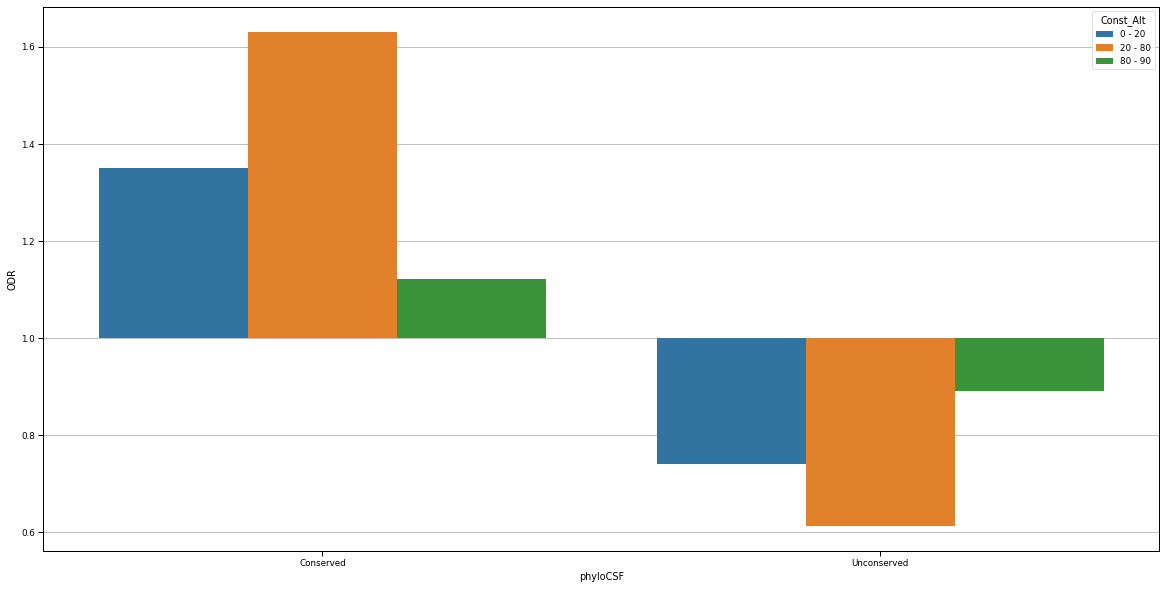

In [437]:

d = pd.pivot_table(tmp_merge_cons_ccrs_variants.loc[tmp_merge_cons_ccrs_variants['Const_Alt'] == 'Alt'].groupby(['Status', 'phyloCSF_score_bins', 'CCRS_bins']).size().reset_index(), index=['phyloCSF_score_bins', 'Status'], columns='CCRS_bins', values=0).to_dict()
new_d = collections.defaultdict(dict)
for k in d:
    new_d[k] = dict()
    for sub_k, v in d[k].items():
        if sub_k[0] not in new_d[k]:
            new_d[k][sub_k[0]] = dict()
        new_d[k][sub_k[0]][sub_k[1]] = v
#         print(new_d[k][sub_k[0]][sub_k[1]], type(new_d[k][sub_k[0]][sub_k[1]]))
new_new_d = collections.defaultdict(dict)
for ccr in new_d:
    for cons_uncons in new_d[ccr]:
        
        if np.isnan(new_d[ccr][cons_uncons]['Benign']) or np.isnan(new_d[ccr][cons_uncons]['Pathogenic']):
            pass
        else:
            new_new_d[ccr][cons_uncons] = dict() 
            new_new_d[ccr][cons_uncons]['Benign'] = 0
            new_new_d[ccr][cons_uncons]['Pathogenic'] = 0
            new_new_d[ccr][cons_uncons]['Benign'] = new_d[ccr][cons_uncons]['Benign']
            new_new_d[ccr][cons_uncons]['Pathogenic'] = new_d[ccr][cons_uncons]['Pathogenic']
new_d = new_new_d
labels = list(new_d[list(new_d.keys())[0]].keys())
labels

l = list()


for const_alt in new_d:
    for ccr in new_d[const_alt]:
        b = new_d[const_alt][ccr]['Benign']
        p = new_d[const_alt][ccr]['Pathogenic']
        other_b = sum([new_d[const_alt][e]['Benign'] for e in labels if e in new_d[const_alt] and new_d[const_alt][e]['Benign'] != b])
        other_p= sum([new_d[const_alt][e]['Pathogenic'] for e in labels if e in new_d[const_alt] and new_d[const_alt][e]['Pathogenic'] != p])
        print(const_alt, b, p, other_b, other_p, ccr)
        try:
            
            odr = ((p / b) / (other_p / other_b))-1
            l.append(
                {
                    'Const_Alt' : const_alt,
                    'phyloCSF' : ccr,
                    'ODR' : odr,
                }        
            )
        except ZeroDivisionError:
            pass
t = pd.DataFrame(l)
# # t['ODR'] = t['ODR'] -1 
# # t

f, ax = plt.subplots(figsize=(20,10))
ax.set_axisbelow(True)
ax.grid(True, axis='y')
sns.barplot(data=t, x='phyloCSF', y='ODR', hue='Const_Alt')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: round(x+1, 2)))
# plt.yscale('lor')
